# Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import json
import pickle
import glob
import ast
from geopy import distance
import sys, os
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8)})
from collections import Counter
import calendar
from datetime import datetime, timedelta

# statistical
from sklearn.neighbors import KernelDensity

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

base_path = '/content/gdrive/MyDrive/complexsystems/'

Mounted at /content/gdrive


# WHAT-IF 1

per vedere se c'e' differenza nel numero di viaggi e nelle tempistiche medie (impatto di quella stazione) nel caso in cui venga rimossa la stazione o meno

In [ ]:
deletedstation = 311

### Functions

In [ ]:
def get_tripsdf(files, changed=False, lost=False, deletedstation=None):

  trips = []

  for f in files:
    params = f.split('_')
    seed = params[2][4:]
    start_time = params[3][5:]
    end_time = params[4][3:]
    delete_stat = params[5][7:]
    n_bikes = params[6][5:-4]

    tmpdf = pd.read_csv(f).sort_values(by='time1')

    
    tmpdf['id1'] = tmpdf['id1'].astype('float') 
    tmpdf['id2'] = tmpdf['id2'].astype('float')
    if deletedstation:
      tmpdf = tmpdf[(tmpdf['id1'] == deletedstation) | (tmpdf['id2'] == deletedstation)]
    
    tmpcount = None
    if changed:
      tmpdf = tmpdf[(tmpdf['changed'] == changed)]
    if lost:
      tmpdf = tmpdf[(tmpdf['lost'] == lost) ]
      if deletedstation:
        tmpdf = tmpdf[(tmpdf['id1'] == deletedstation)]
        
      tmpcount = len(tmpdf)
    
    tmpdf = tmpdf['duration'].describe()

    if not tmpcount:
      tmpcount = tmpdf.loc['count']

    trips.append([tmpcount, tmpdf.loc['mean'], tmpdf.loc['std'], seed, delete_stat])

  tripsdf = pd.DataFrame(trips, columns=['count', 'mean', 'std', 'seed', 'delete_stat'])
  return tripsdf

In [ ]:
def stat_test(df, field, deletedstation):

  tmp1 = df[df['delete_stat'] == 'None'].reset_index()
  tmp2 = df[df['delete_stat'] == str(deletedstation)].reset_index()

  plt.plot(tmp1[field], label='not removed')
  plt.plot(tmp2[field], label='removed')
  plt.legend()

  stat = ttest_ind(tmp1[field].values, tmp2[field].values)
  print(stat)

  if stat.pvalue < 0.05:
    print("reject null hypotesis that the two independent samples have identical average")
  else:
    print("DONT reject null hypotesis that the  two independent samples have identical average")

### Load files

In [ ]:
files = glob.glob(base_path+"data/simulation_history/history_*station[0-9]*.csv")

removed_changed = get_tripsdf(files, changed=True, lost=False)
removed_lost = get_tripsdf(files, changed=False, lost=True, deletedstation=deletedstation)
removed_lost_full = get_tripsdf(files, changed=False, lost=True)
removed_done = get_tripsdf(files, changed=False, lost=False)

In [ ]:
files = glob.glob(base_path+"data/simulation_history/history_*stationNone_*.csv")

notremoved_lost = get_tripsdf(files, changed=False, lost=True, deletedstation=deletedstation)

notremoved_lost_full = get_tripsdf(files, changed=False, lost=True)
notremoved_done = get_tripsdf(files, changed=False, lost=False)
notremoved_done_only = get_tripsdf(files, changed=False, lost=False, deletedstation=deletedstation)

In [ ]:
changed = pd.concat([removed_changed, notremoved_done_only])
lost = pd.concat([removed_lost, notremoved_lost])
lost_full = pd.concat([removed_lost_full, notremoved_lost_full])
done = pd.concat([removed_done, notremoved_done])


In [ ]:
display(changed)

count       mean       std seed delete_stat
0  167.0  10.389222  4.688939    0         311
1  202.0  10.024752  4.036449    1         311
2  194.0  10.438144  4.848886    2         311
3  217.0   9.769585  4.160261    3         311
4  161.0  10.372671  3.854899    4         311
5  187.0  10.401070  4.272266    5         311
6  176.0  10.454545  4.575485    6         311
7  172.0   9.505814  3.772007    7         311
8  185.0  10.297297  4.143256    8         311
9  197.0  10.355330  5.187862    9         311
0  306.0  10.294118  4.098592    0        None
1  374.0  10.775401  4.324360    1        None
2  349.0  10.530086  4.178810    2        None
3  379.0  10.936675  4.511150    3        None
4  368.0  10.951087  4.388218    4        None
5  297.0  10.589226  4.240206    5        None
6  388.0  10.360825  4.267988    6        None
7  383.0  10.326371  4.245171    7        None
8  346.0  10.578035  4.626450    8        None
9  395.0  10.556962  4.457204    9        None

In [ ]:
display(lost)

count  mean  std seed delete_stat
0    287   NaN  NaN    0         311
1    307   NaN  NaN    1         311
2    319   NaN  NaN    2         311
3    251   NaN  NaN    3         311
4    275   NaN  NaN    4         311
5    282   NaN  NaN    5         311
6    287   NaN  NaN    6         311
7    292   NaN  NaN    7         311
8    256   NaN  NaN    8         311
9    292   NaN  NaN    9         311
0    377   NaN  NaN    0        None
1    376   NaN  NaN    1        None
2    404   NaN  NaN    2        None
3    354   NaN  NaN    3        None
4    358   NaN  NaN    4        None
5    427   NaN  NaN    5        None
6    325   NaN  NaN    6        None
7    355   NaN  NaN    7        None
8    411   NaN  NaN    8        None
9    320   NaN  NaN    9        None

In [ ]:
display(done)

count       mean       std seed delete_stat
0  6671.0  10.956378  4.334207    0         311
1  6348.0  10.841997  4.233877    1         311
2  6331.0  10.914547  4.310331    2         311
3  6702.0  10.887049  4.358599    3         311
4  6644.0  10.885009  4.268678    4         311
5  6819.0  10.940754  4.323391    5         311
6  6343.0  11.038152  4.372277    6         311
7  6532.0  10.955297  4.272866    7         311
8  6819.0  10.950286  4.301319    8         311
9  6696.0  10.949821  4.309864    9         311
0  6391.0  10.882491  4.309482    0        None
1  6248.0  10.920294  4.307463    1        None
2  6887.0  10.922027  4.287706    2        None
3  6297.0  10.994124  4.326949    3        None
4  6830.0  10.884334  4.287901    4        None
5  6124.0  10.859732  4.234636    5        None
6  6550.0  10.948092  4.275452    6        None
7  6495.0  10.890685  4.262202    7        None
8  6360.0  10.912736  4.297232    8        None
9  6832.0  10.914081  4.268588    9        None

### Analisi sui viaggi che interessano la stazione che verra' rimossa & i viaggi con destinazione o partenza cambiata dopo che la stazione e' stata rimossa

in conclusione, non sembrano esserci differenze statistiche date dalla rimozione della stazione in termini di numero di viaggi e di durata media dei viaggi , ergo la rimozione di quella stazione (forse più in generale di una singola stazione) non ha un impatto elevato sul traffico generale

Ttest_indResult(statistic=3.0561957050503397, pvalue=0.0067999101753826695)
reject null hypotesis that the two independent samples have identical average


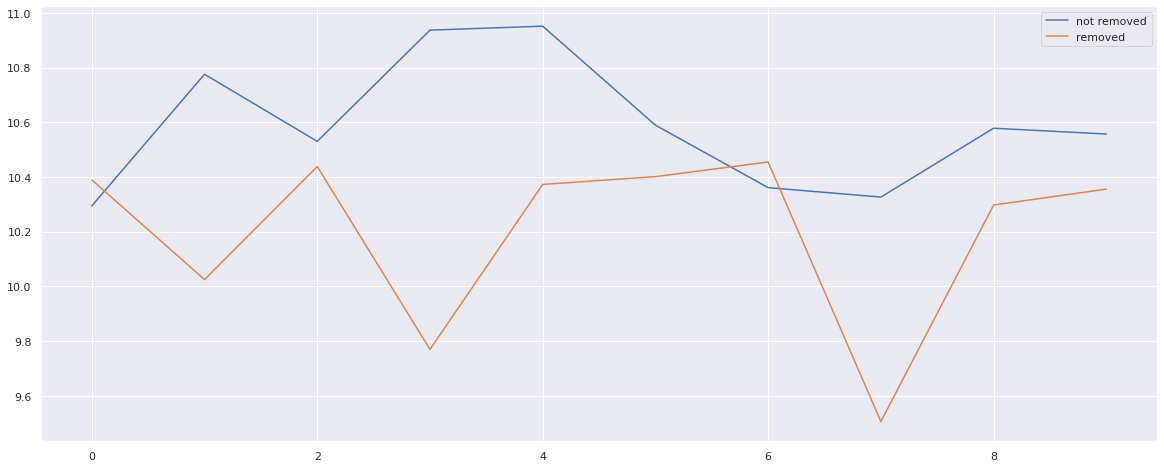

In [ ]:
stat_test(changed, 'mean', deletedstation)


Ttest_indResult(statistic=14.356207644670704, pvalue=2.6794288066236913e-11)
reject null hypotesis that the two independent samples have identical average


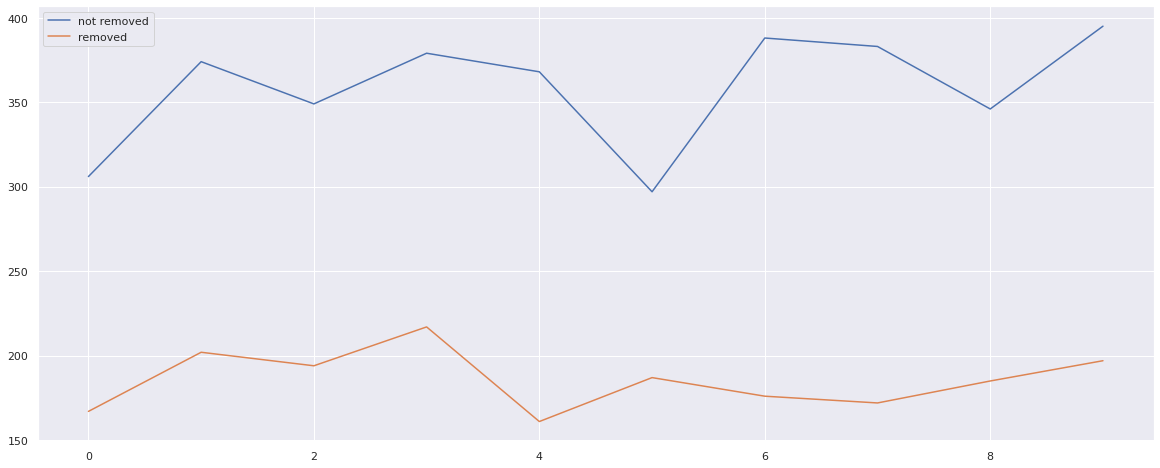

In [ ]:
stat_test(changed, 'count', deletedstation)

### Analisi sui viaggi persi

analizzando i viaggi persi relativi alla stazione in esame nel caso in cui questa fosse rimossa o meno, notiamo una differenza statistica del numero di viaggi persi, decisamente minore nel caso in cui la stazione è rimossa, a possibile dimostrazione della sua inefficenza 

Ttest_indResult(statistic=6.616899728173159, pvalue=3.2667501503384325e-06)
reject null hypotesis that the two independent samples have identical average


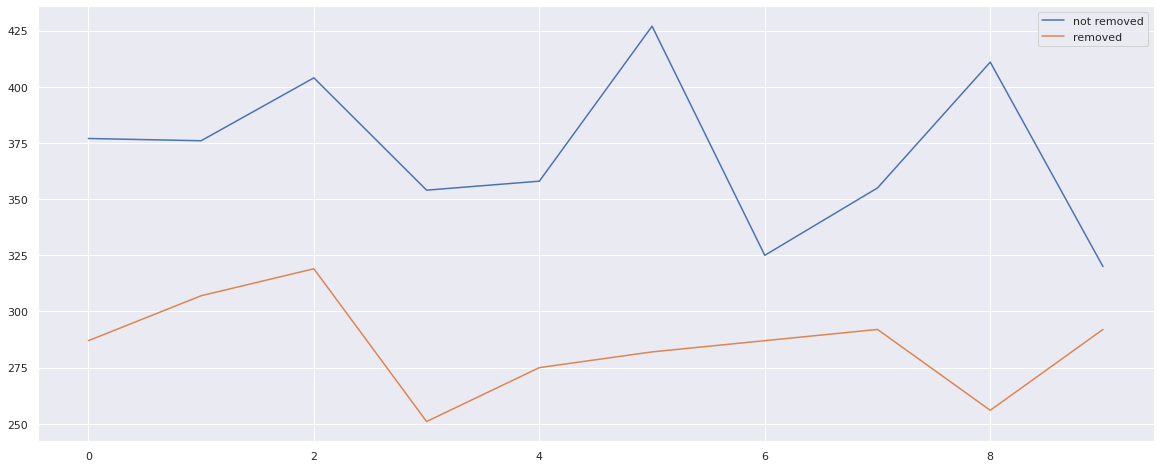

In [ ]:
stat_test(lost, 'count', deletedstation)

analizzando i viaggi persi totali nel caso in cui la stazione fosse rimossa o meno, non si nota una differenza significativa tra il numero di viaggi persi totali 

*(molto elevati, si potrebbe pensare e proporre un metodo per ridurli e.g. aumentare bici o stazioni (non possiamo farlo))*

Ttest_indResult(statistic=0.9475189740193676, pvalue=0.3559225037968323)
DONT reject null hypotesis that the two independent samples have identical average


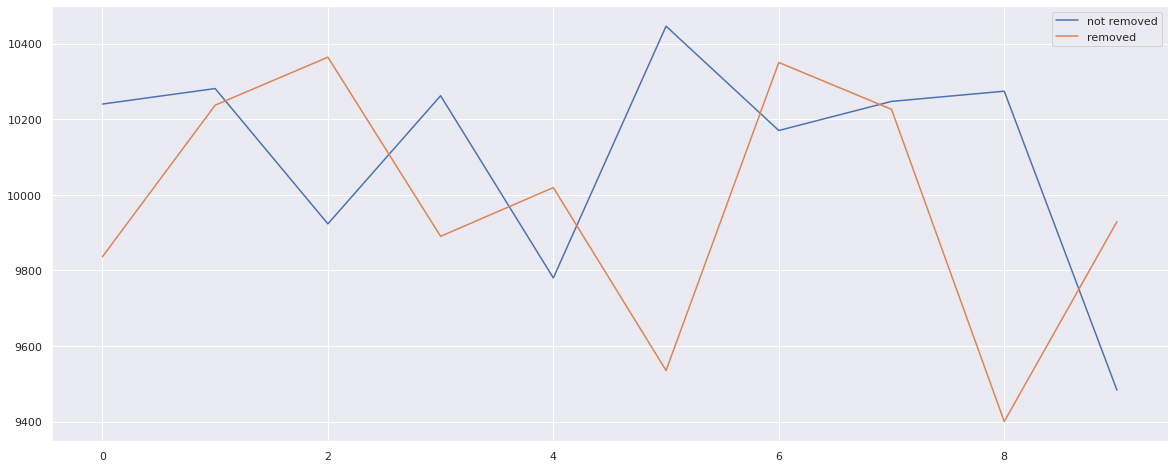

In [ ]:
stat_test(lost_full, 'count', deletedstation)

### Analisi sui viaggi effettuati

anche il numero di viaggi effettuati non cambia significativamente rimuovendo la stazione

Ttest_indResult(statistic=-0.8551146815799359, pvalue=0.4037264611424448)
DONT reject null hypotesis that the two independent samples have identical average


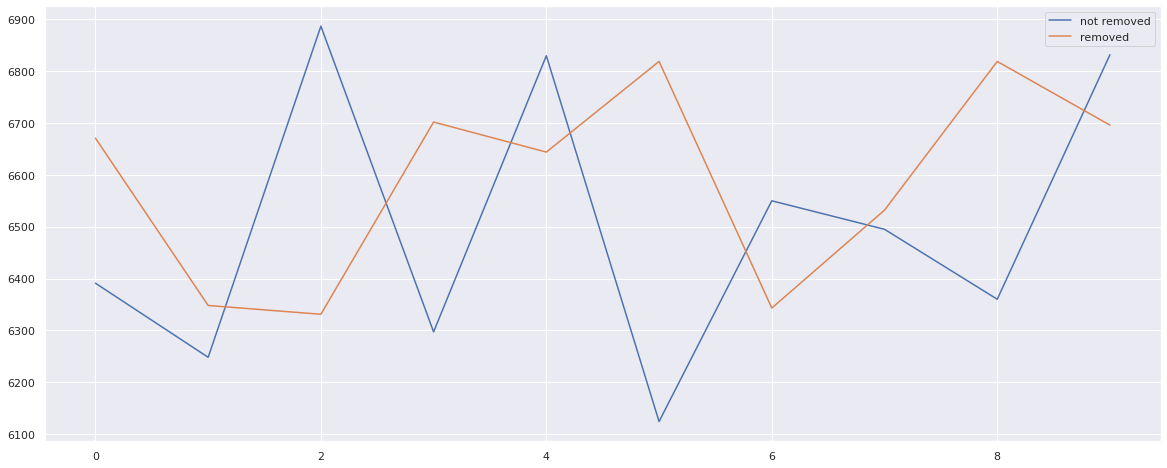

In [ ]:
stat_test(done, 'count', deletedstation)

neppure la durata media dei viaggi cambia rimuovendo la stazione

Ttest_indResult(statistic=-0.9183786332129792, pvalue=0.3705636522496083)
DONT reject null hypotesis that the two independent samples have identical average


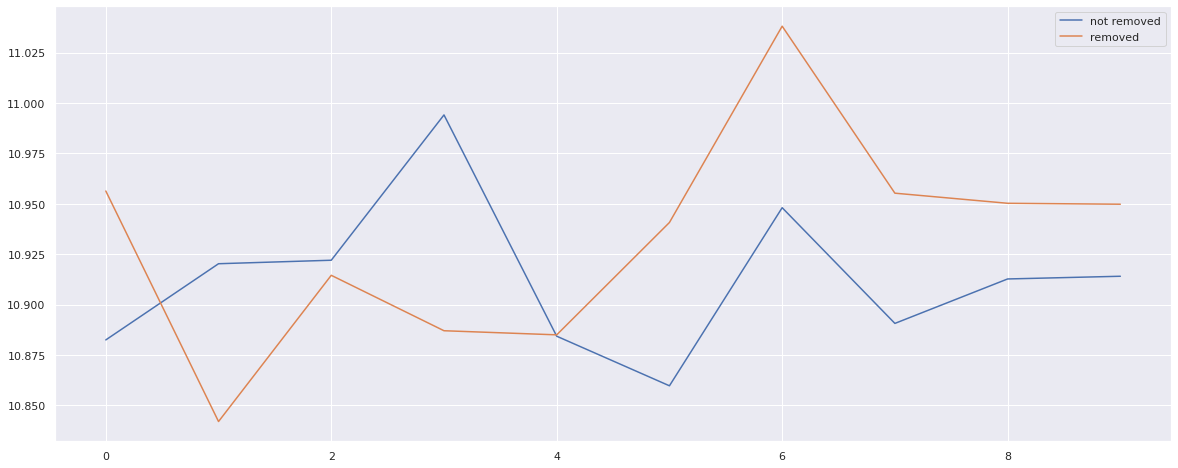

In [ ]:
stat_test(done, 'mean', deletedstation)

in conclusione, non sembrano esserci differenze statistiche date dalla rimozione della stazione in termini di numero di viaggi e di durata media dei viaggi , ergo quella stazione non ha un impatto elevato sul traffico generale

## grafico utilizzo stazione

In [ ]:
df = pd.read_csv(base_path + "data/simulation_history4/history_seed111_start2018-01-01_end2019-01-01_stationNone_bikes920.csv")
df_ss = pd.read_csv(base_path + "data/simulation_history4/station_size.csv", index_col='Unnamed: 0')

In [33]:
df = pd.read_csv(base_path + "data/simulation_history5/history_seed111_start2018-01-01_end2020-01-01_stationNone_bikes2850.csv")
df_ss = pd.read_csv(base_path + "data/simulation_history5/station_size.csv", index_col='Unnamed: 0')

In [15]:
tmp_df = df.copy()
tmp_df['date'] = pd.to_datetime(tmp_df['time1'])

In [34]:
tmp_df['day'] = tmp_df['date'].dt.dayofyear
tmp_df['year'] = tmp_df['date'].dt.year

In [11]:
"""
worky
"""
def plot_station_bikes_history_full(df, station_id):
  tmp_df = df[(df['id1']== station_id) | (df['id2']== station_id)]

  tmp_df = tmp_df.dropna(subset=['id1', 'id2'])

  tot_bikes = df_ss[df_ss.index == station_id]['size'].values[0]

  bikes_history = []

  for x in range(len(tmp_df)):
    row = tmp_df.iloc[x]

    if row['id1'] == station_id:
      tot_bikes -= 1
    elif row['id2'] == station_id:
      tot_bikes += 1

    bikes_history.append(tot_bikes)


  plt.plot(bikes_history, label=str(station_id))
  plt.legend()
  plt.title(station_id)
  plt.show()

In [17]:
"""
buggato
"""
def plot_station_bikes_history(df, station_id):
  tmp_df = df[(df['id1']== station_id) | (df['id2']== station_id)]

  tmp_df = tmp_df.dropna(subset=['id1', 'id2'])

  tot_bikes = df_ss[df_ss.index == station_id]['size'].values[0]

  bikes_history = []
  for year in [2018, 2019]:
    tmp_df = tmp_df[tmp_df['year'] == year]
    for y in range(1, 366):
      tmp_1 = tmp_df[tmp_df['day'] == y]
      for x in range(len(tmp_1)):
        row = tmp_1.iloc[x]

        if row['id1'] == station_id:
          tot_bikes -= 1
        elif row['id2'] == station_id:
          tot_bikes += 1

      bikes_history.append(tot_bikes)


  plt.plot(bikes_history, label=str(station_id))
  plt.legend()
  plt.title(station_id)
  plt.show()

In [27]:
st = tmp_df[((tmp_df['id1'] == 297)| (tmp_df['id2'] == 297)) & (tmp_df['year'] == 2019)].dropna(subset=['id1','id2']).reset_index()

In [43]:
def print_station_history(df, station_id):
  bikes_history = []
  tot_bikes = df_ss[df_ss.index == station_id]['size'].values[0]
  for year in [2018, 2019]:
    st = df[((df['id1'] == station_id)| (df['id2'] == station_id)) & (df['year'] == year)].dropna(subset=['id1','id2']).reset_index()
    for y in range(1, 366):
      tmp_1 = st[st['day'] == y]
      for x in range(len(tmp_1)):
        row = tmp_1.iloc[x]

        if row['id1'] == station_id:
          tot_bikes -= 1
        elif row['id2'] == station_id:
          tot_bikes += 1

      bikes_history.append(tot_bikes)

  plt.plot(bikes_history, label=str(station_id))
  plt.legend()
  plt.title(station_id)
  plt.show()

In [44]:
for x in set(tmp_df['id1']):
  print_station_history(tmp_df, x)

Output hidden; open in https://colab.research.google.com to view.

2018-2020 2850 bikes

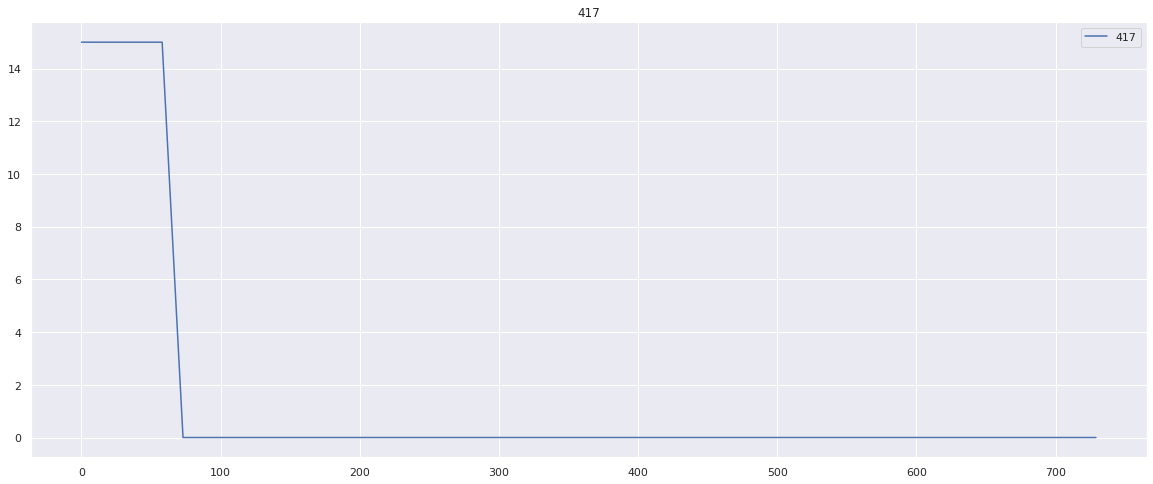

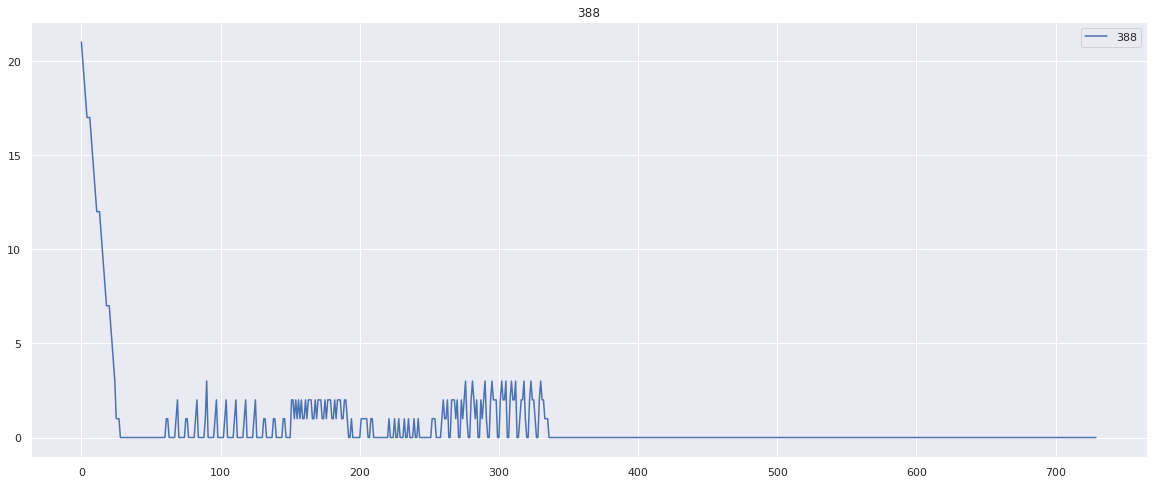

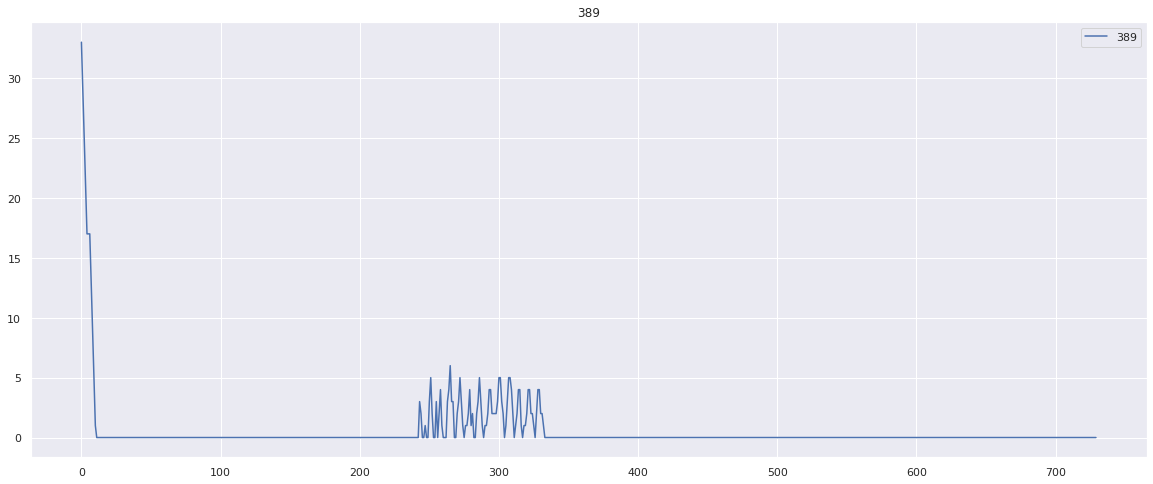

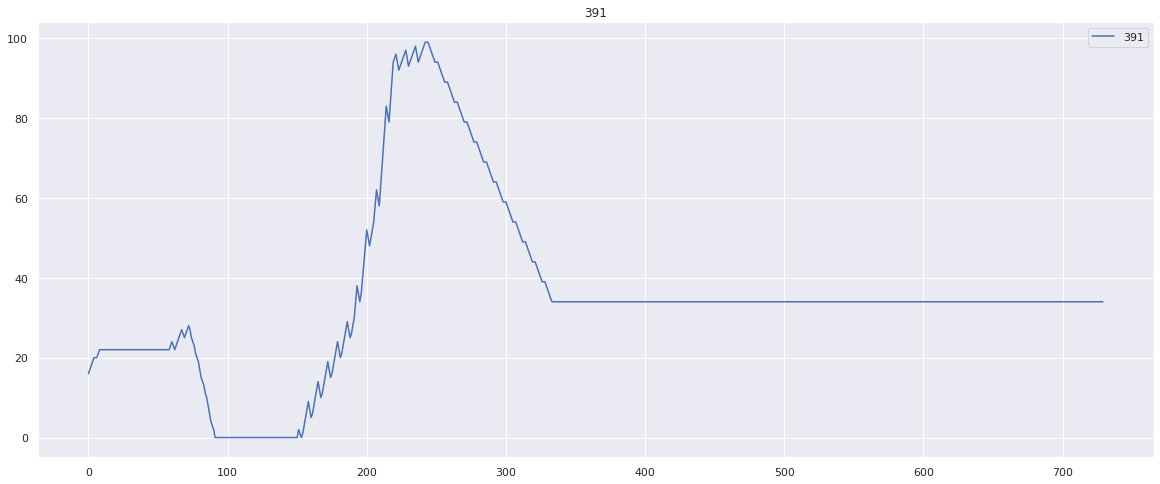

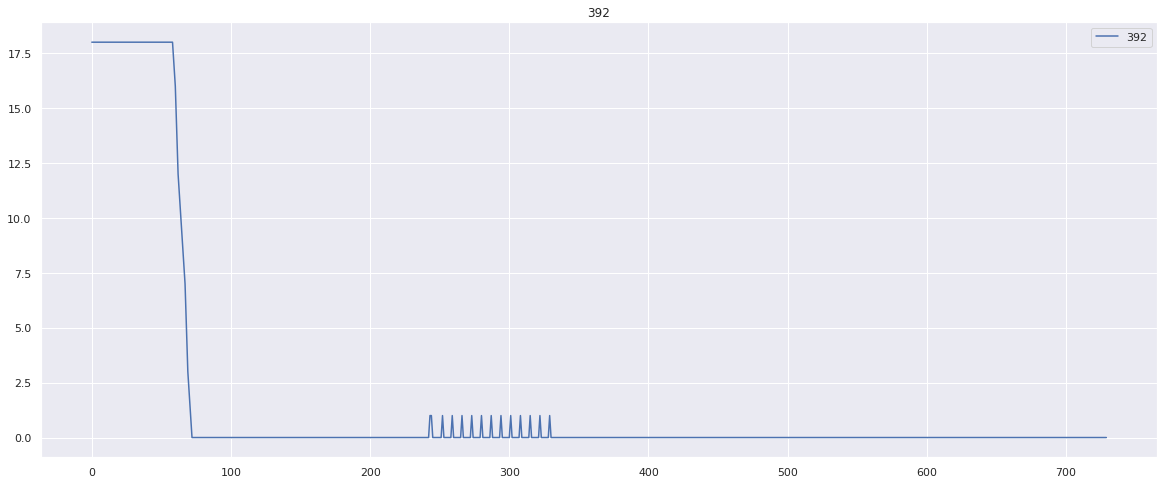

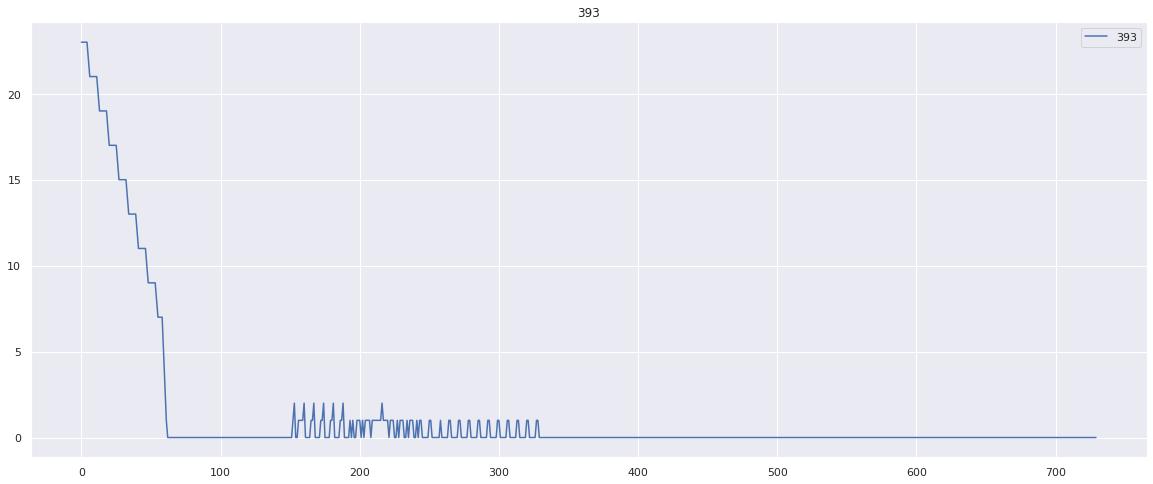

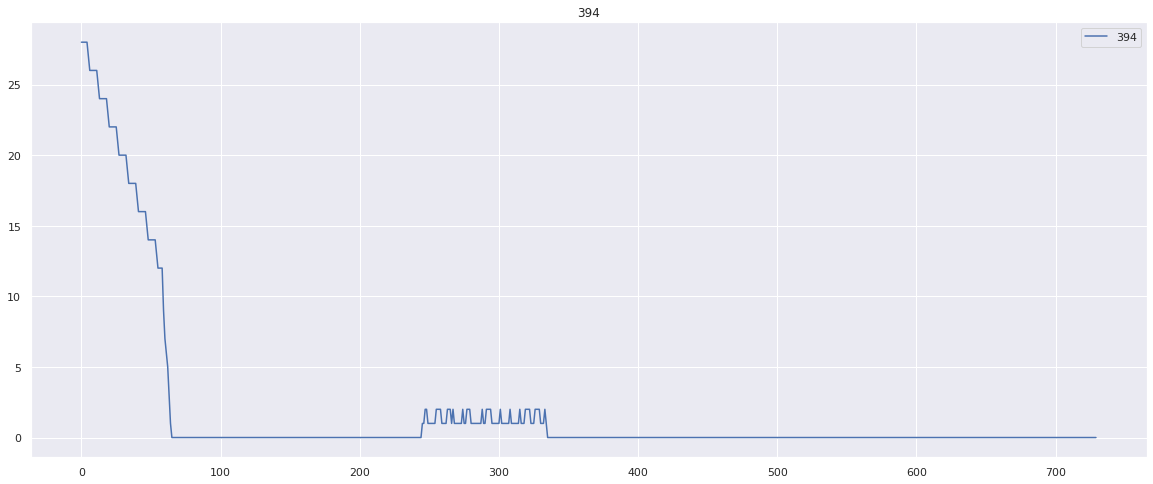

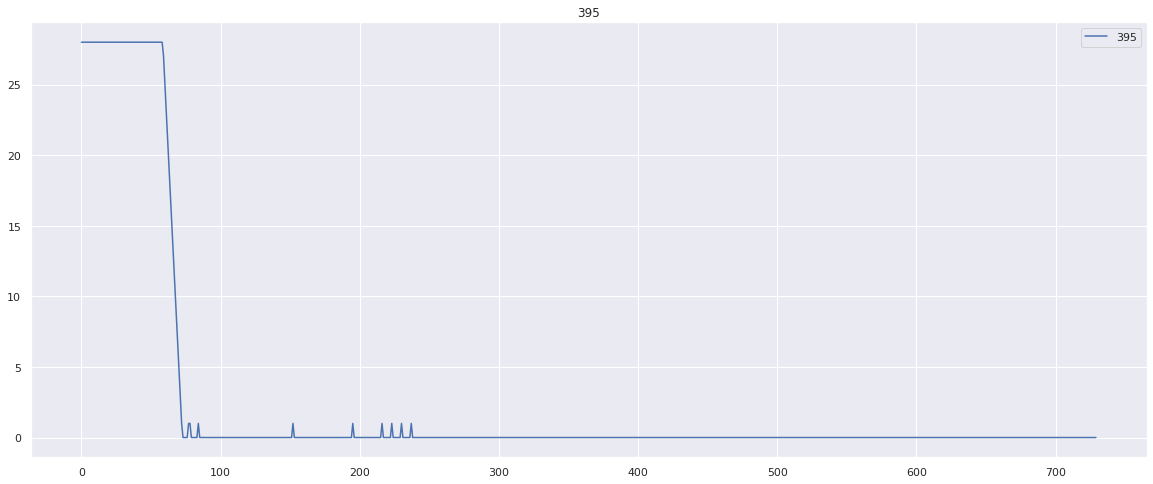

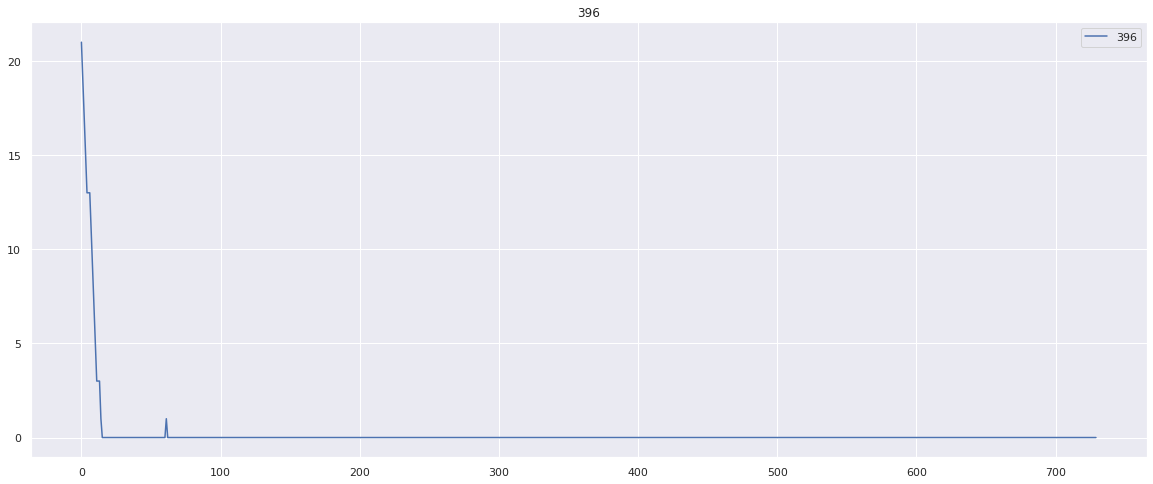

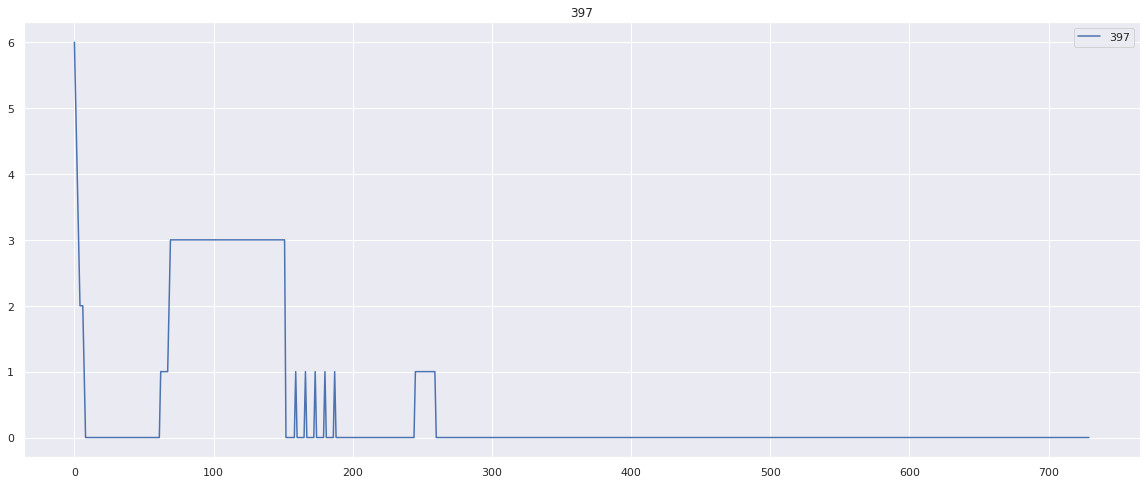

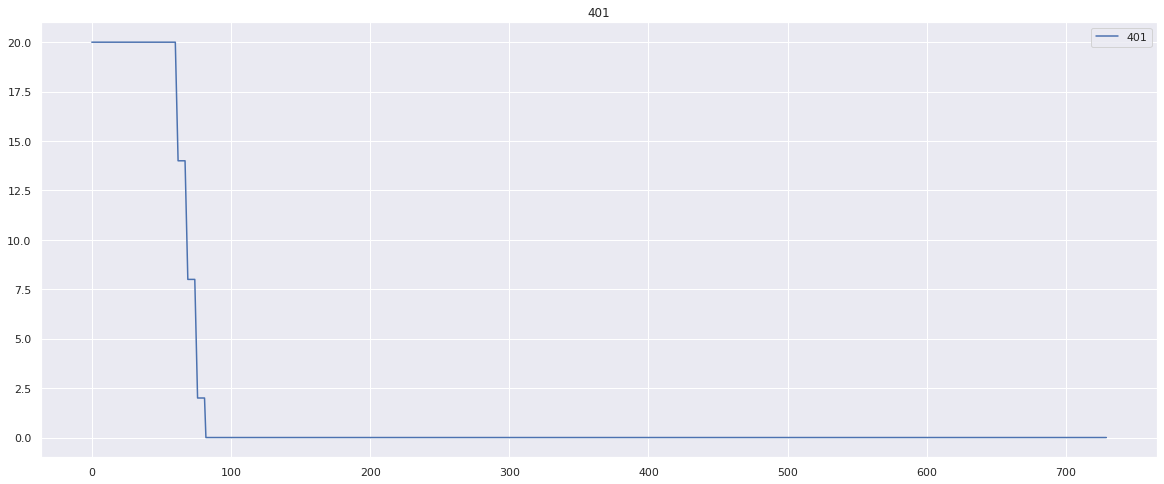

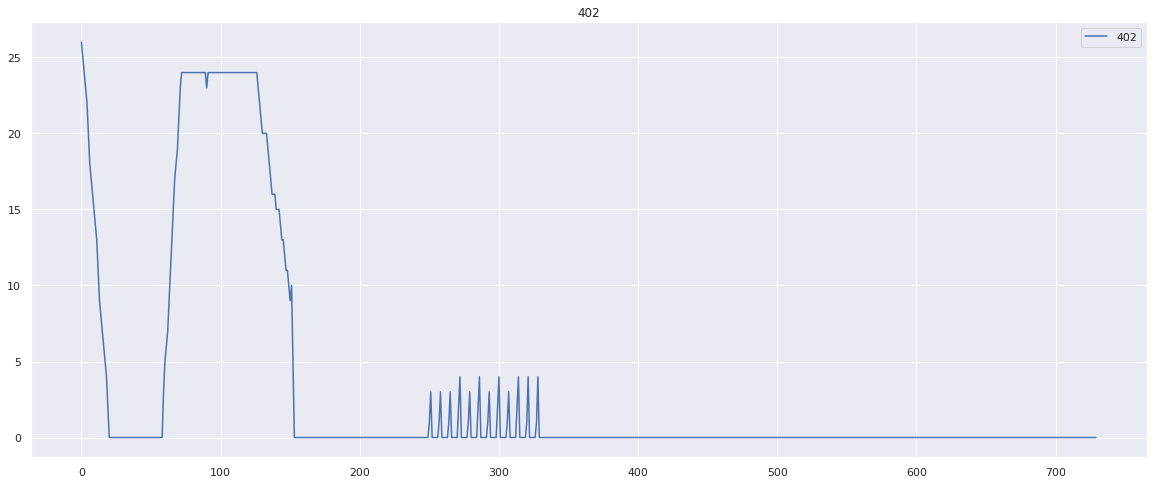

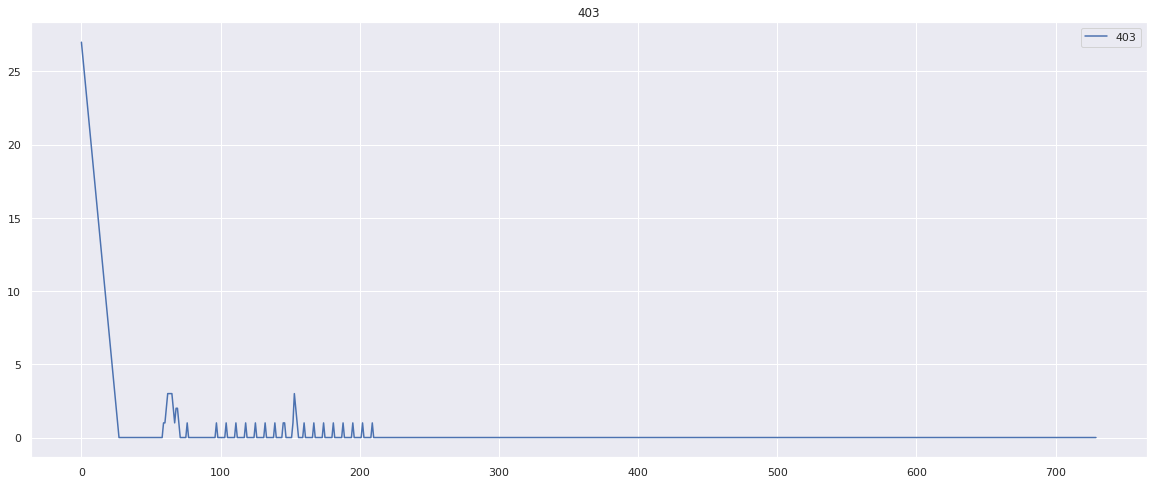

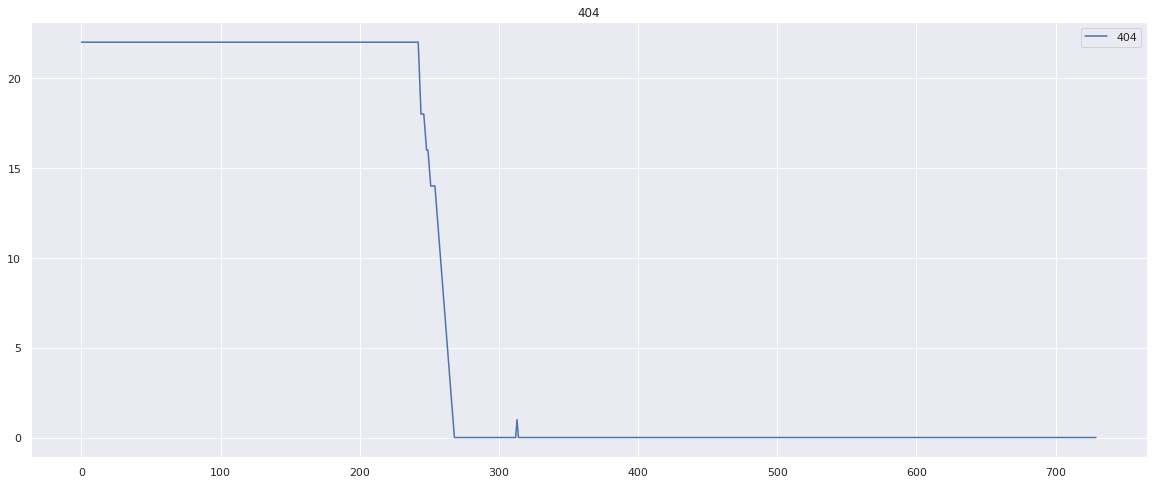

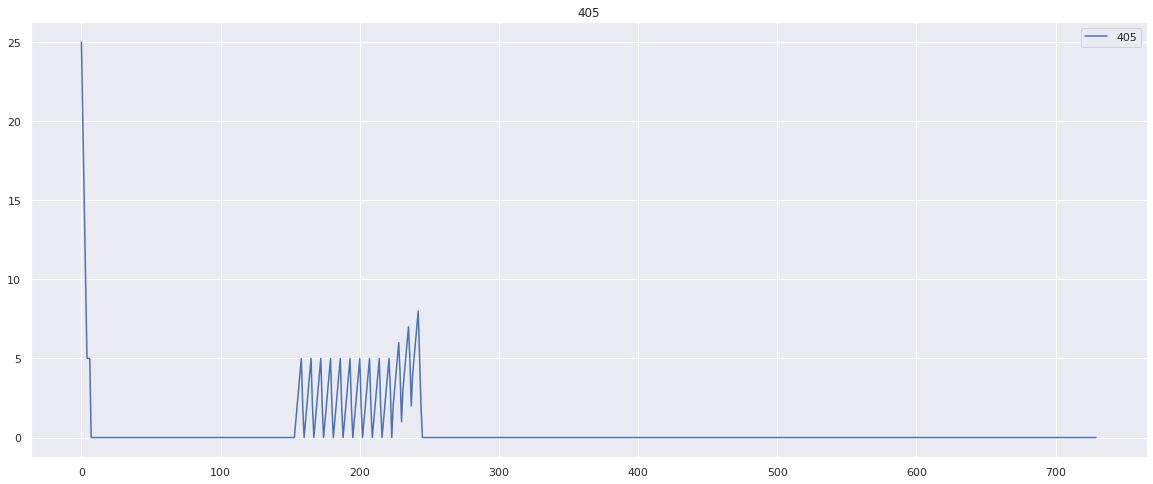

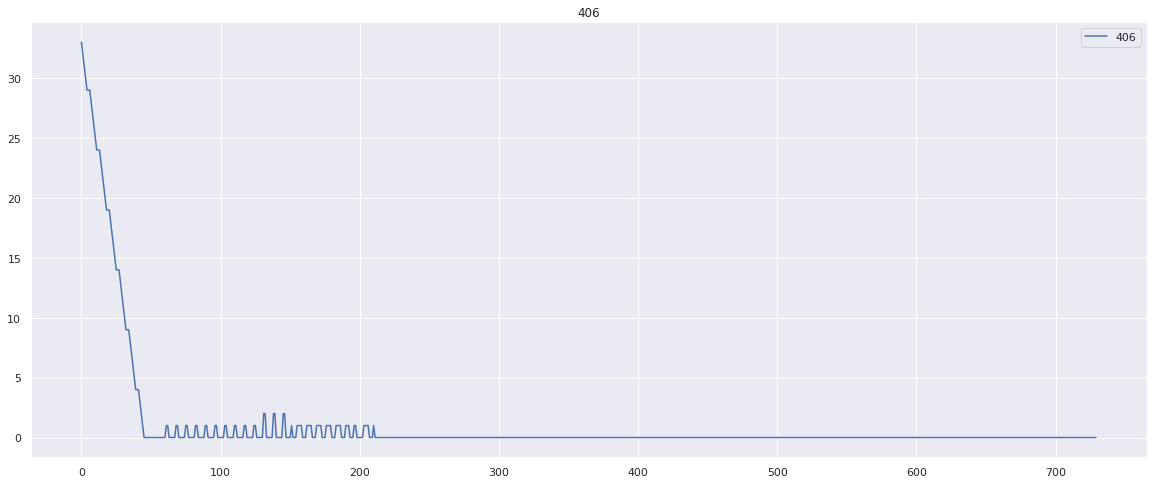

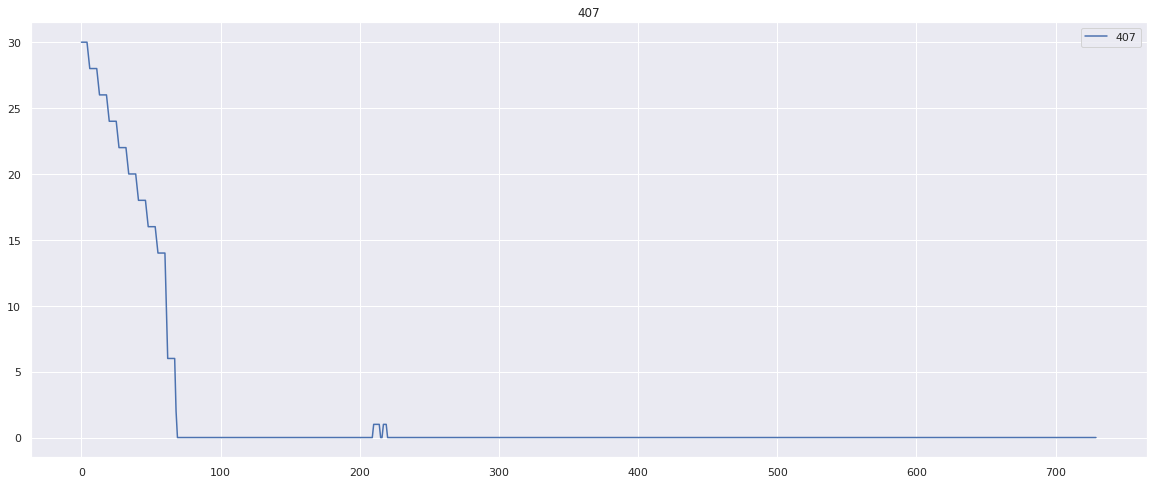

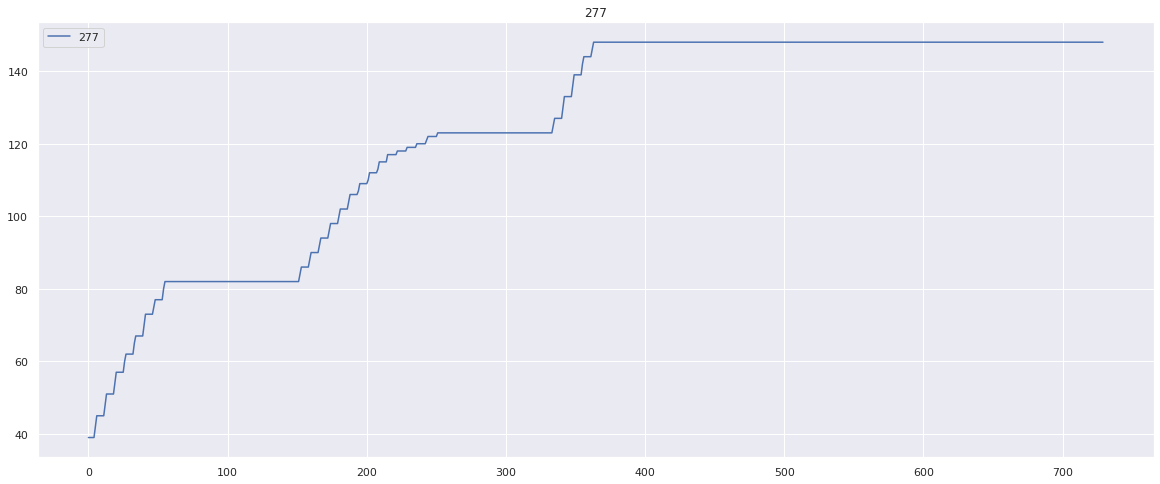

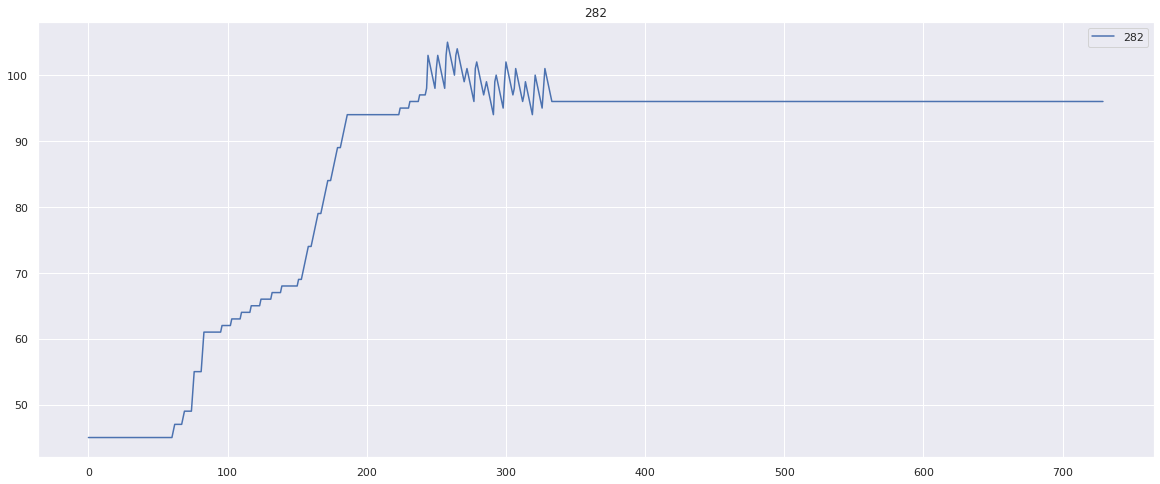

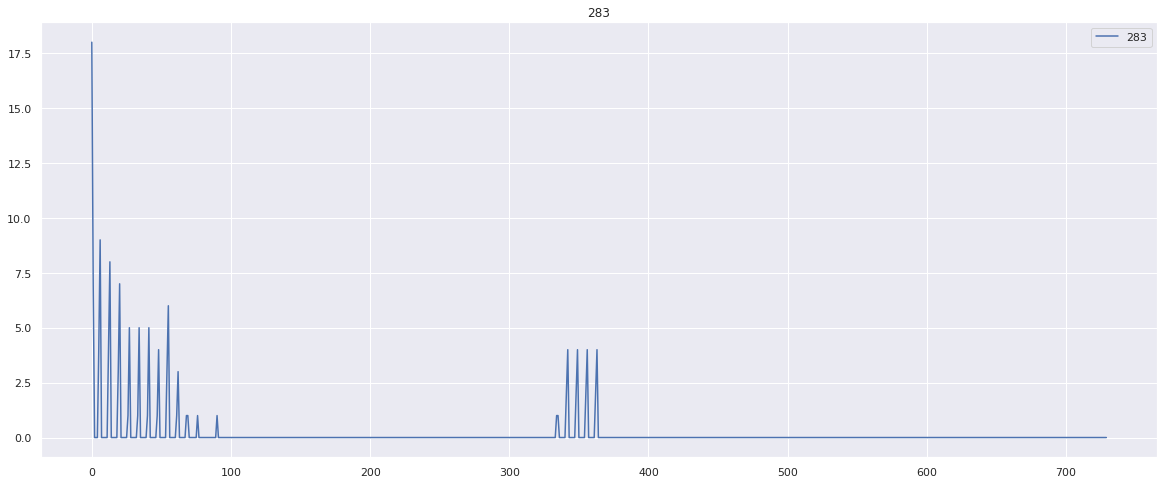

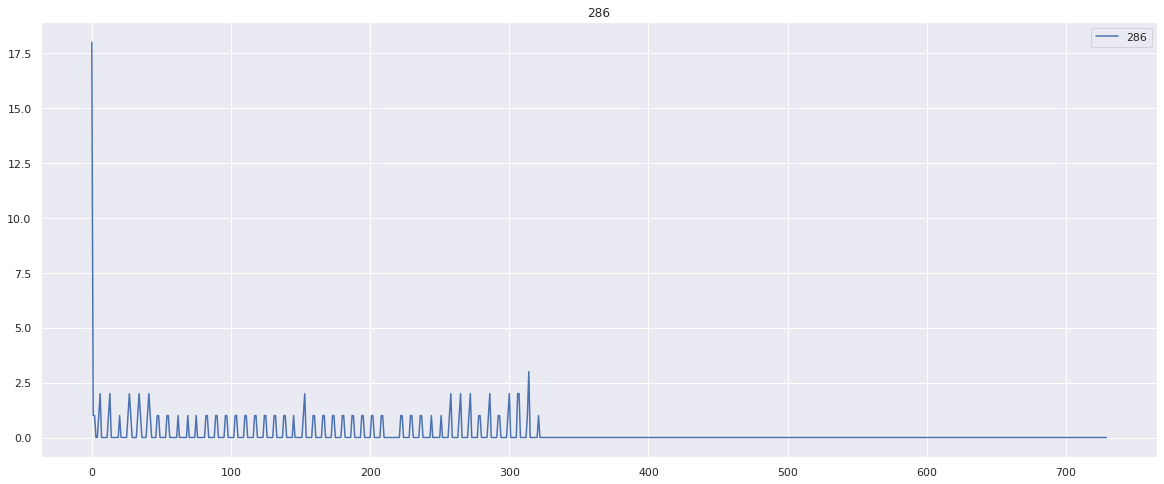

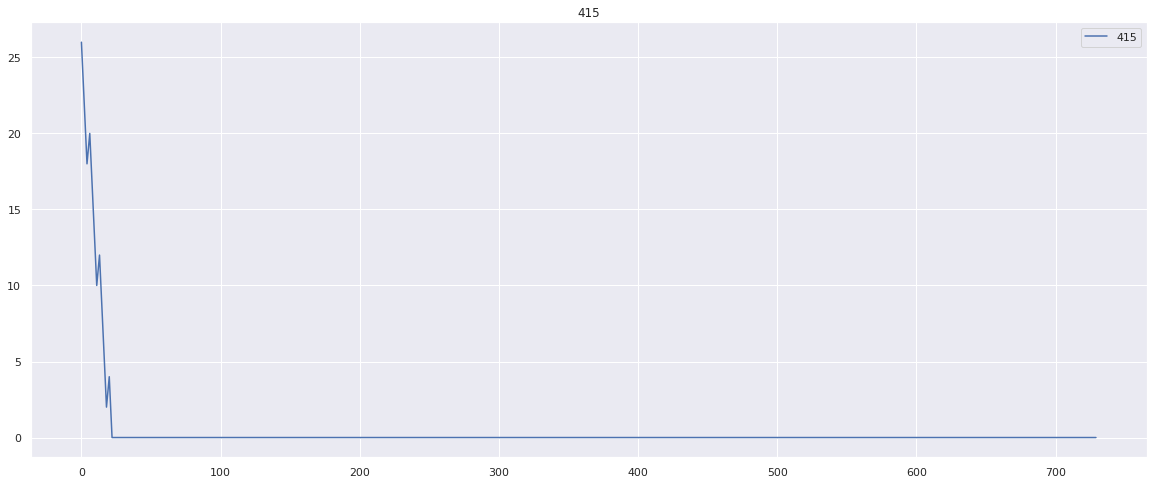

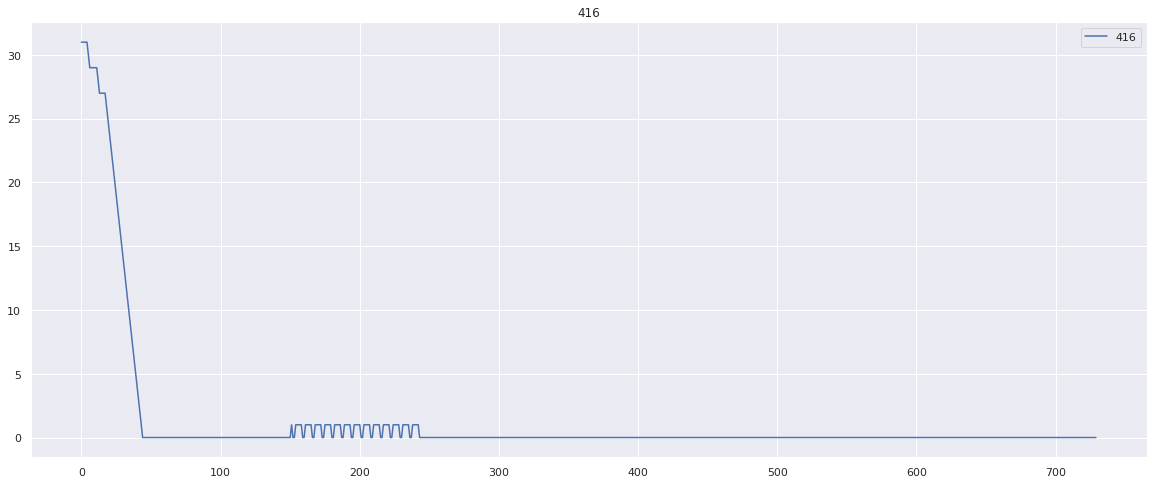

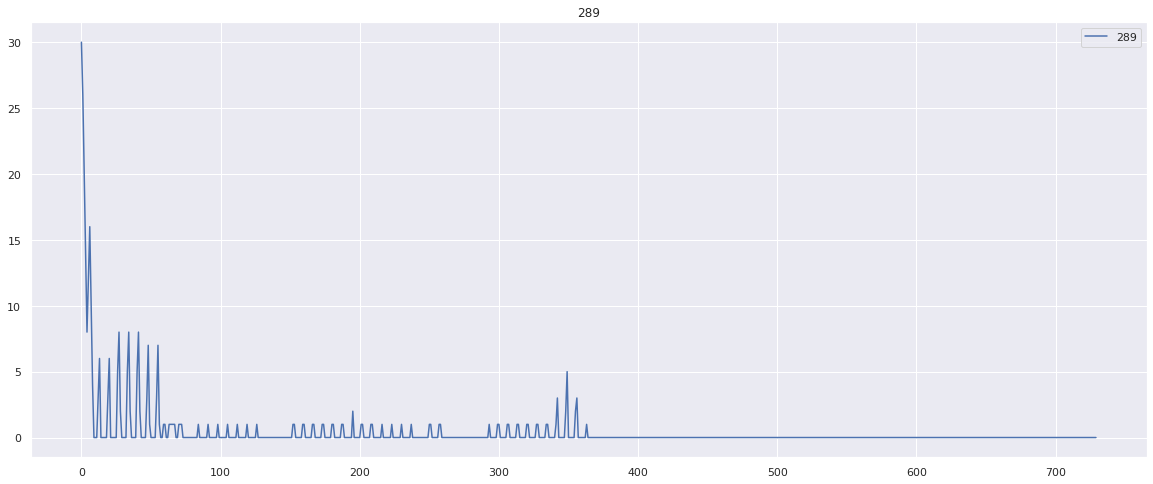

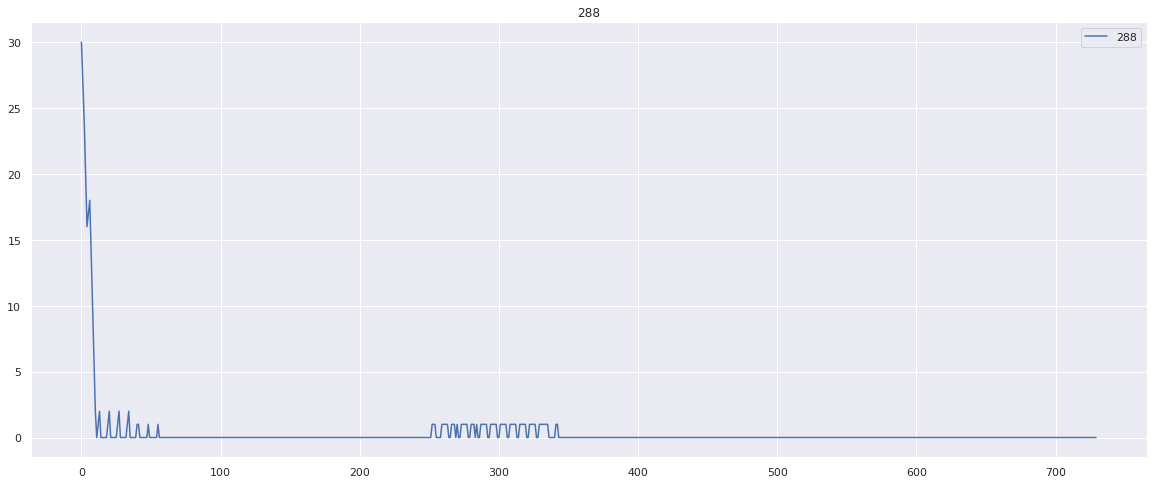

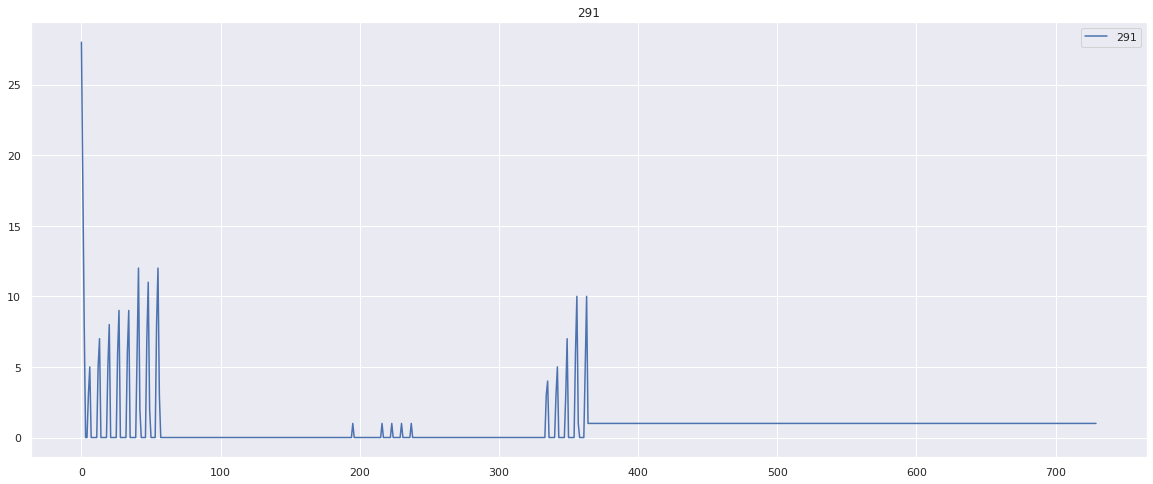

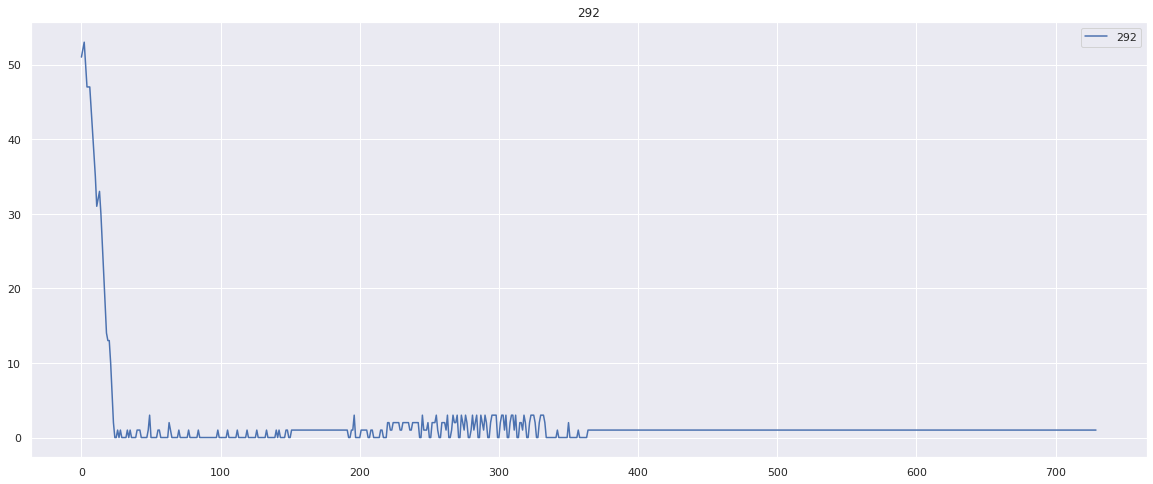

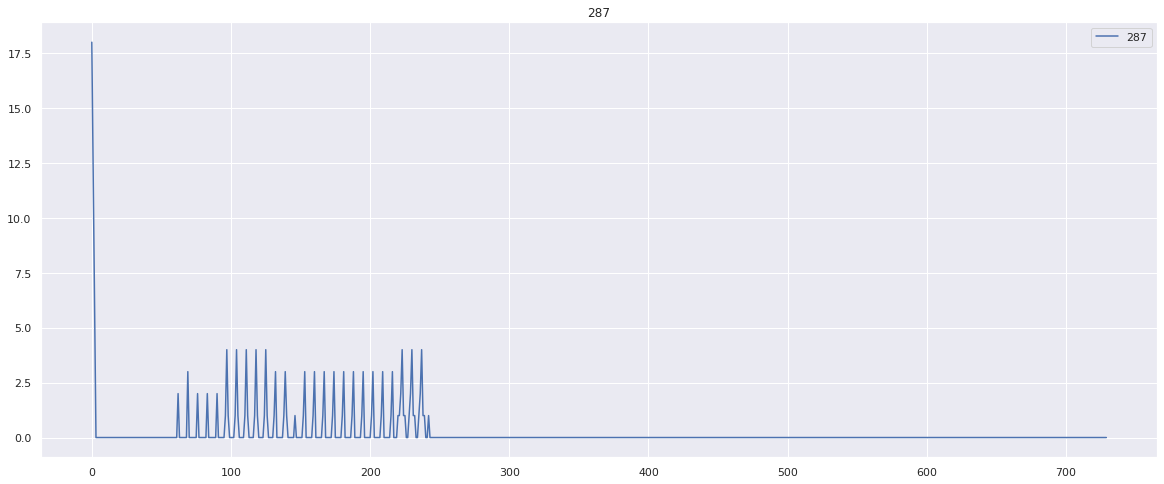

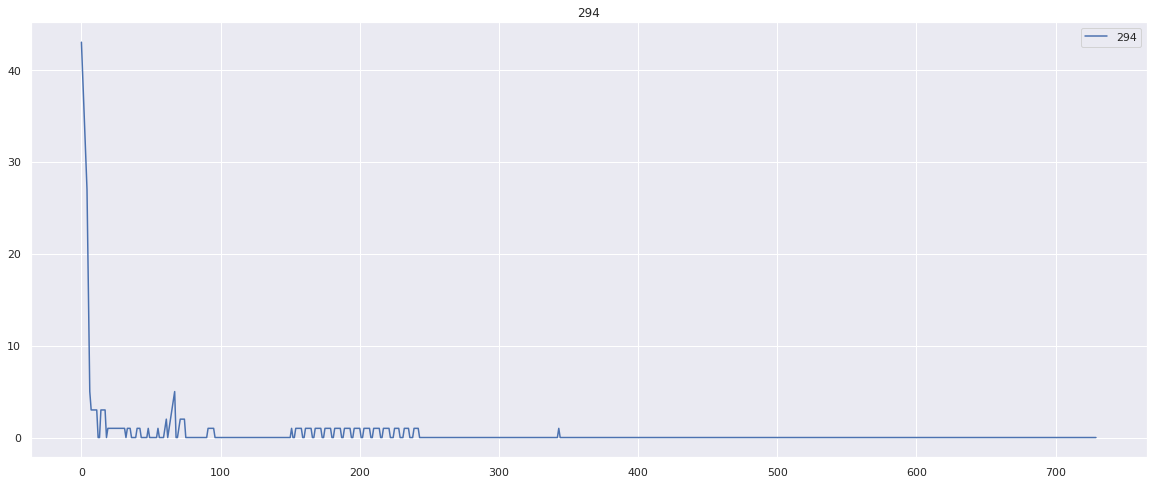

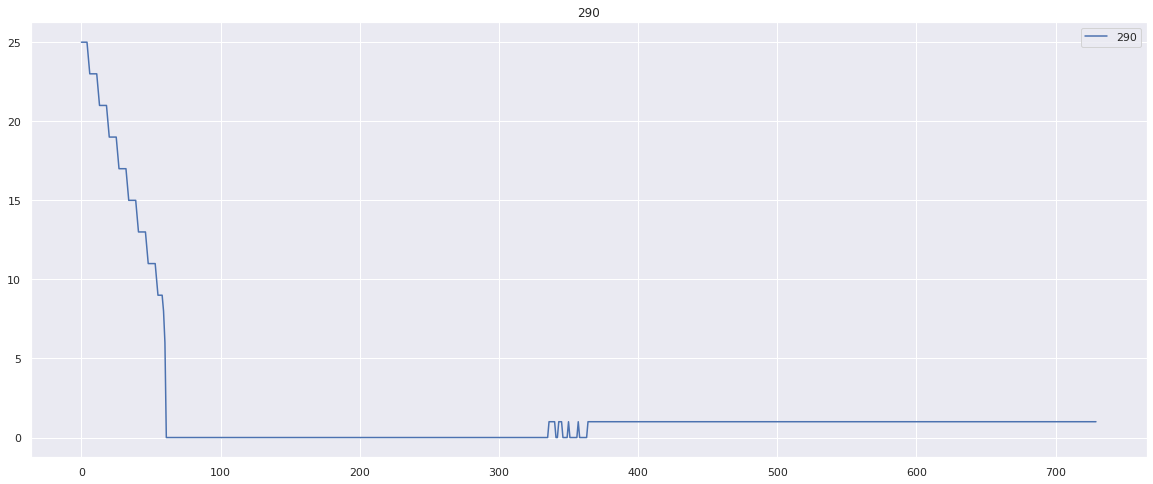

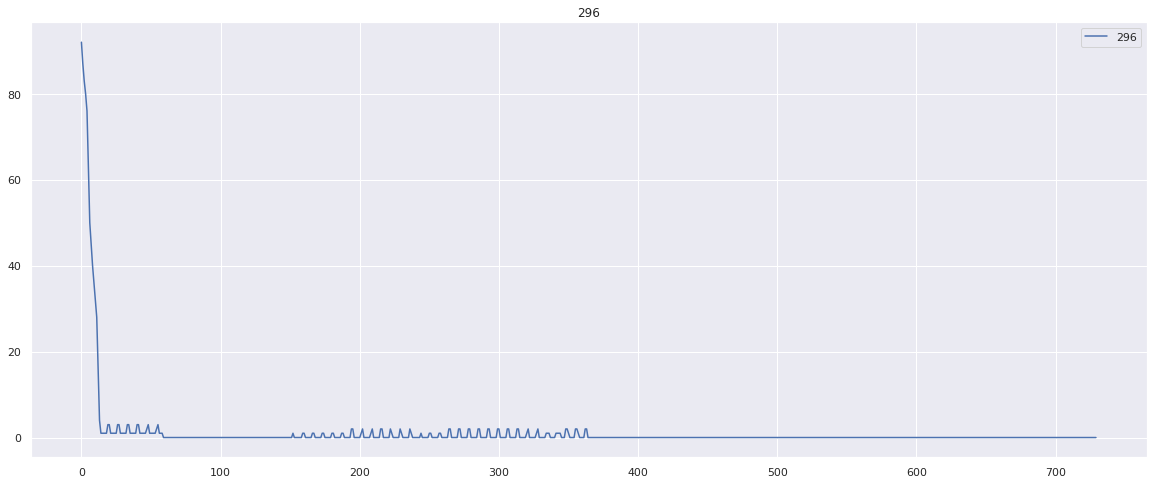

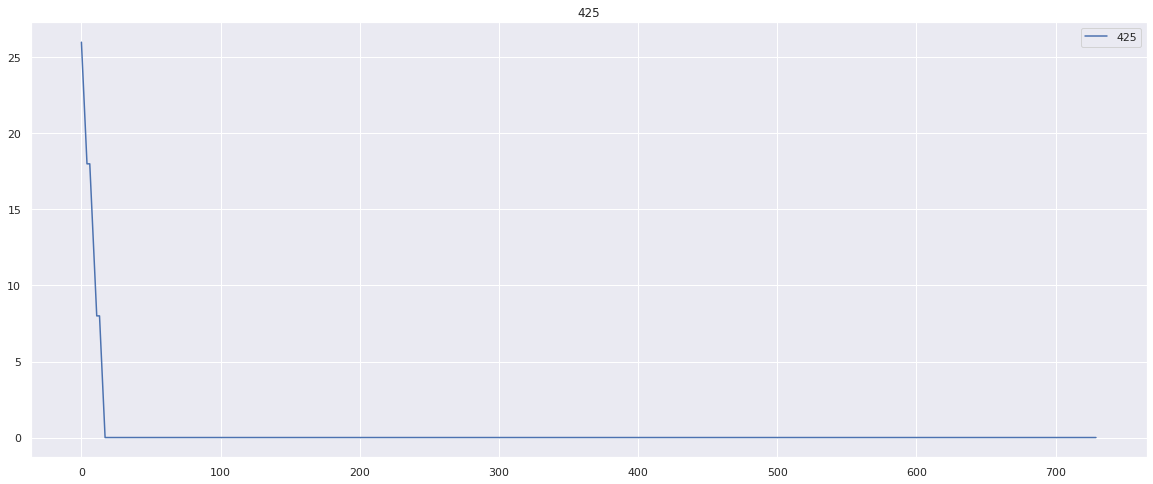

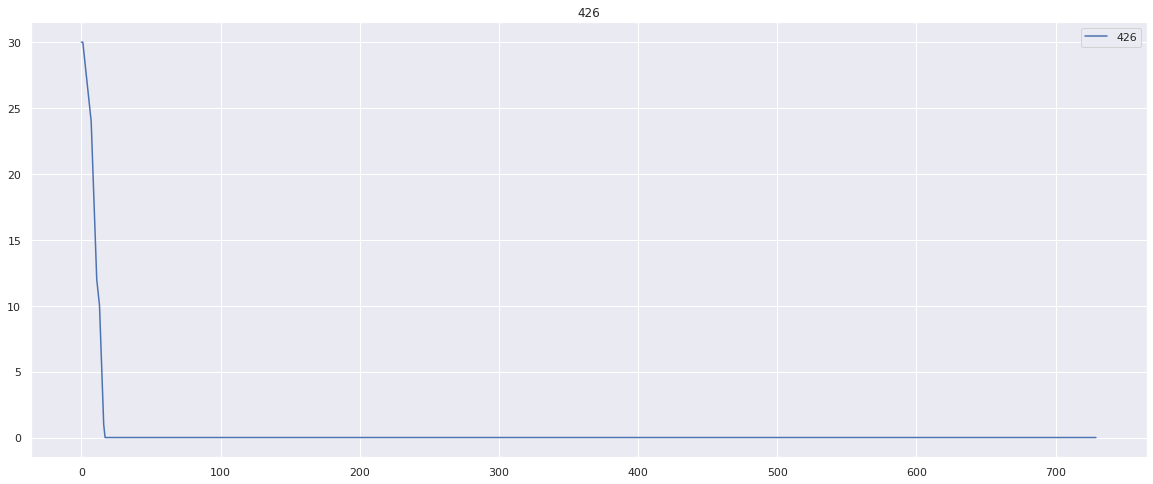

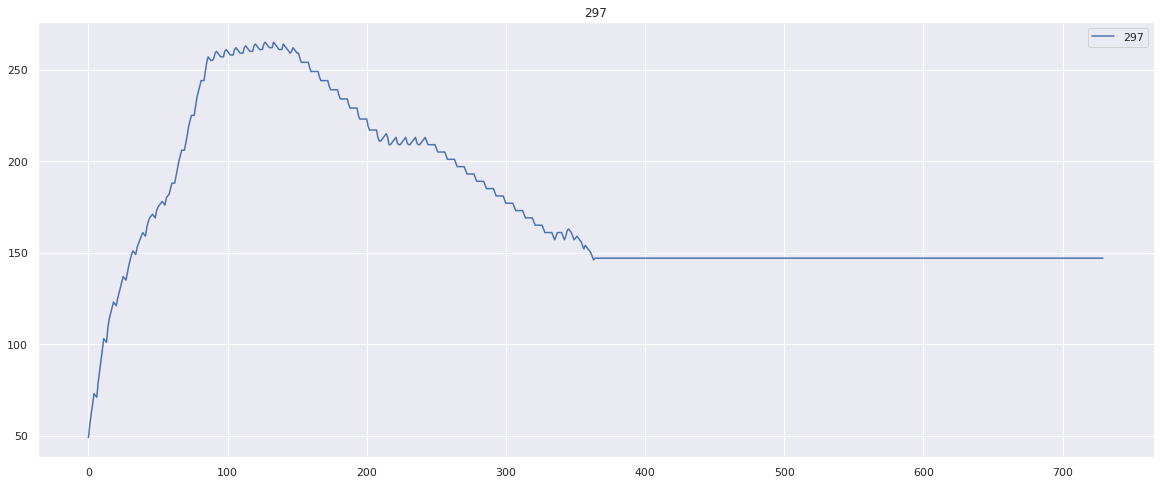

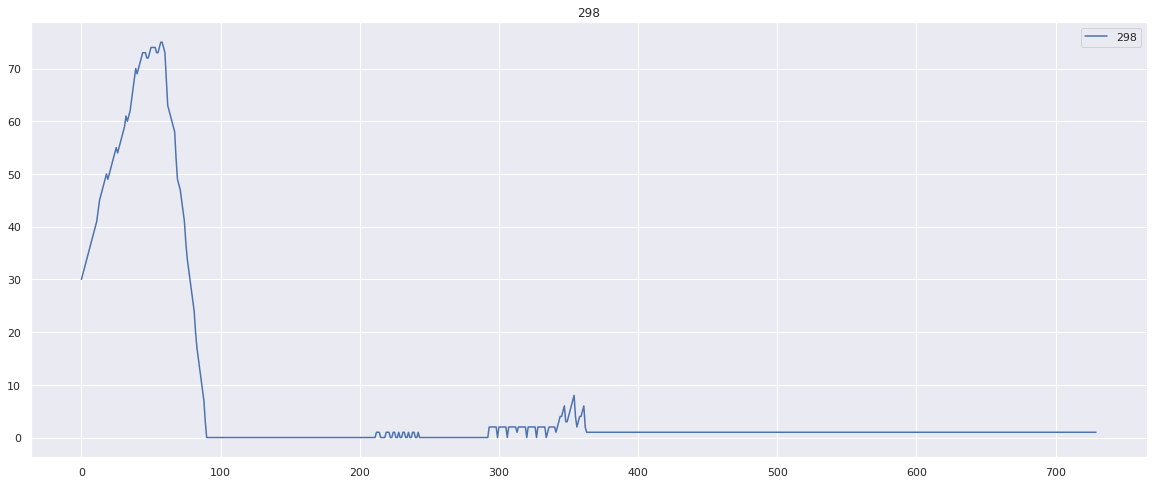

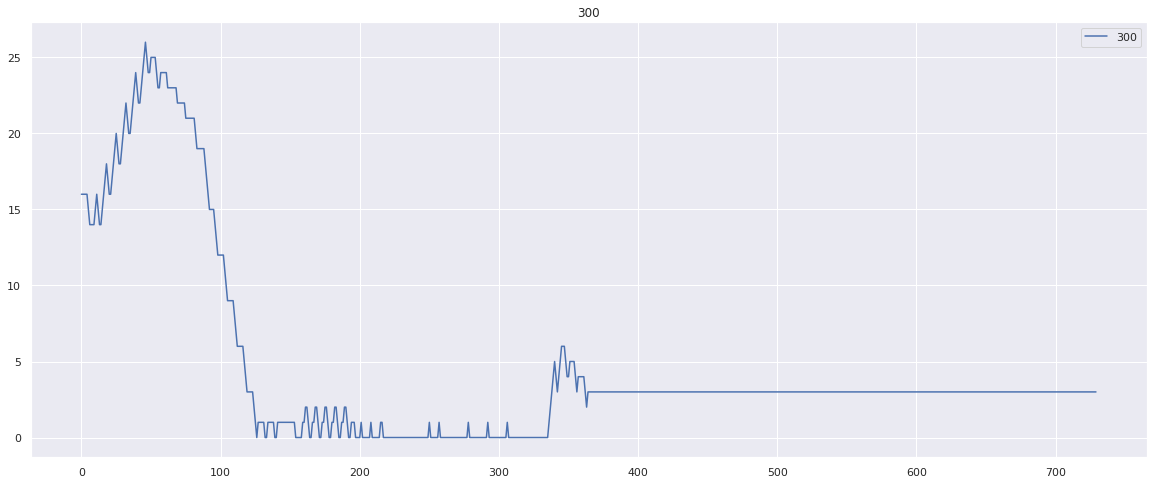

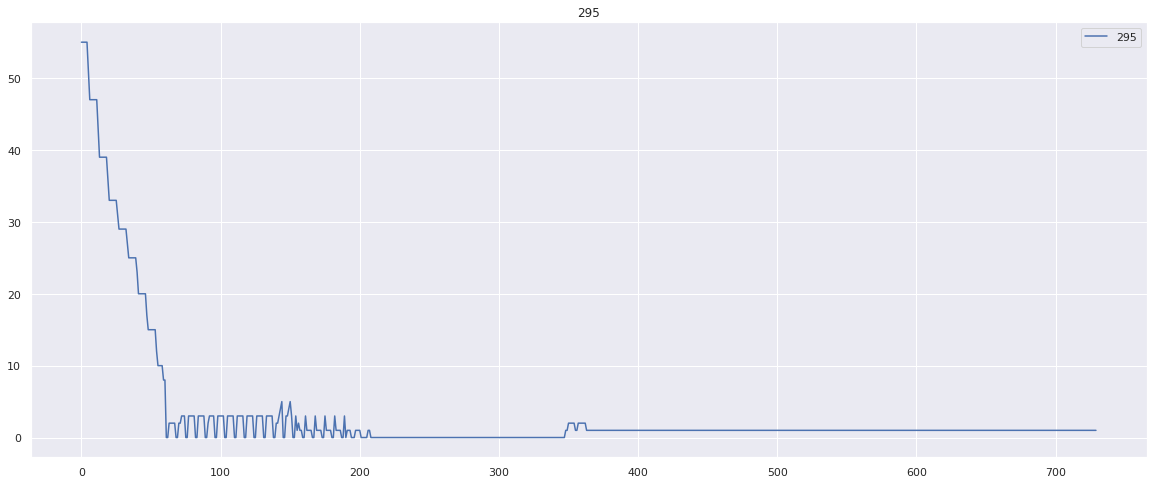

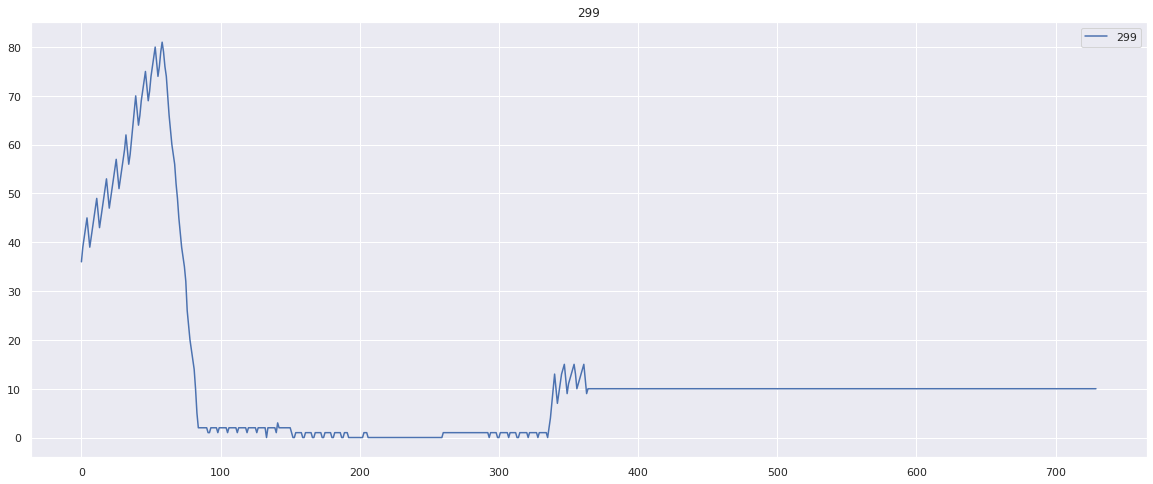

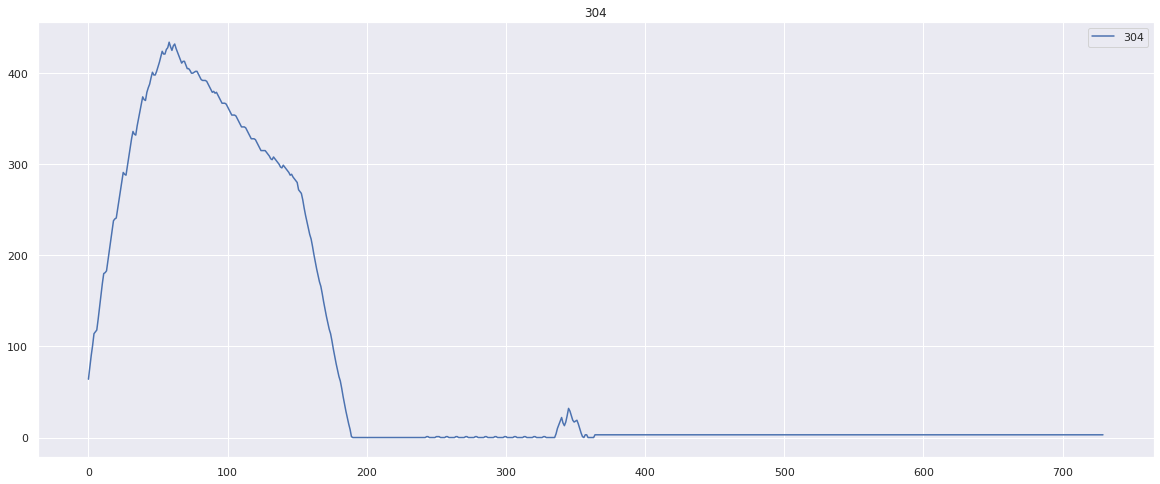

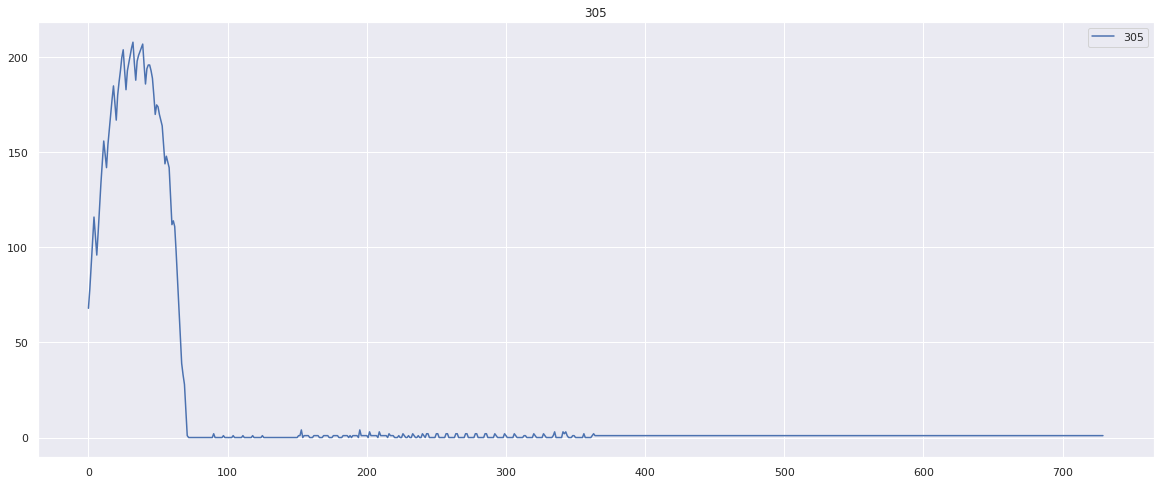

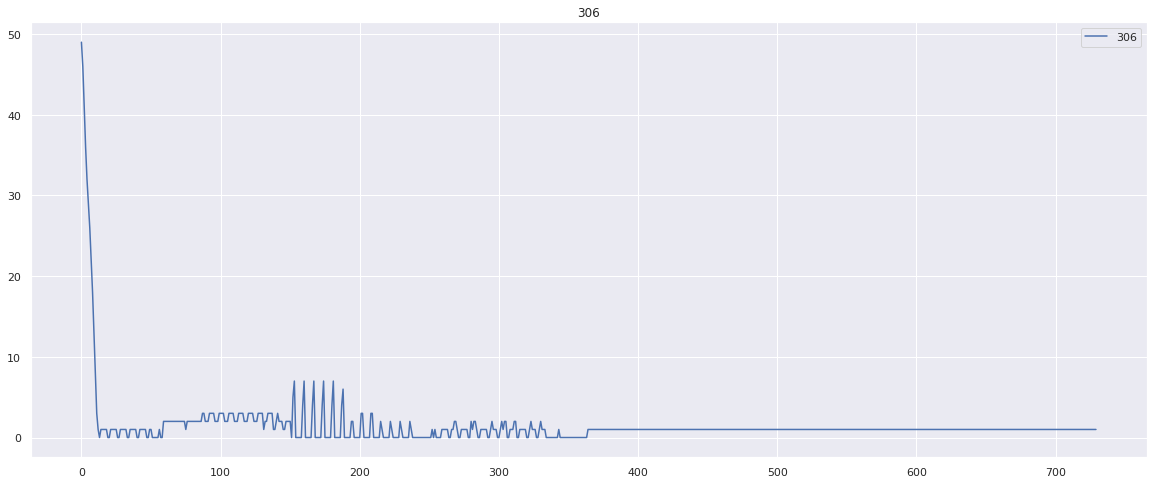

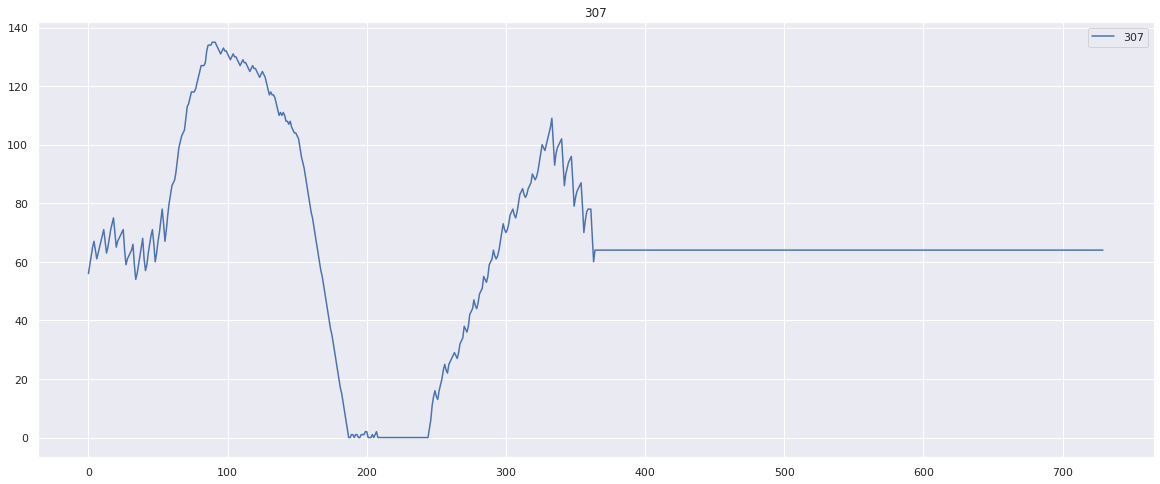

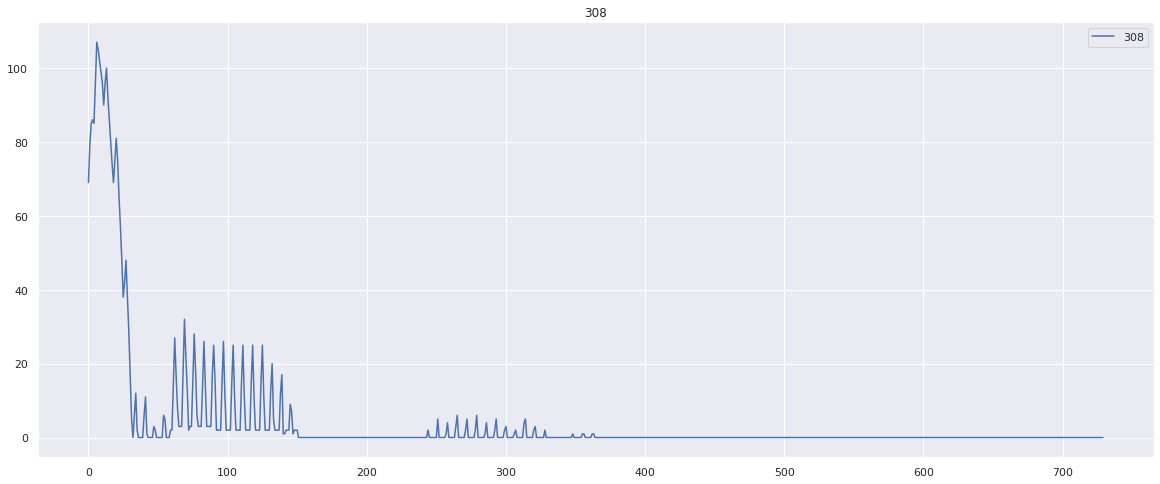

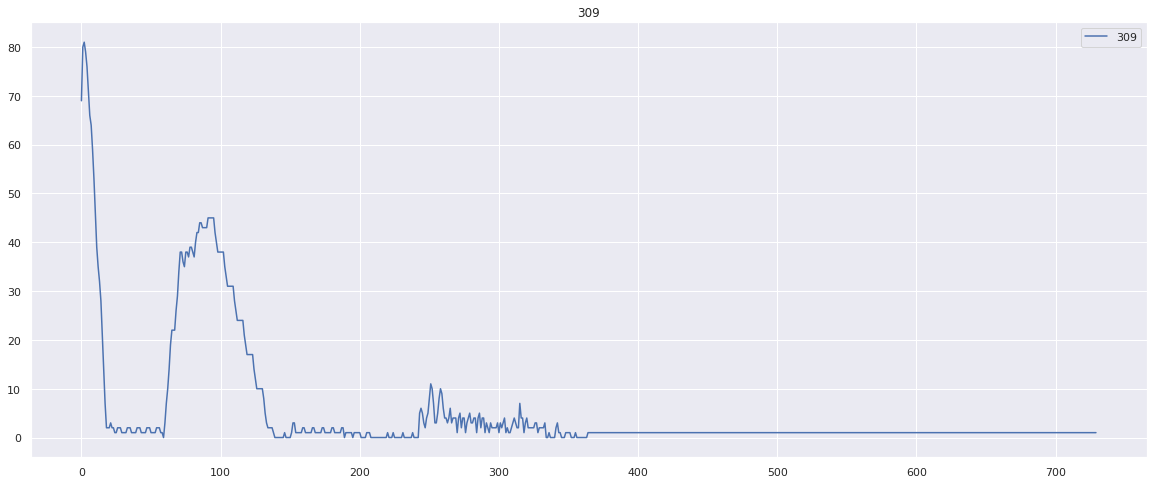

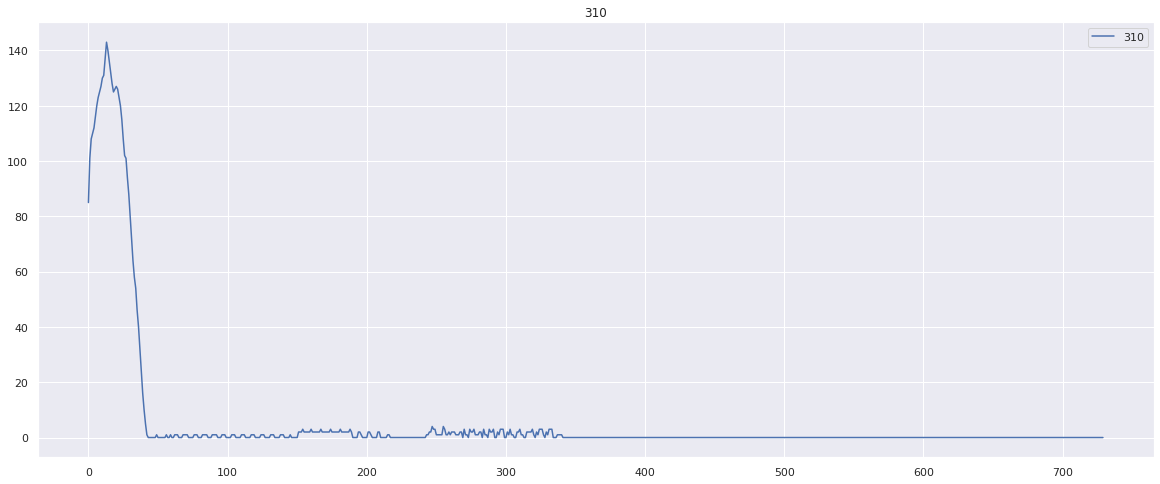

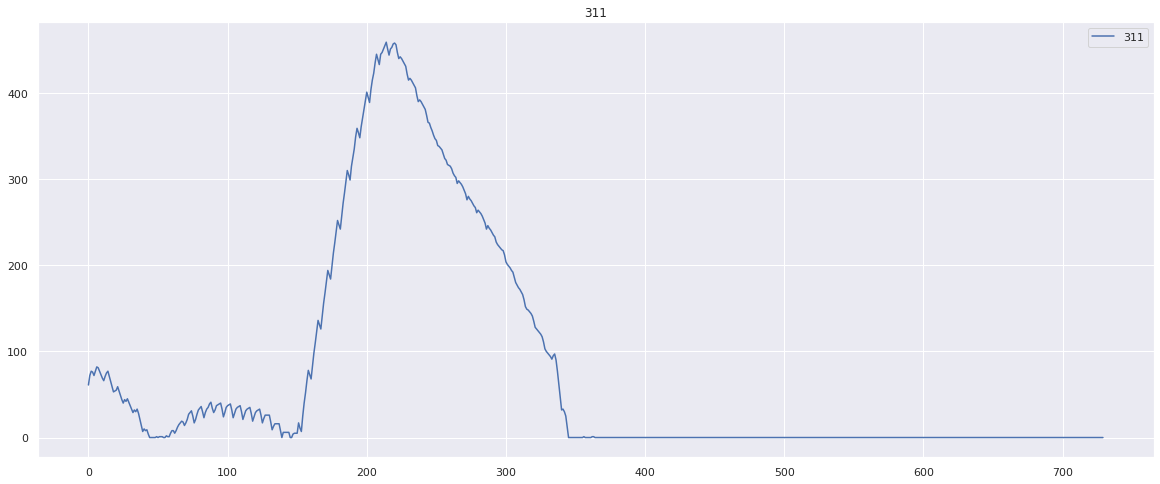

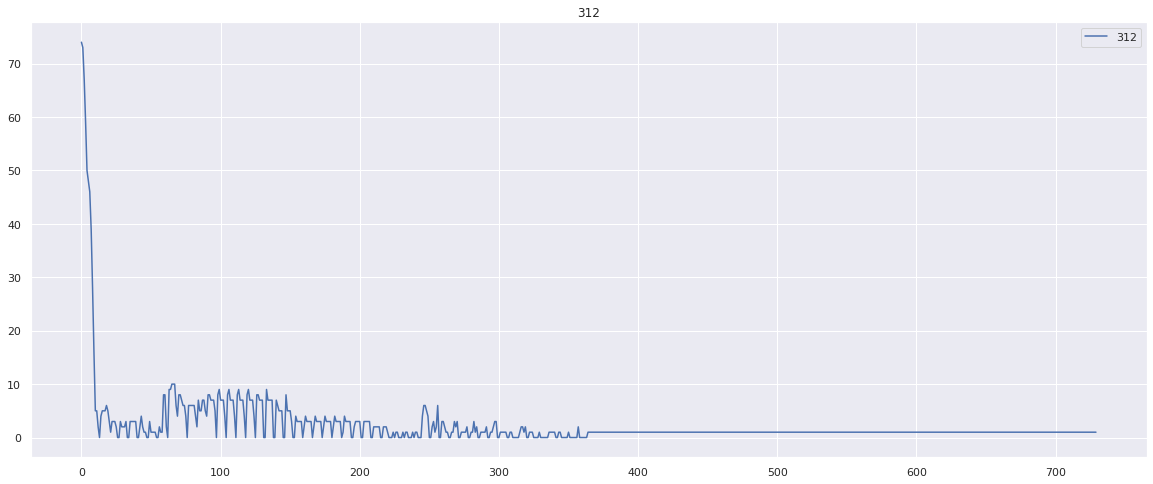

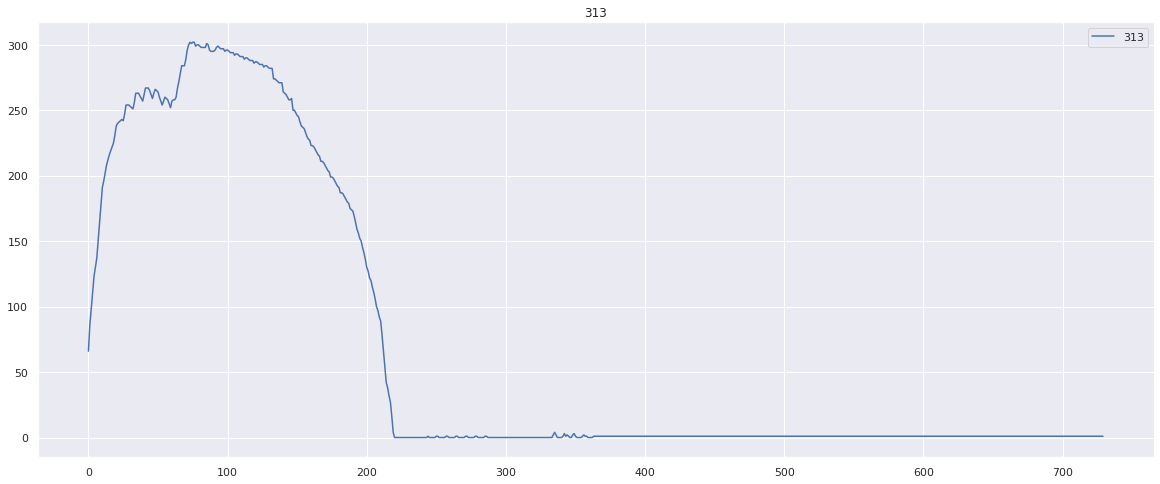

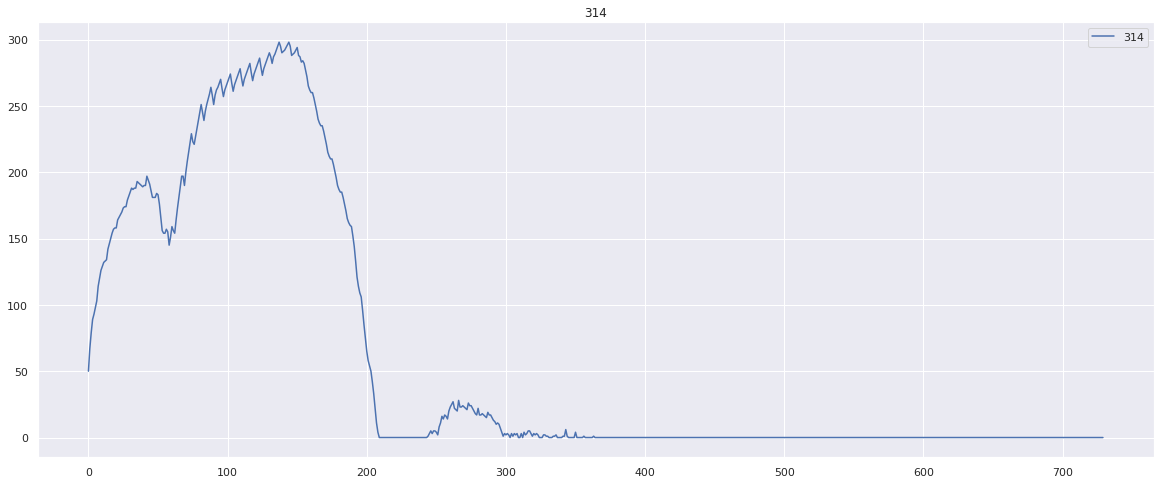

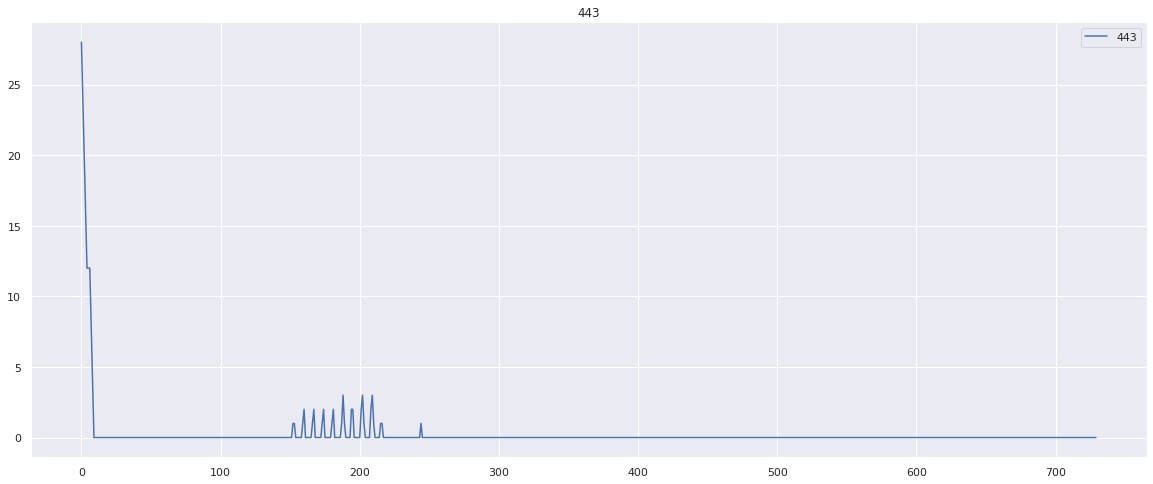

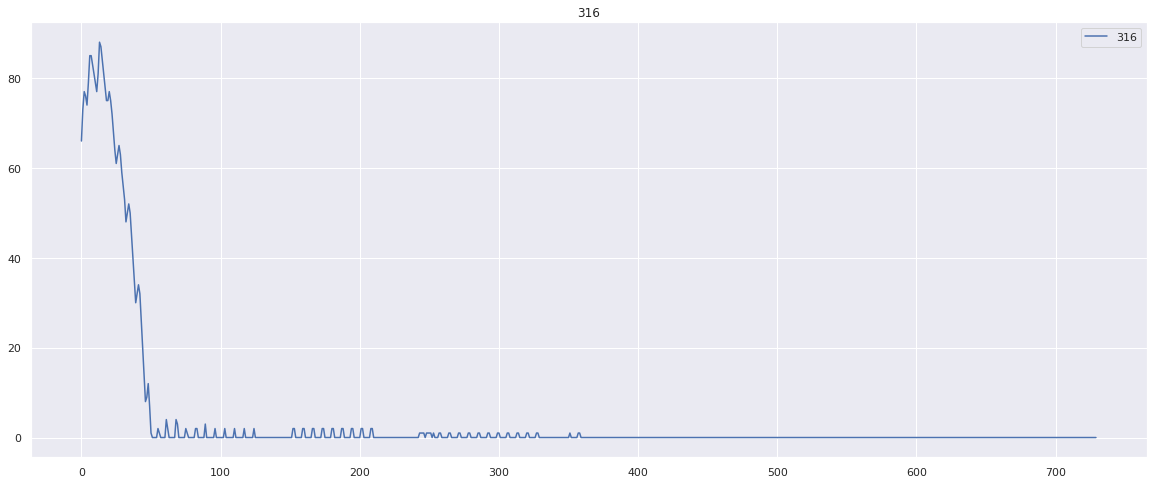

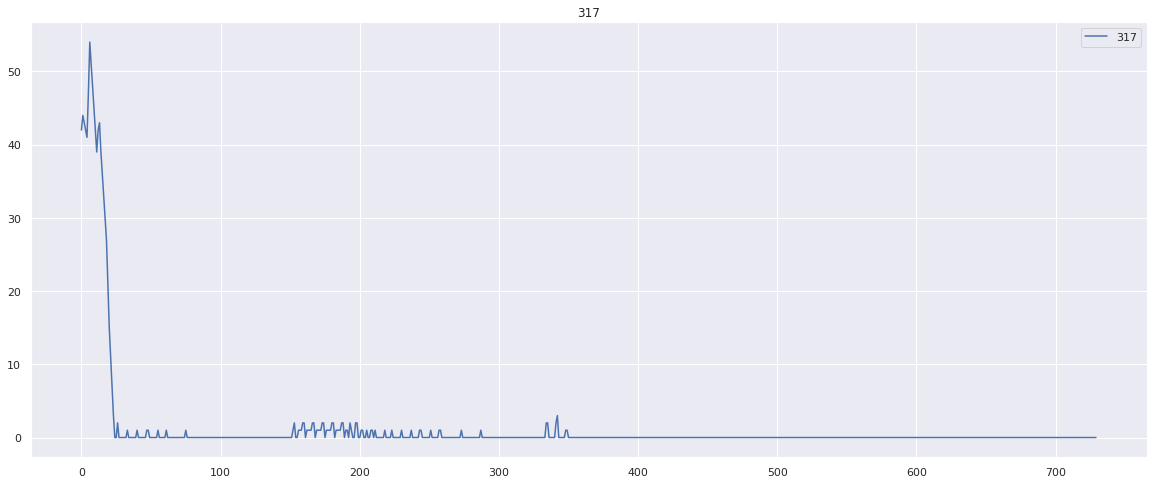

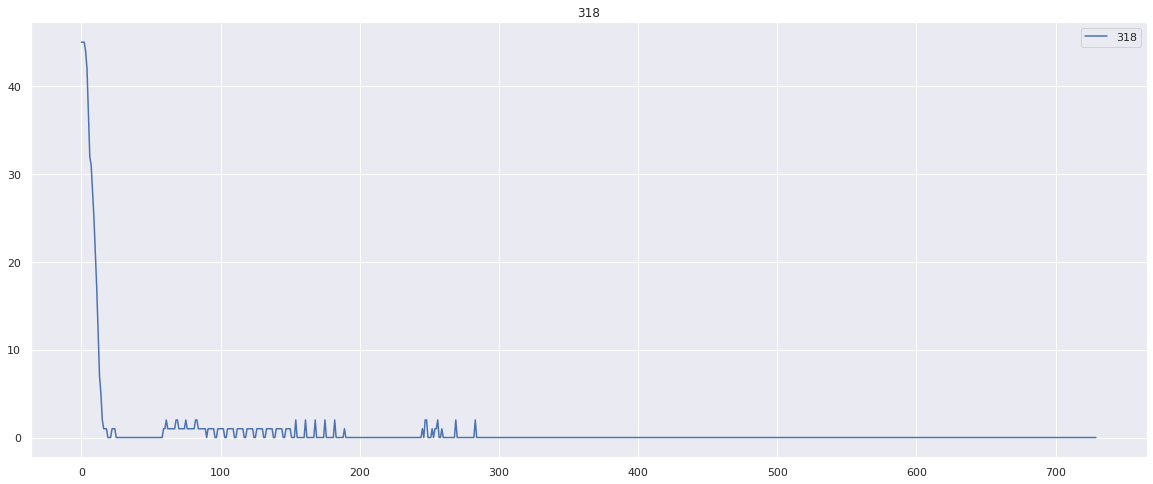

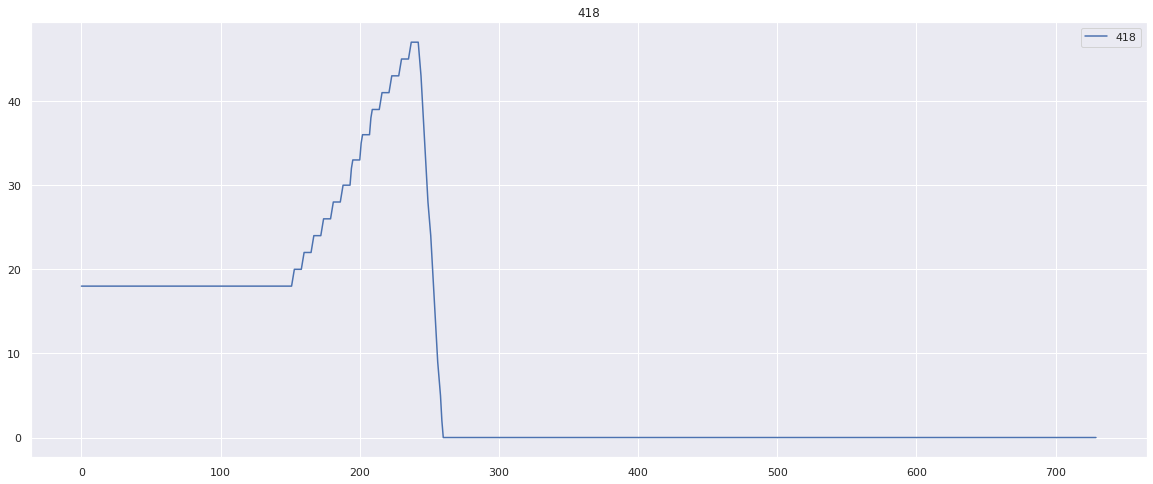

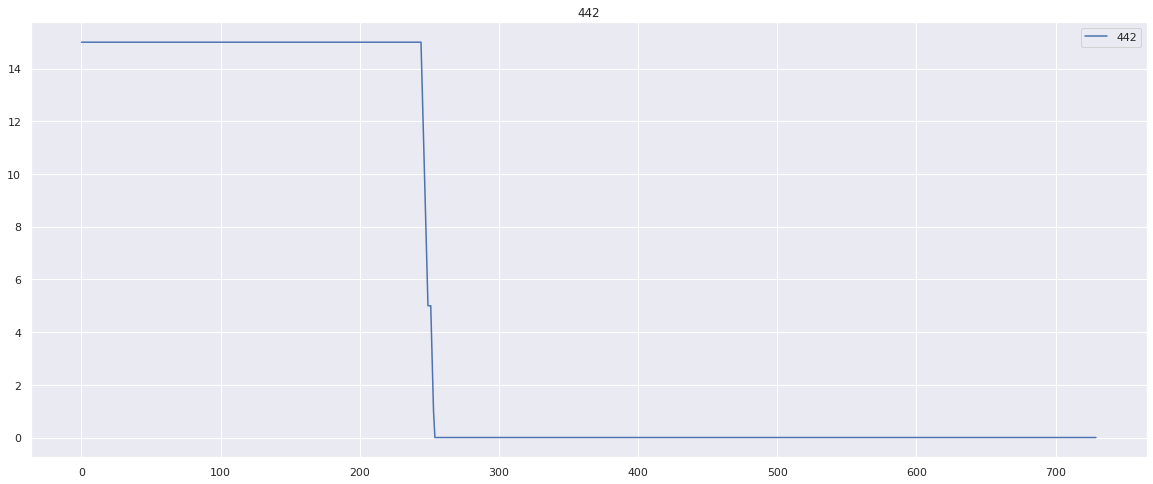

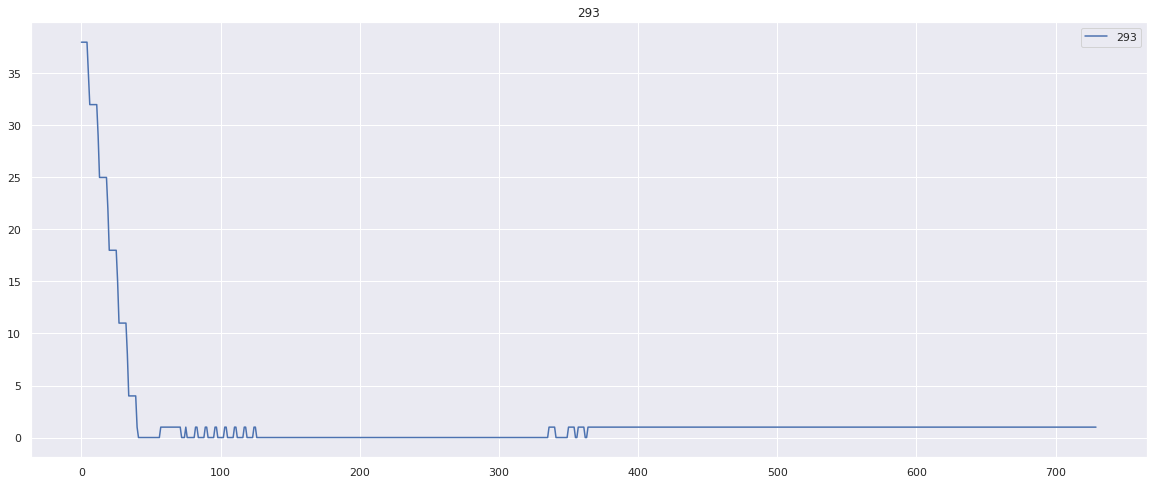

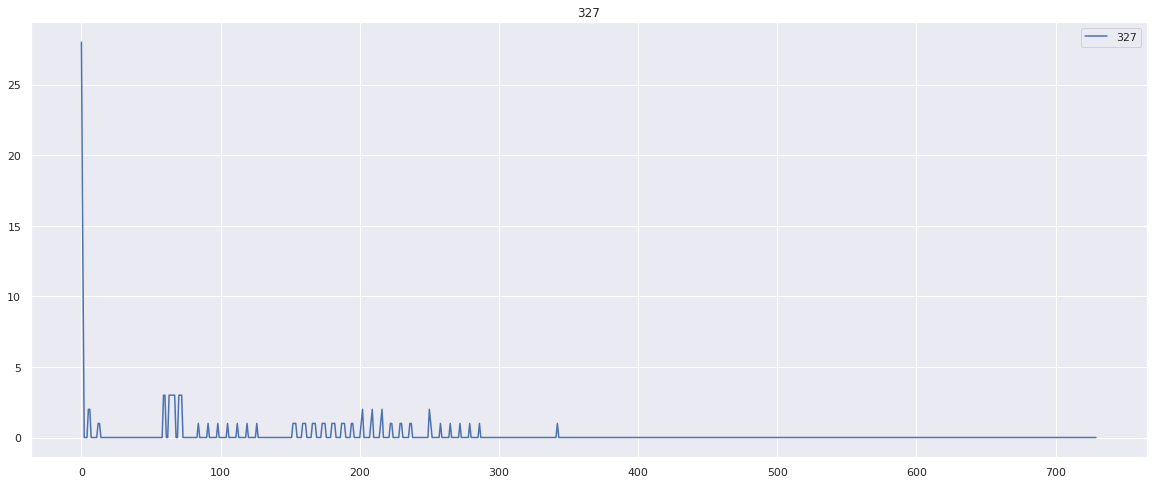

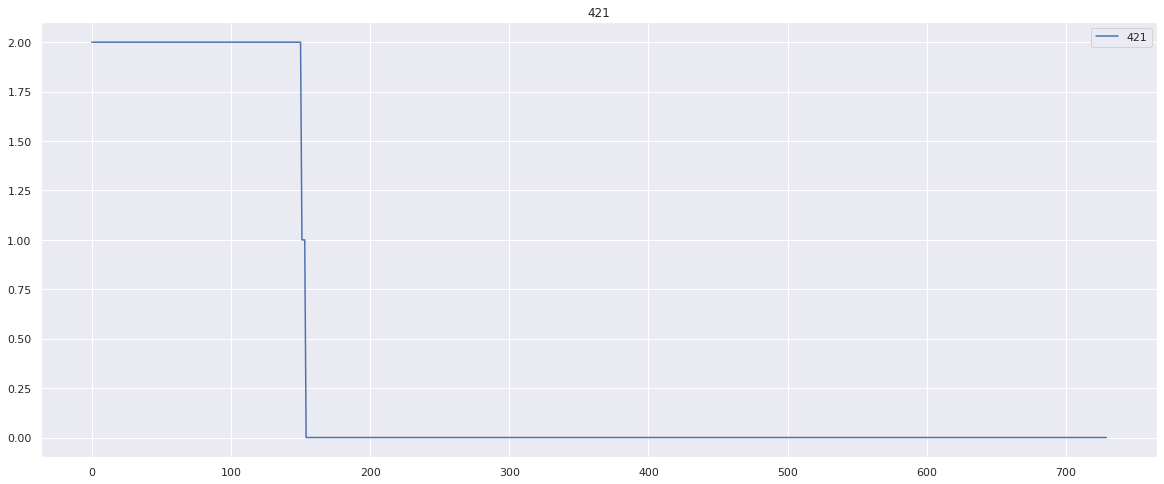

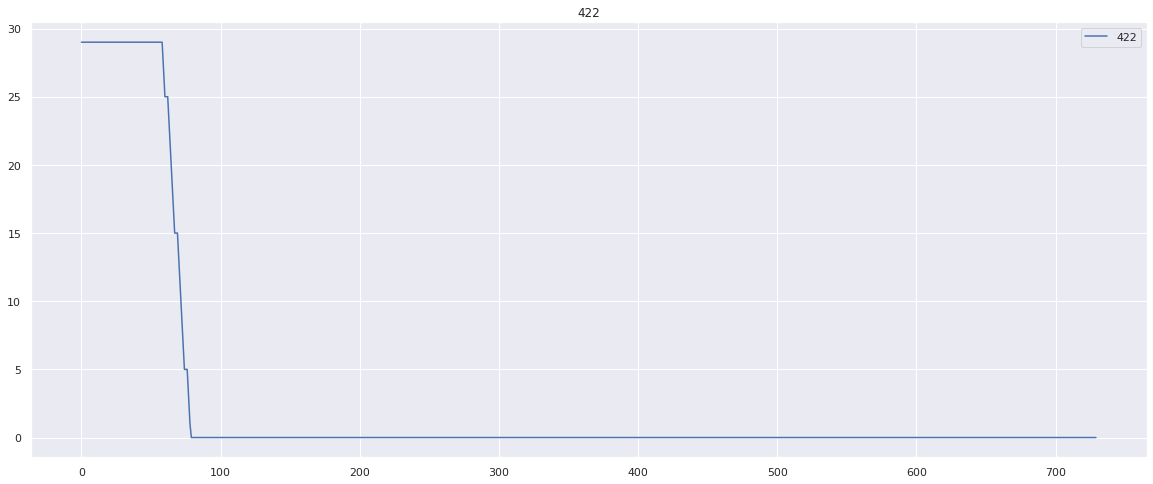

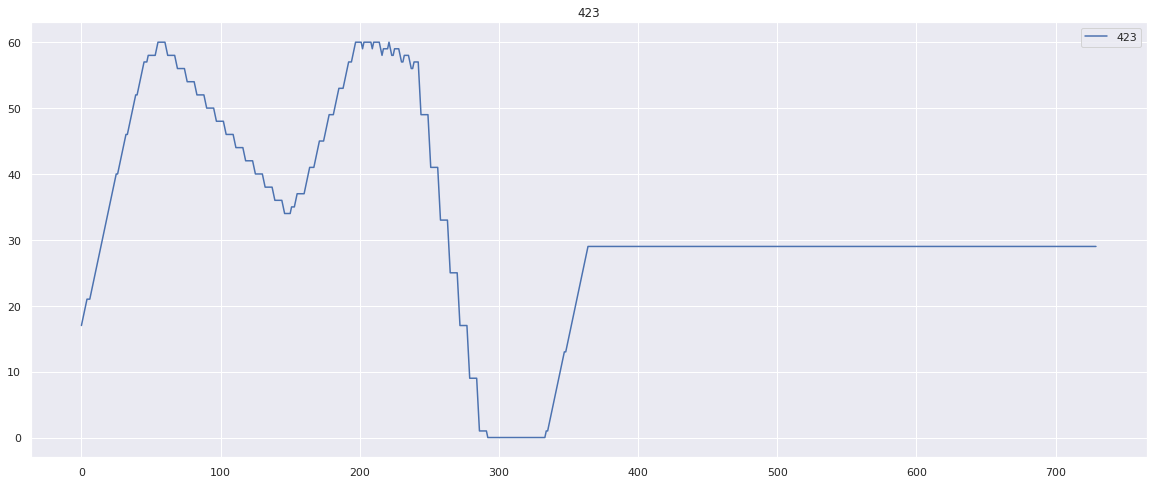

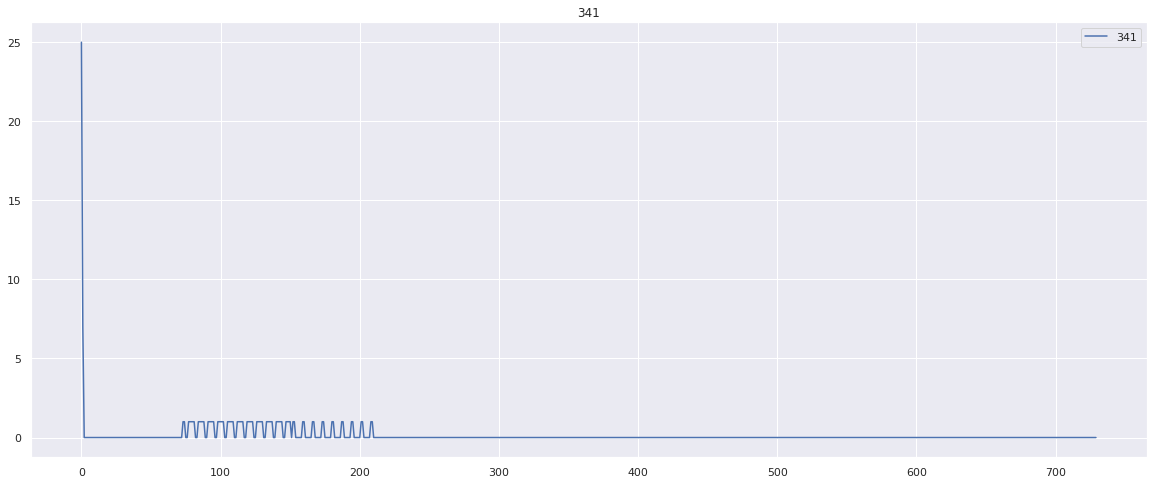

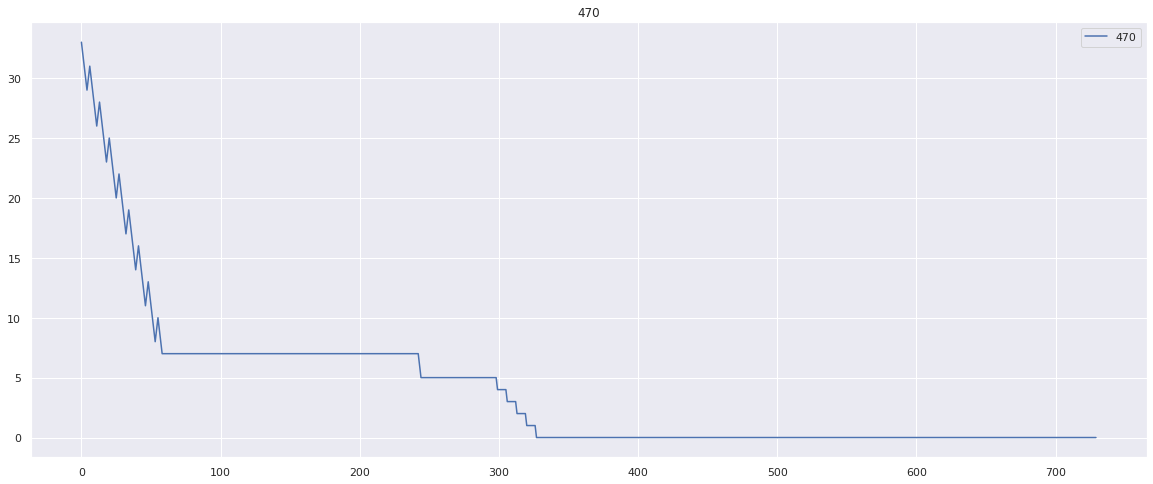

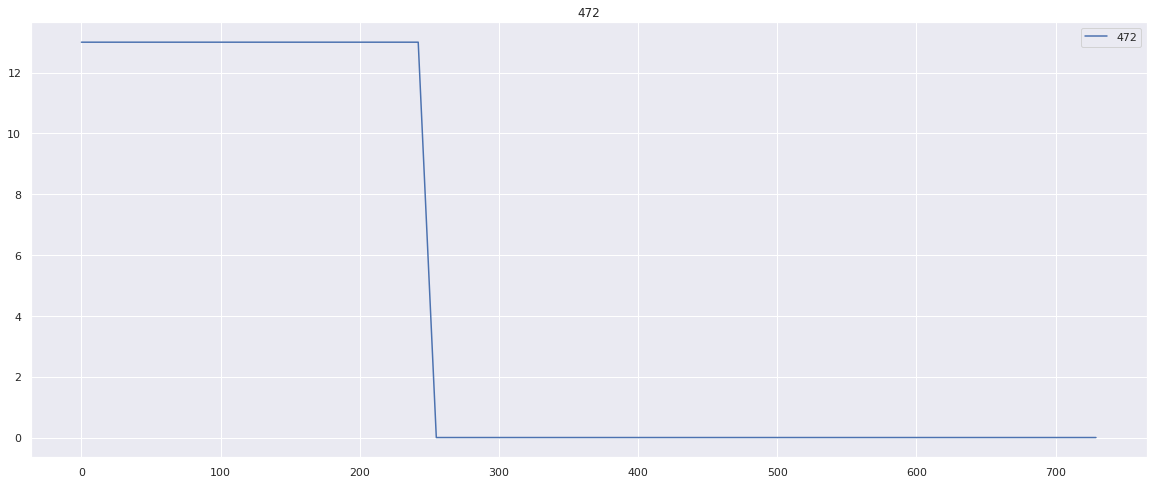

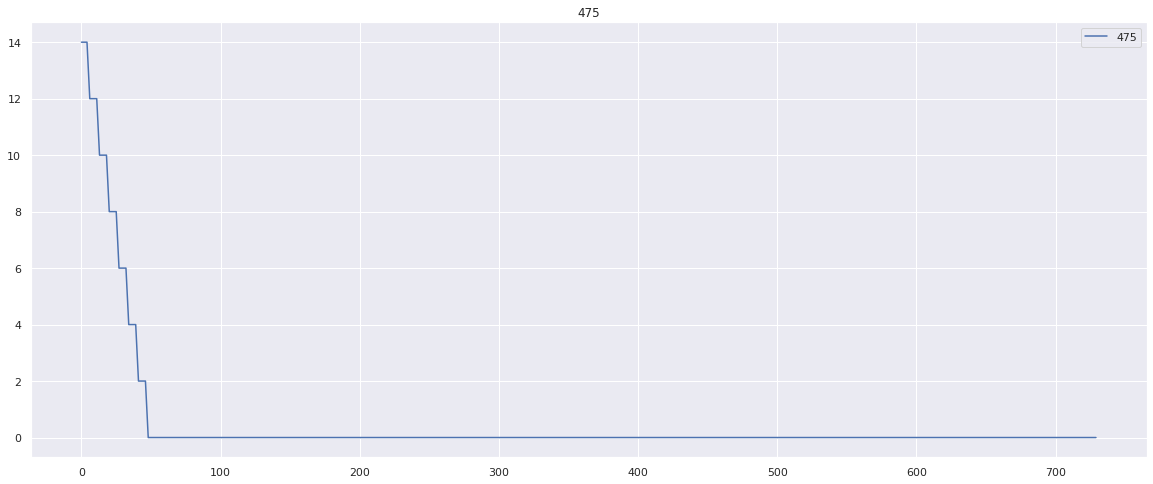

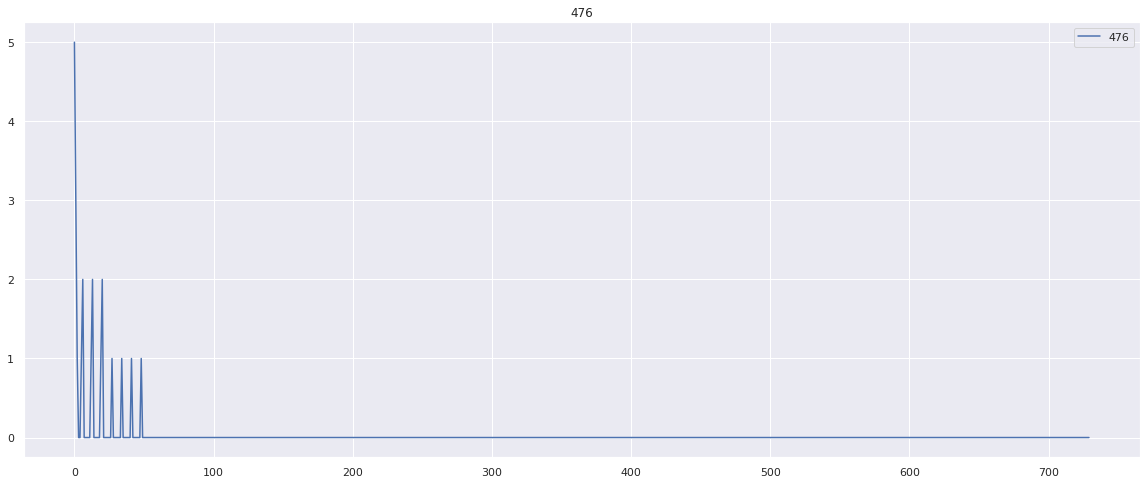

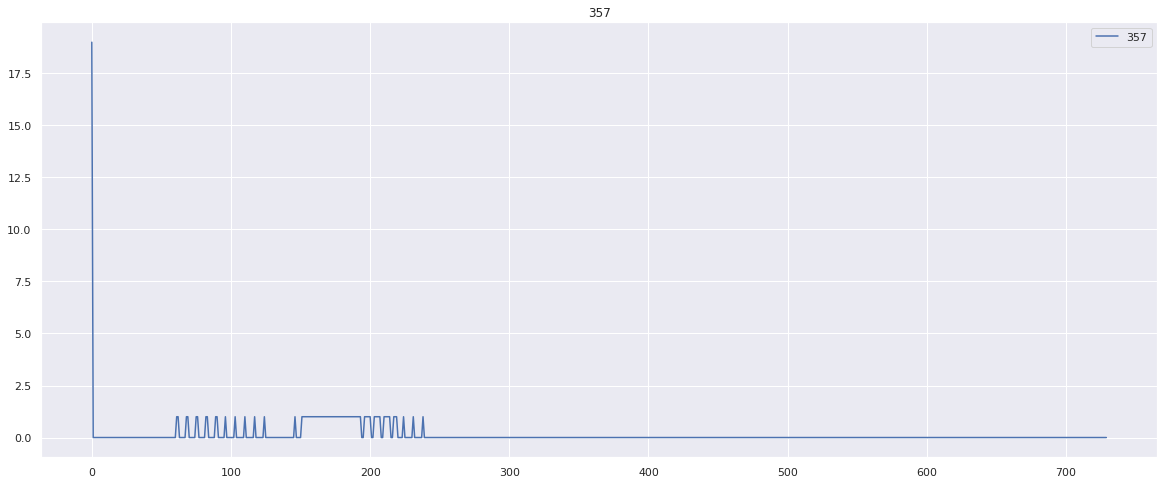

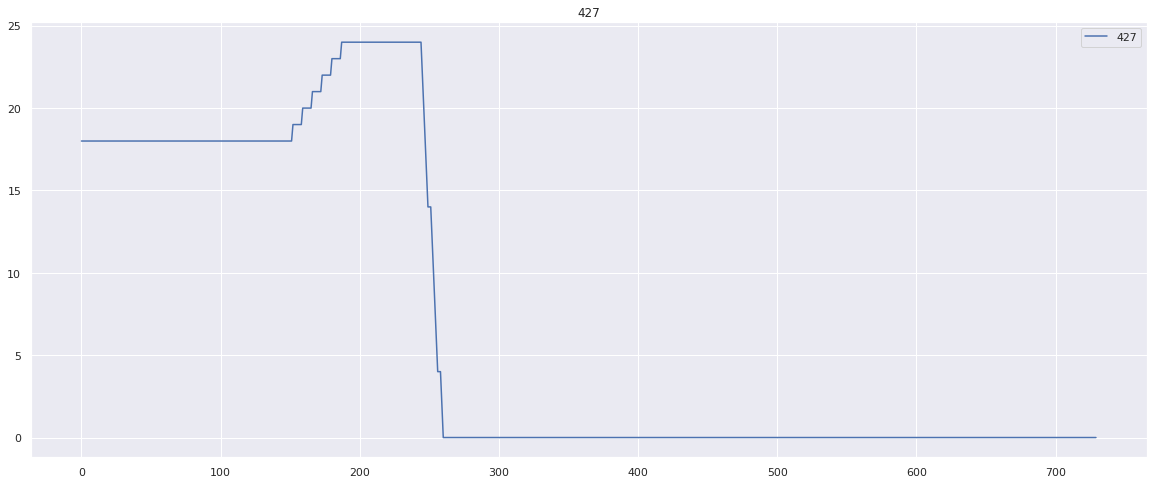

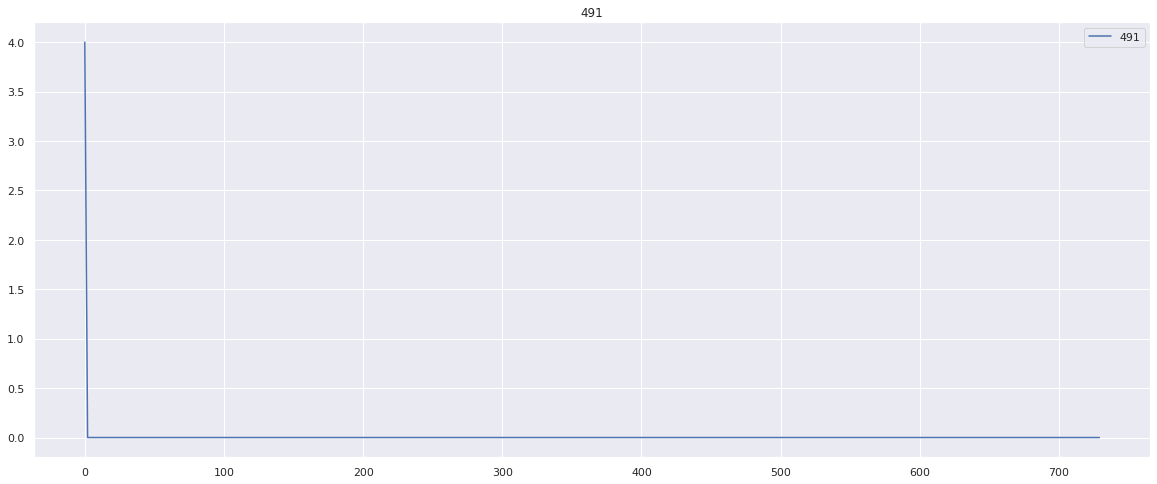

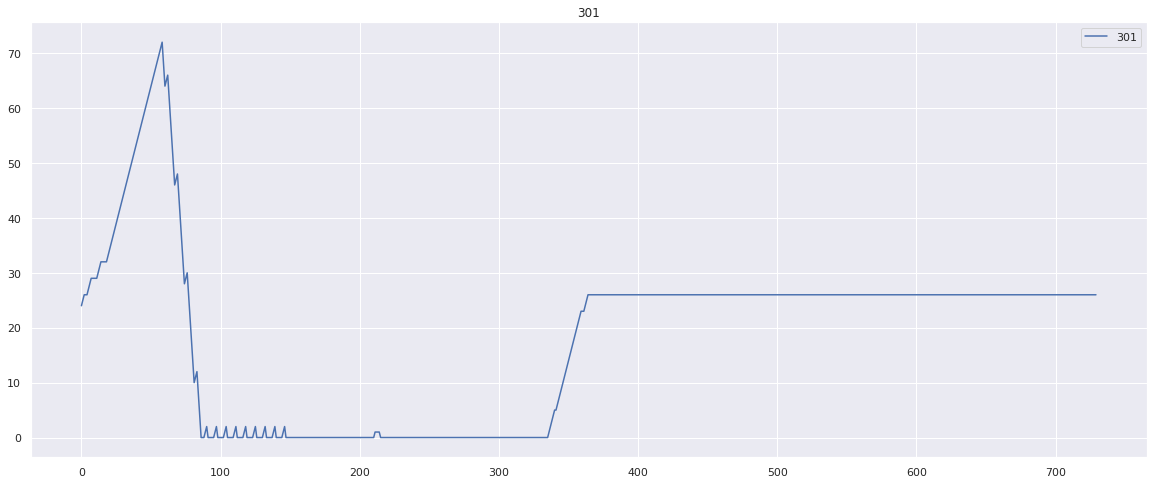

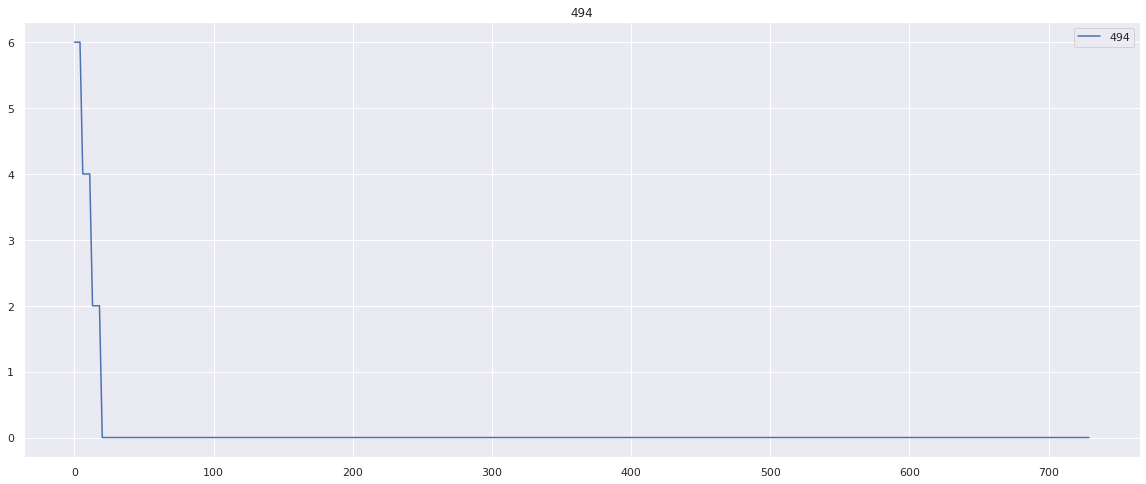

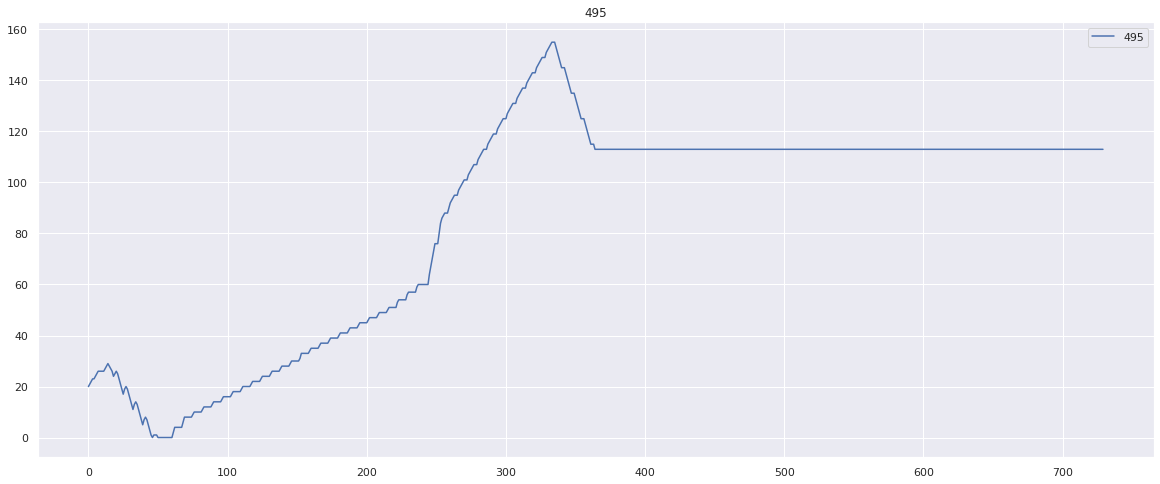

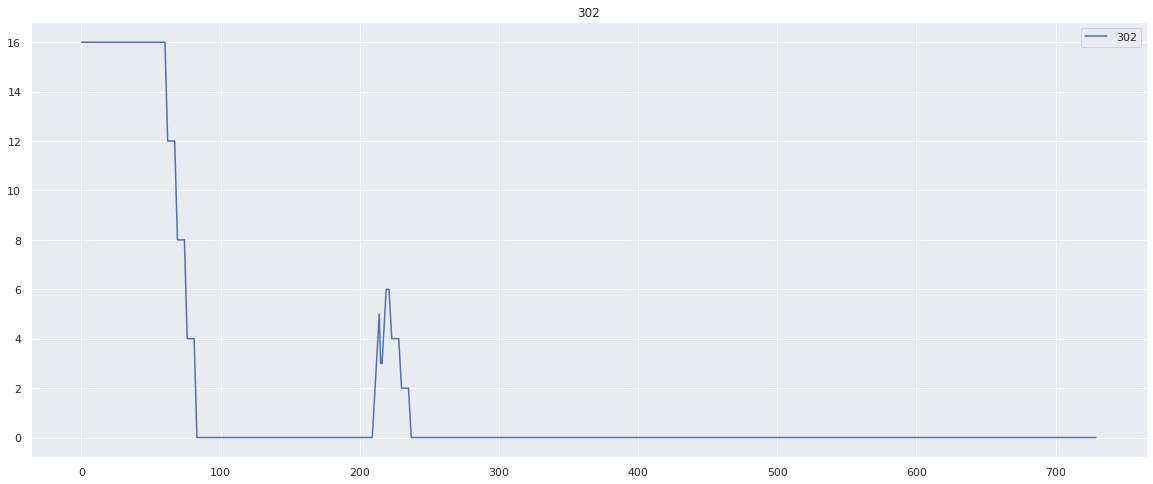

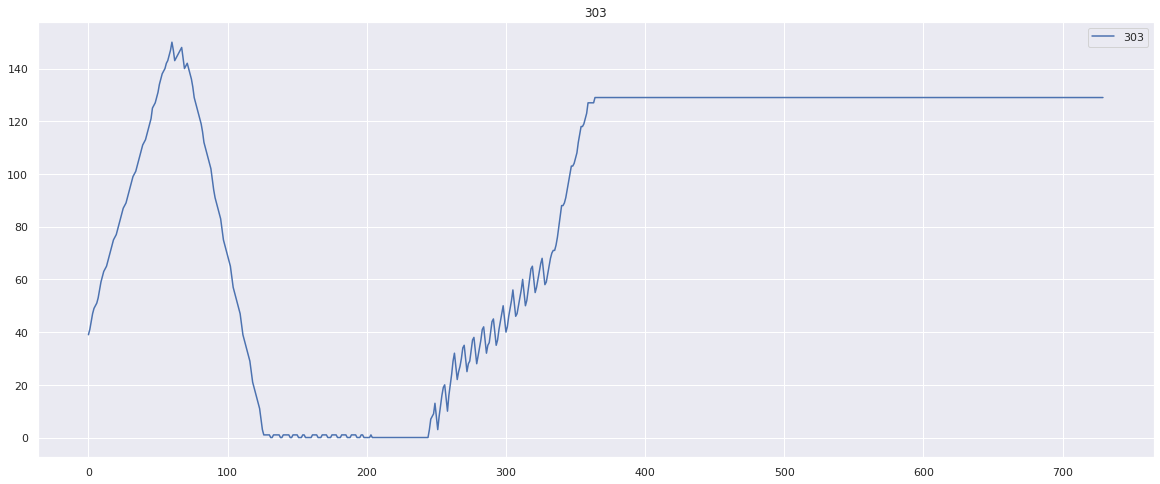

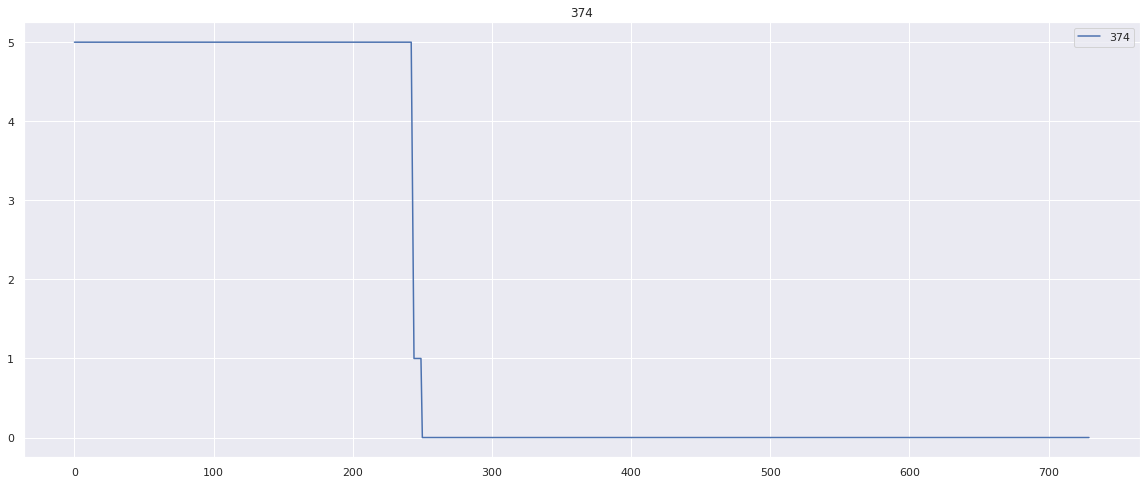

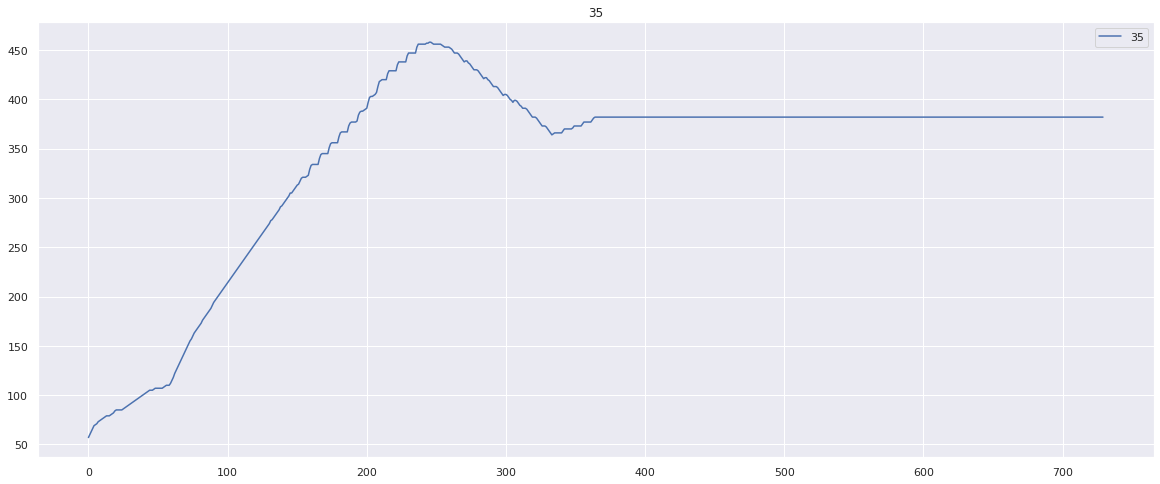

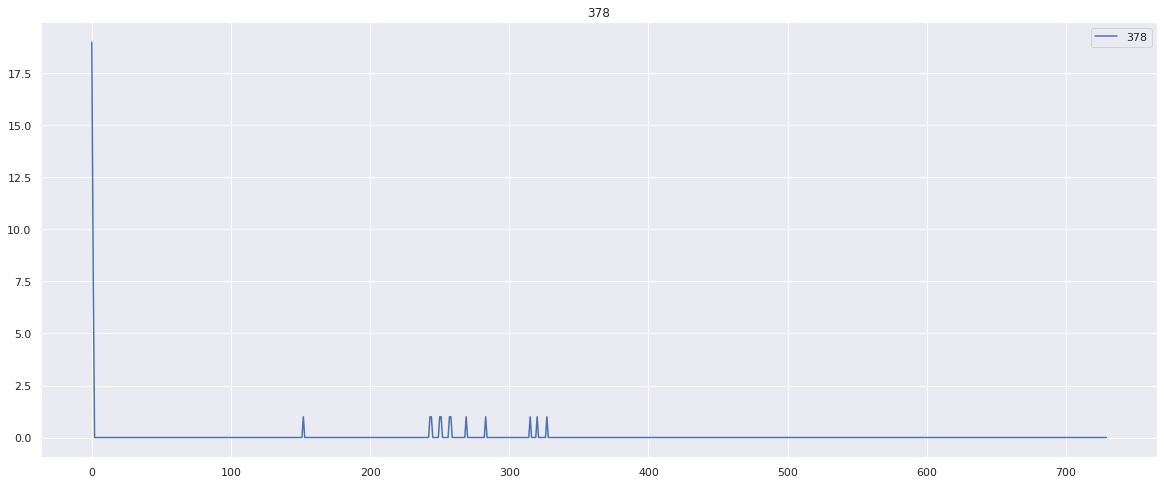

In [18]:
for x in set(tmp_df['id1']):
  plot_station_bikes_history(tmp_df, x)

2018-2019 920 bikes

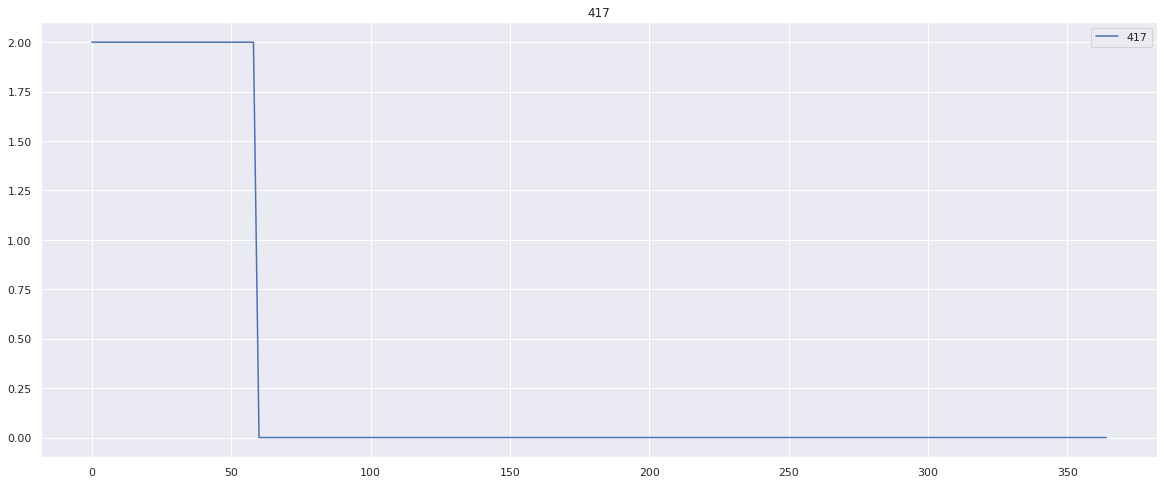

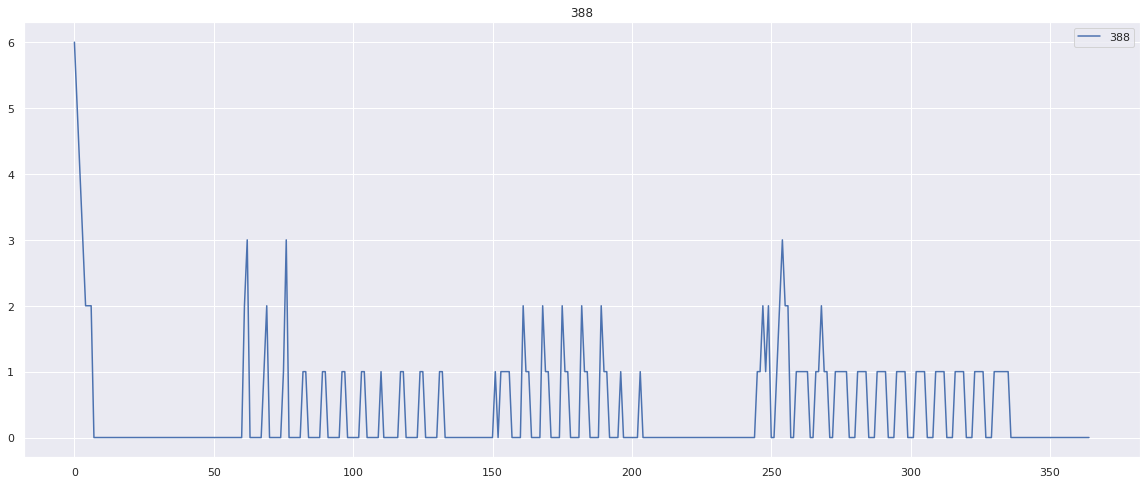

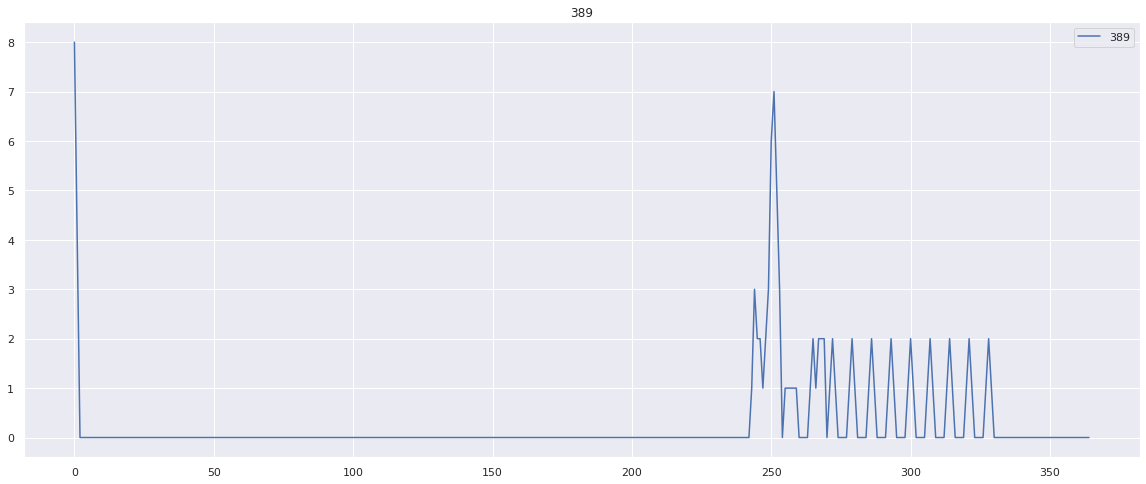

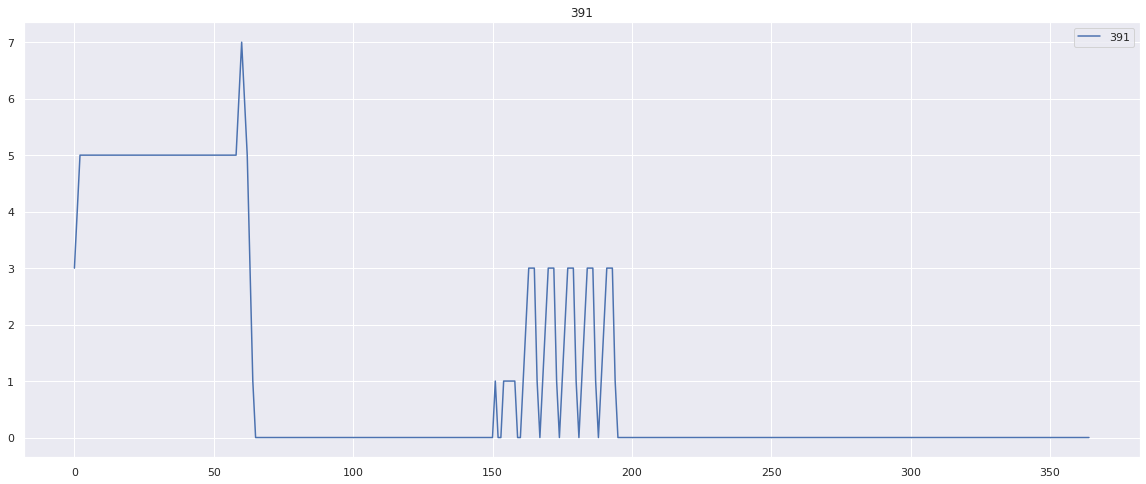

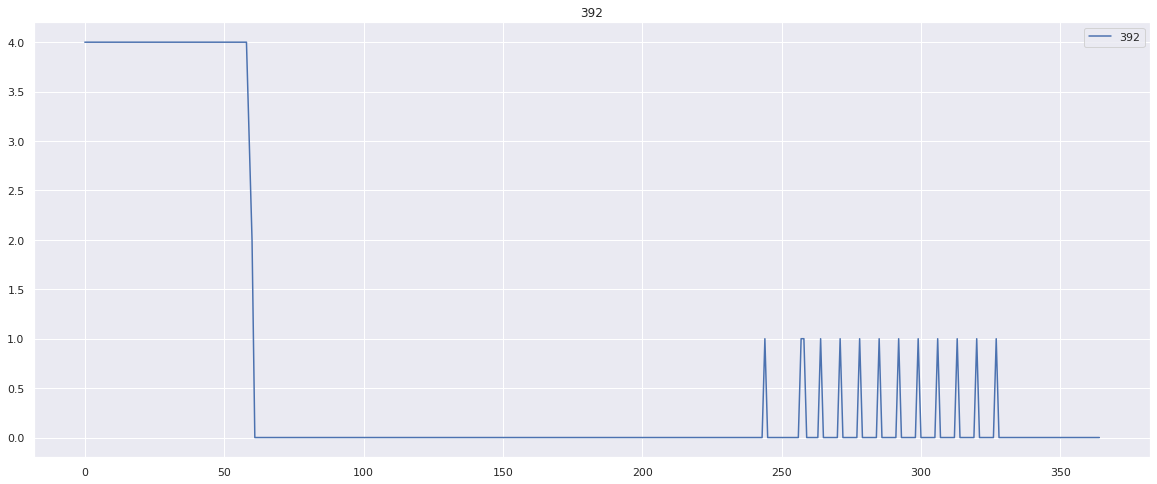

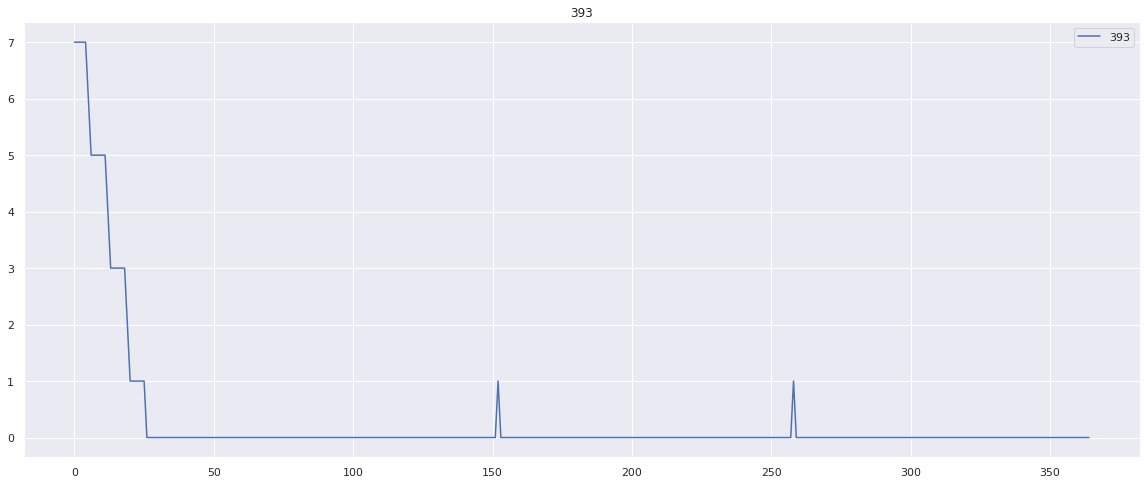

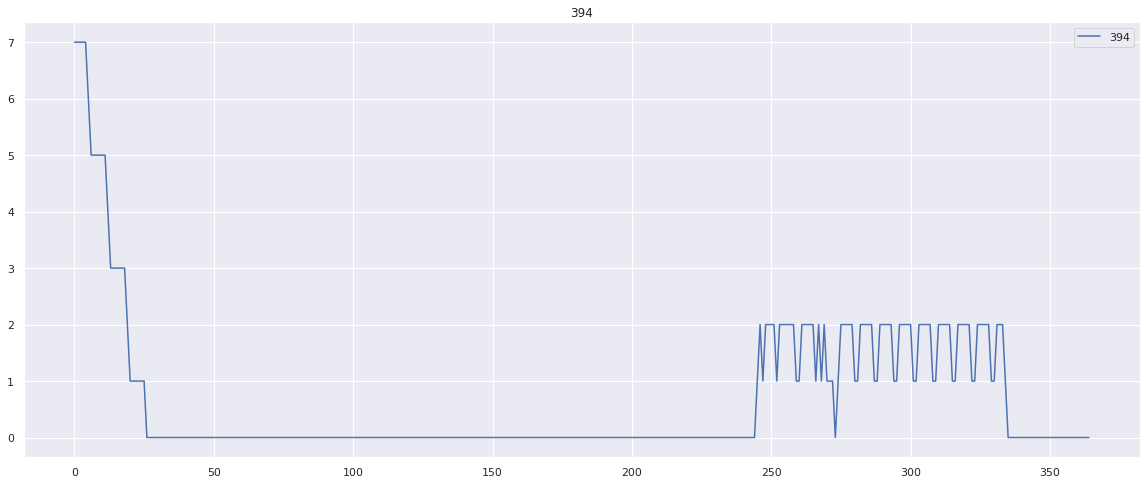

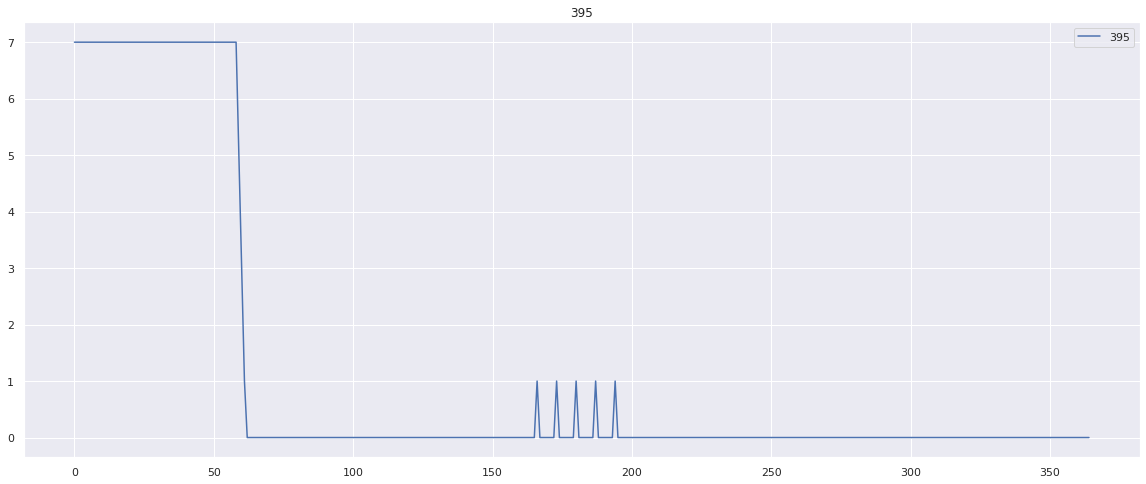

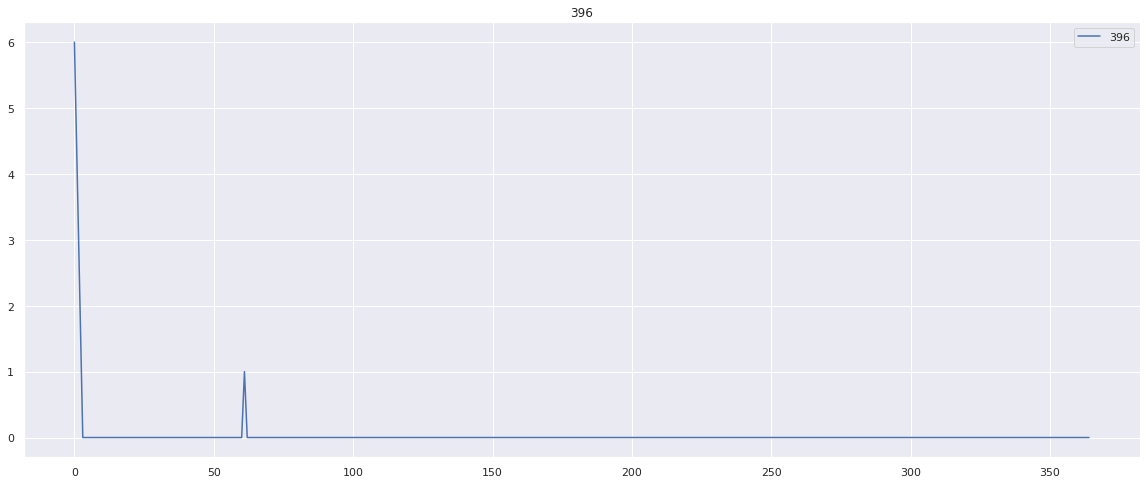

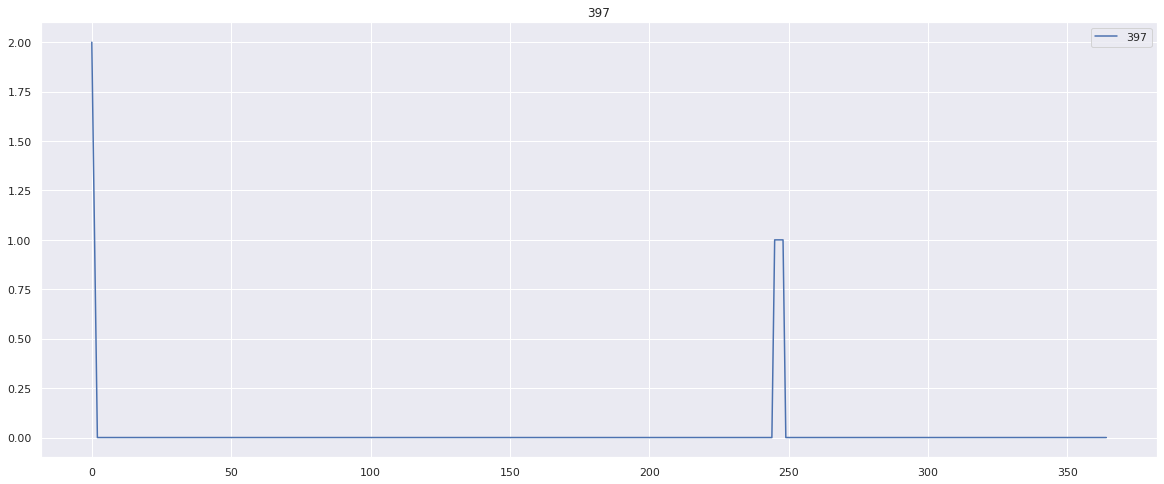

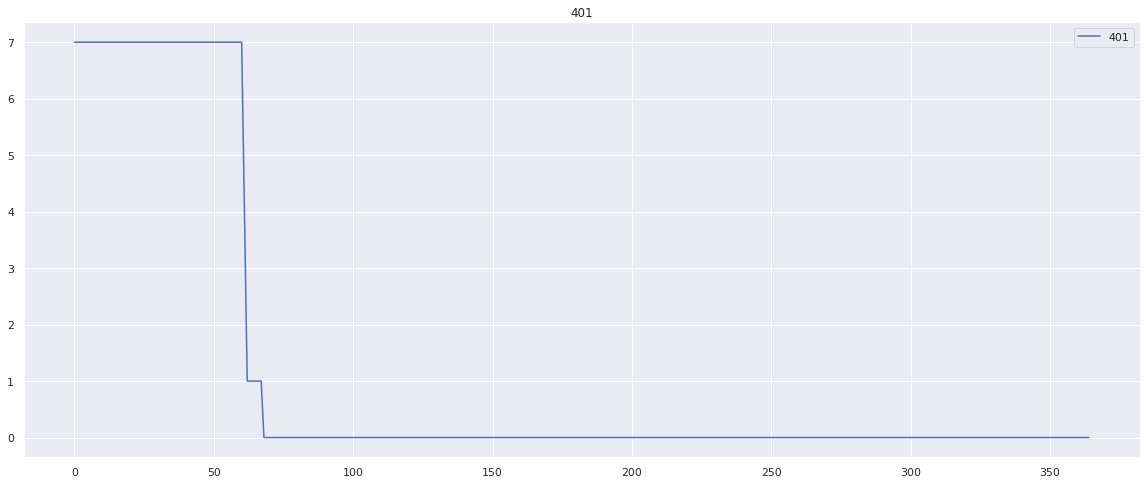

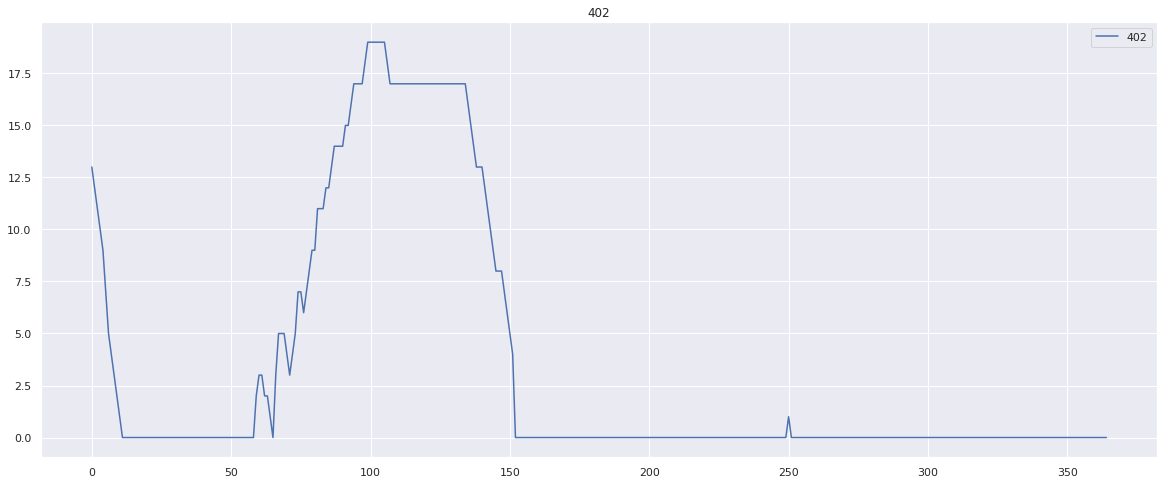

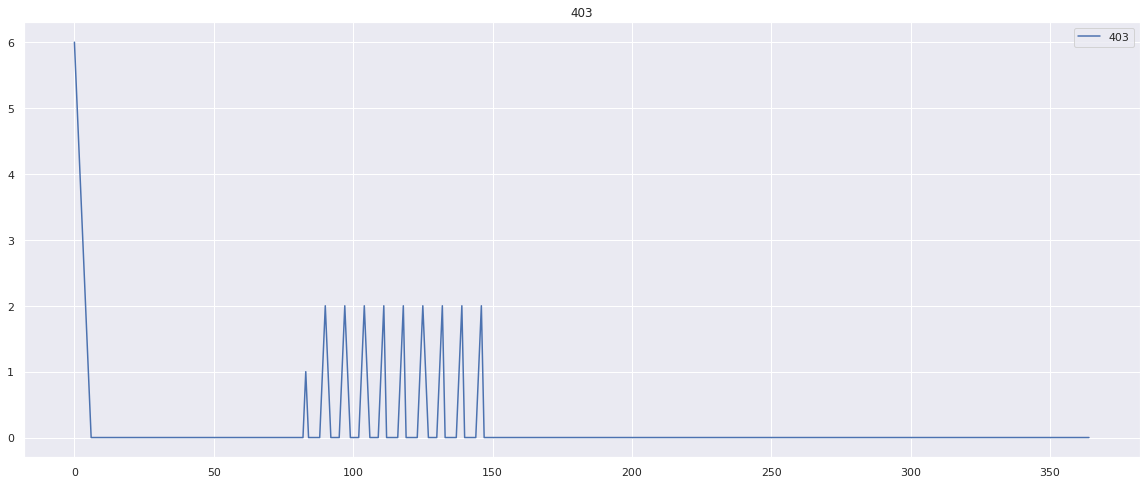

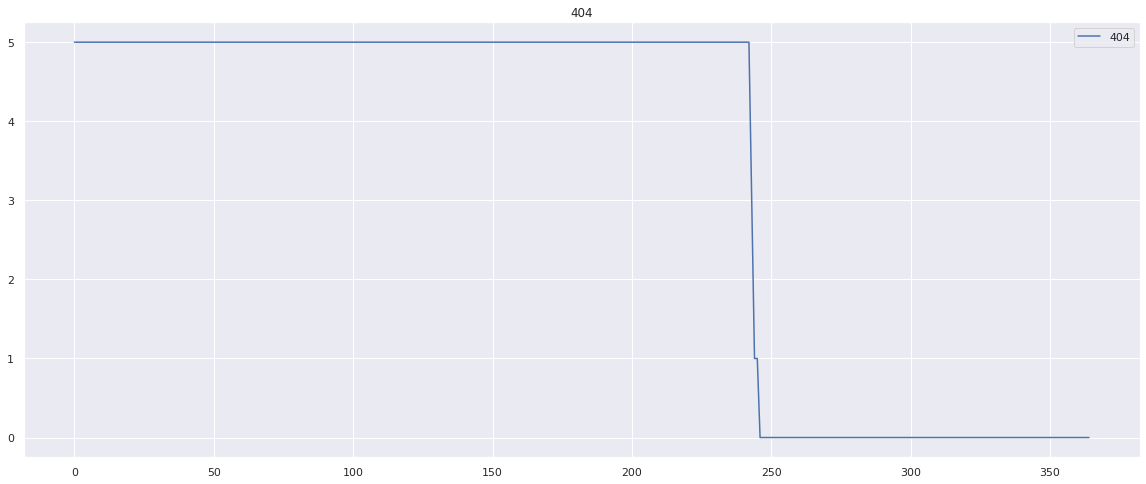

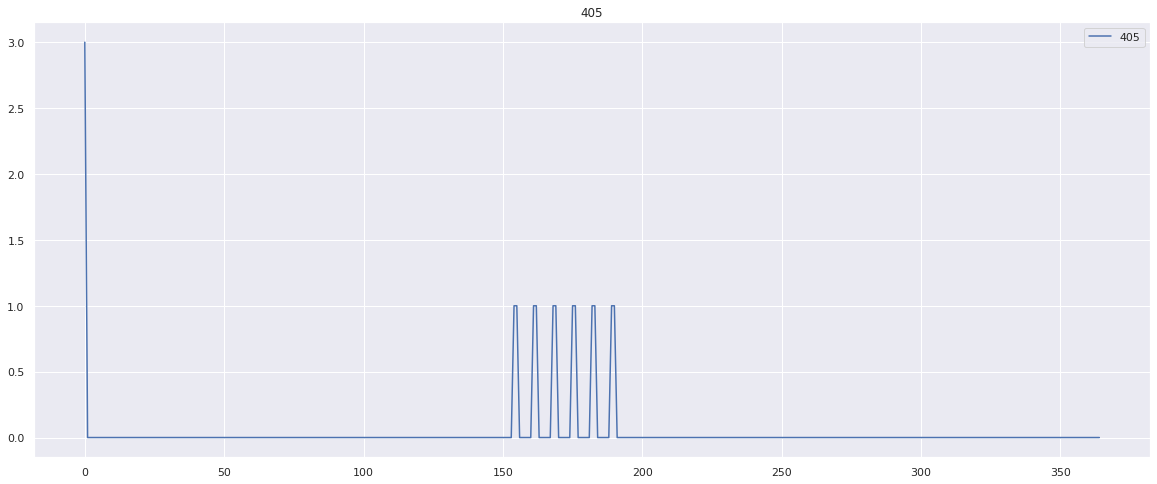

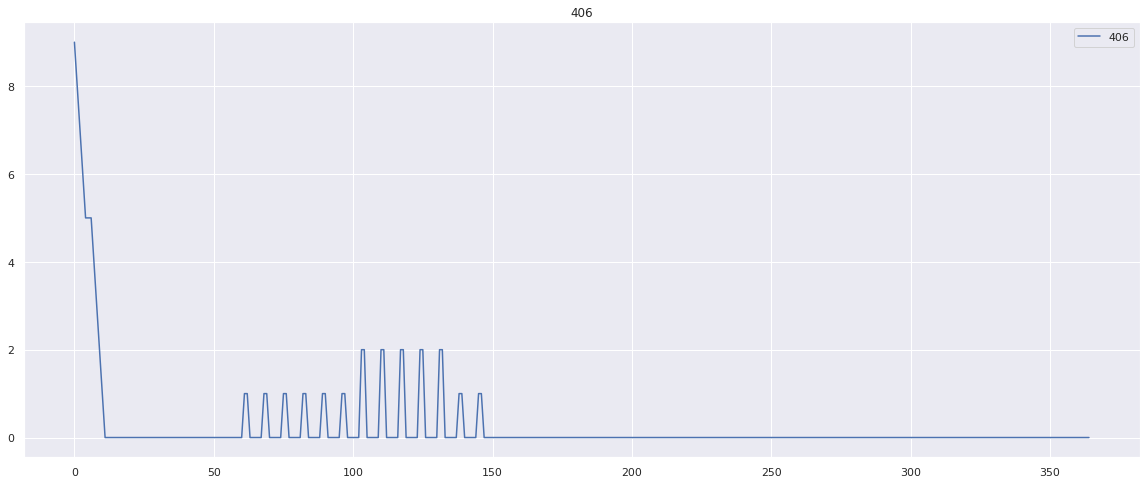

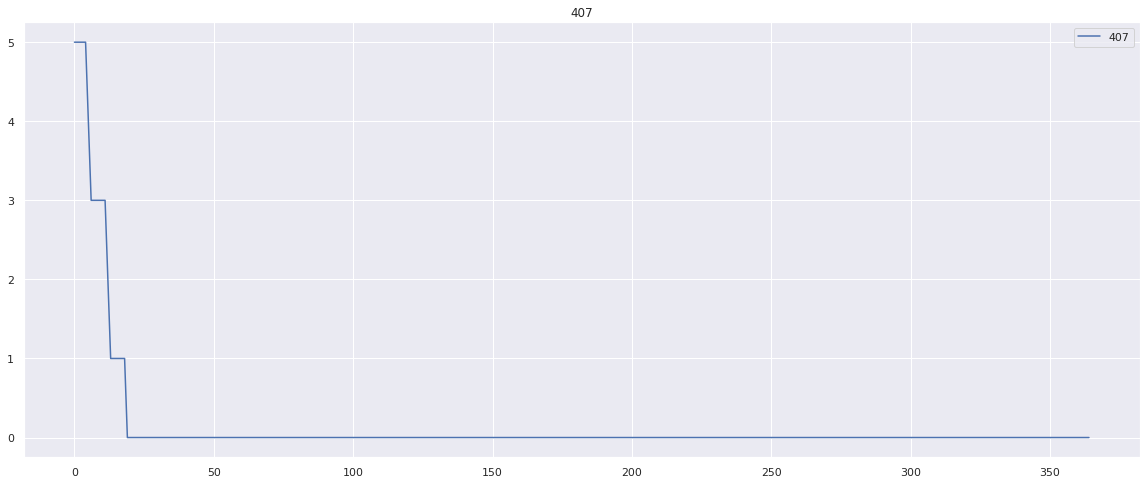

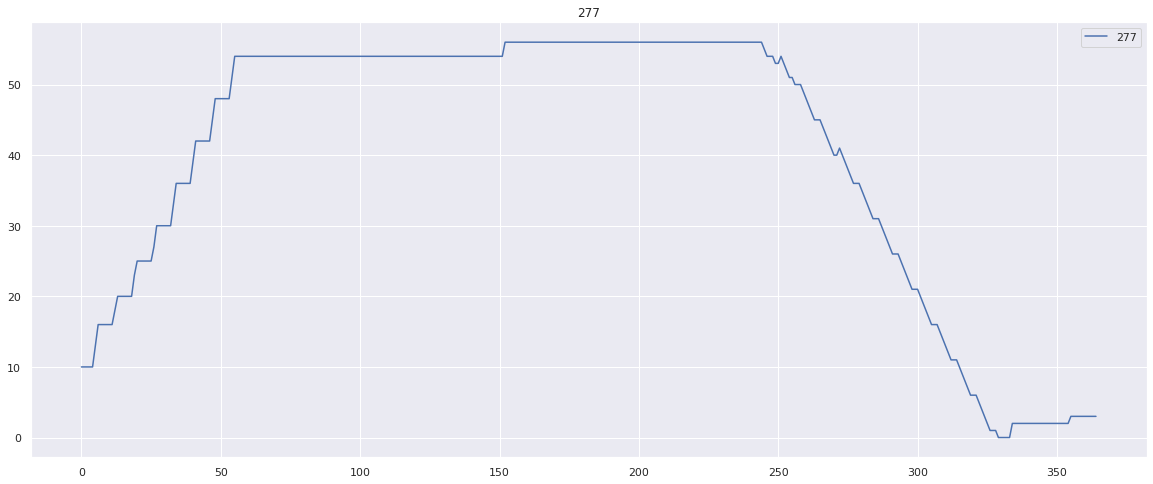

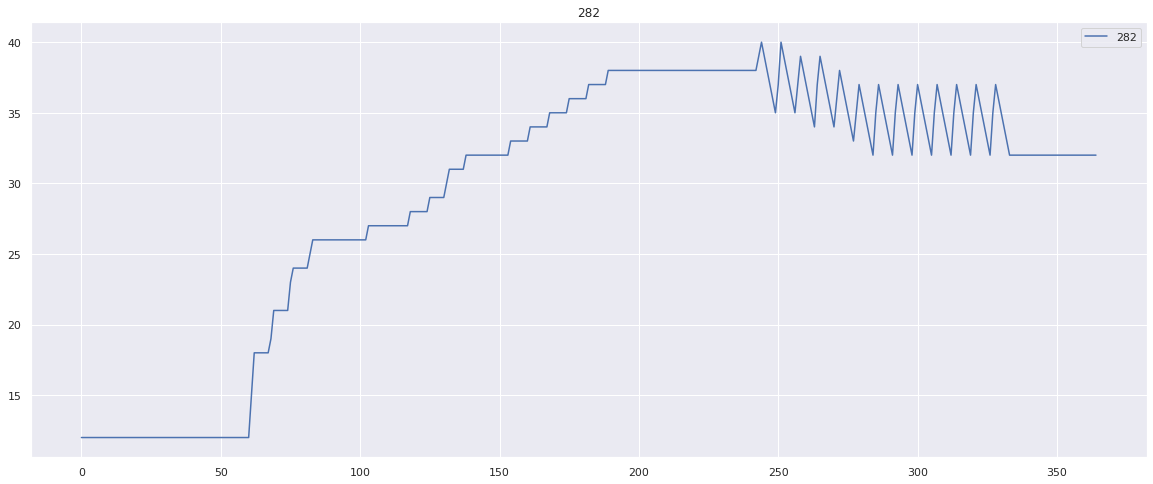

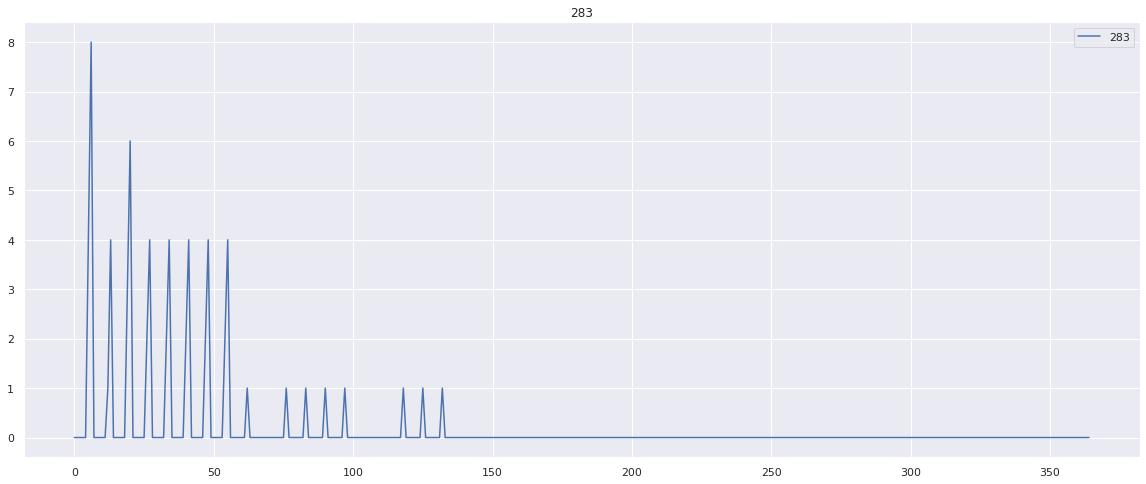

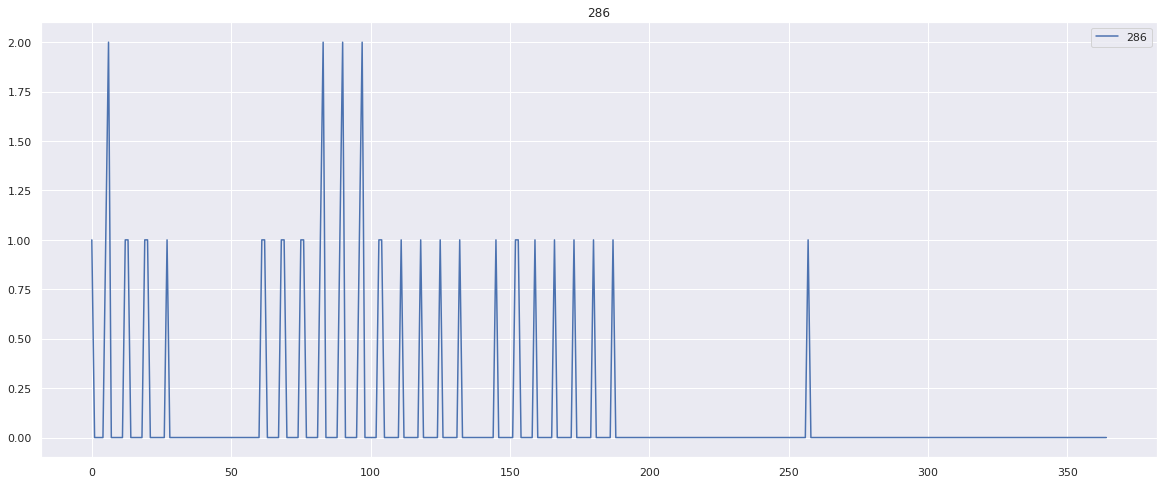

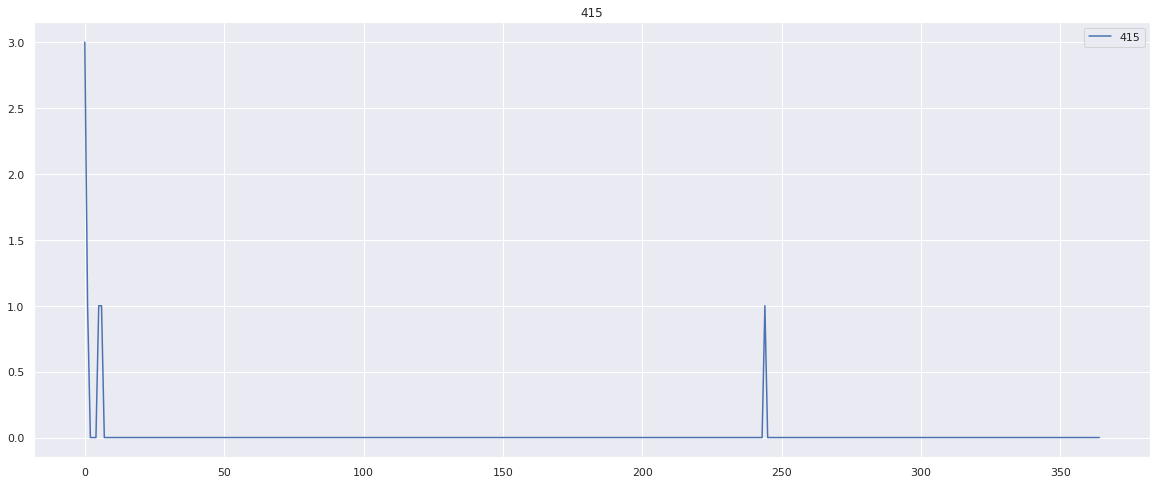

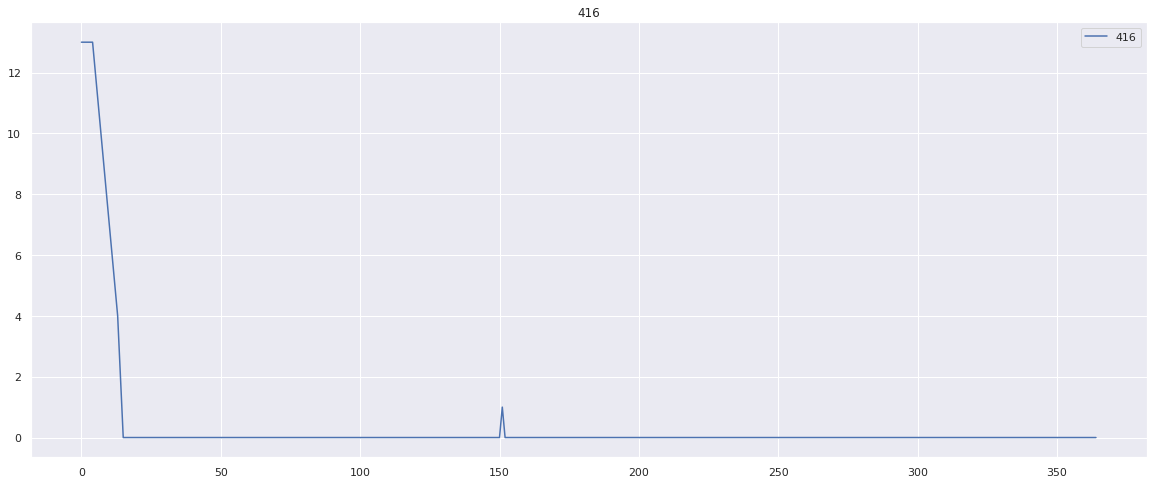

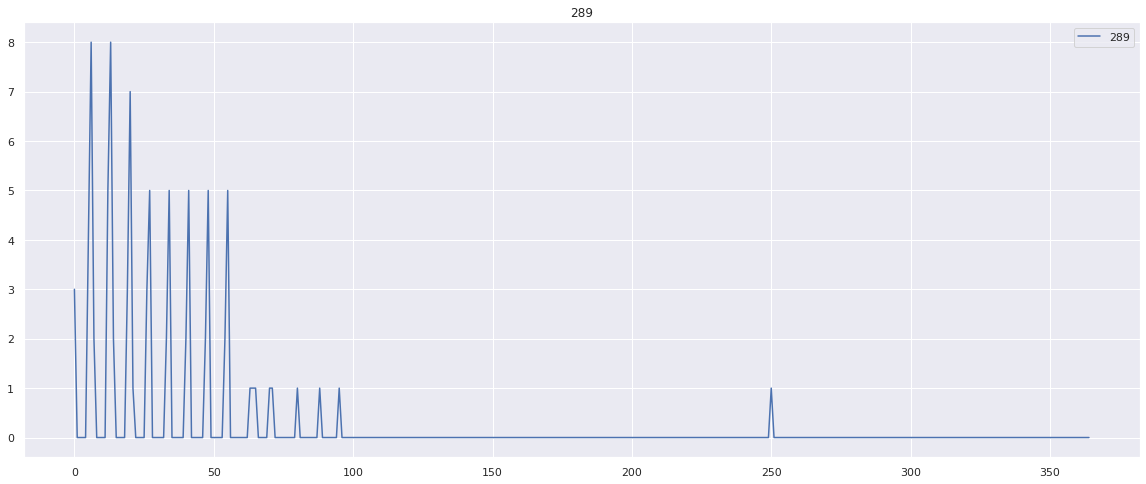

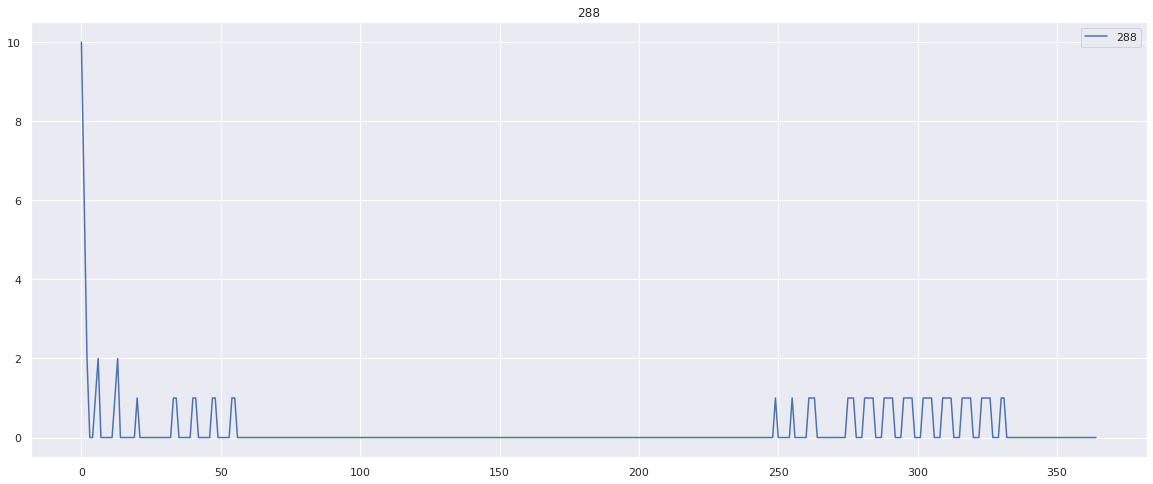

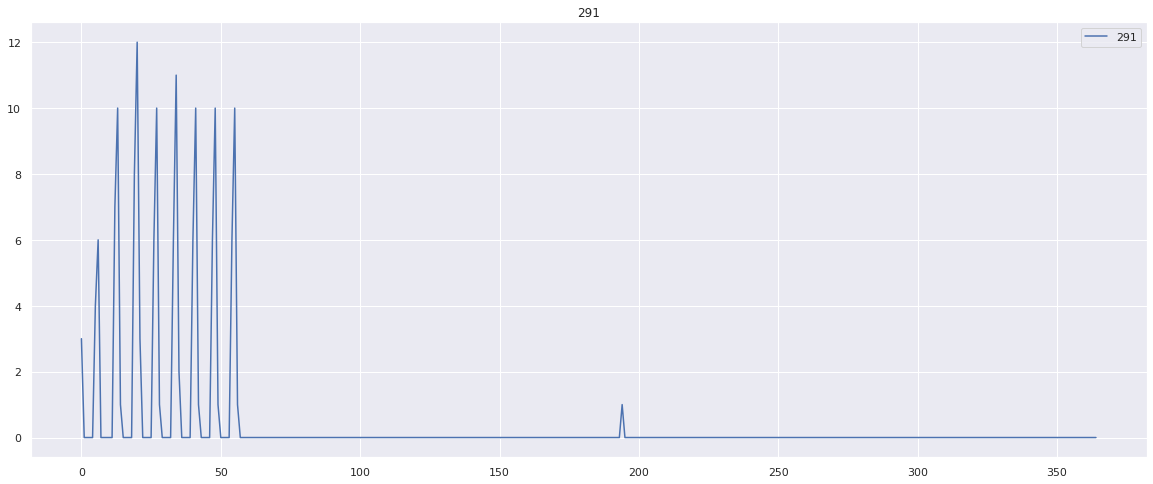

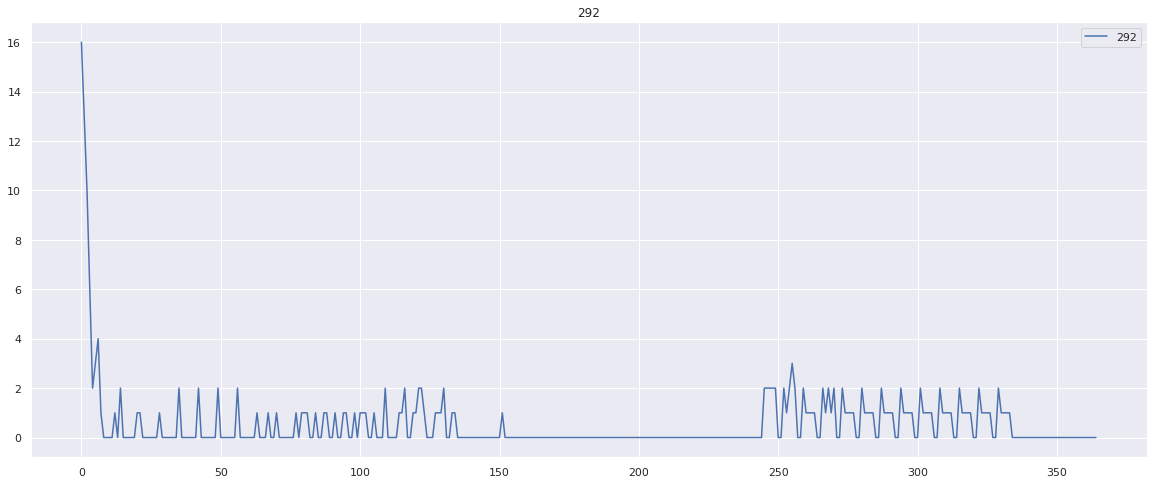

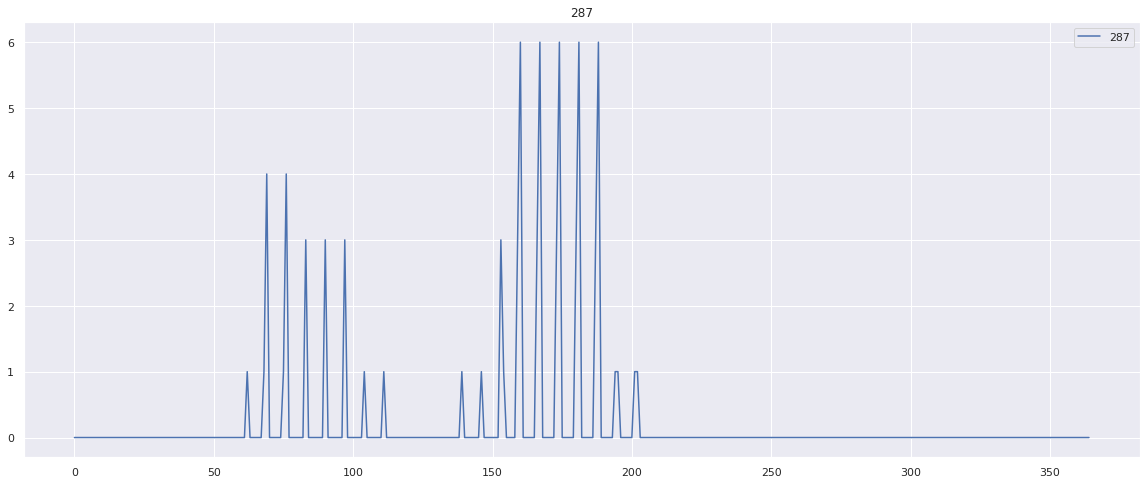

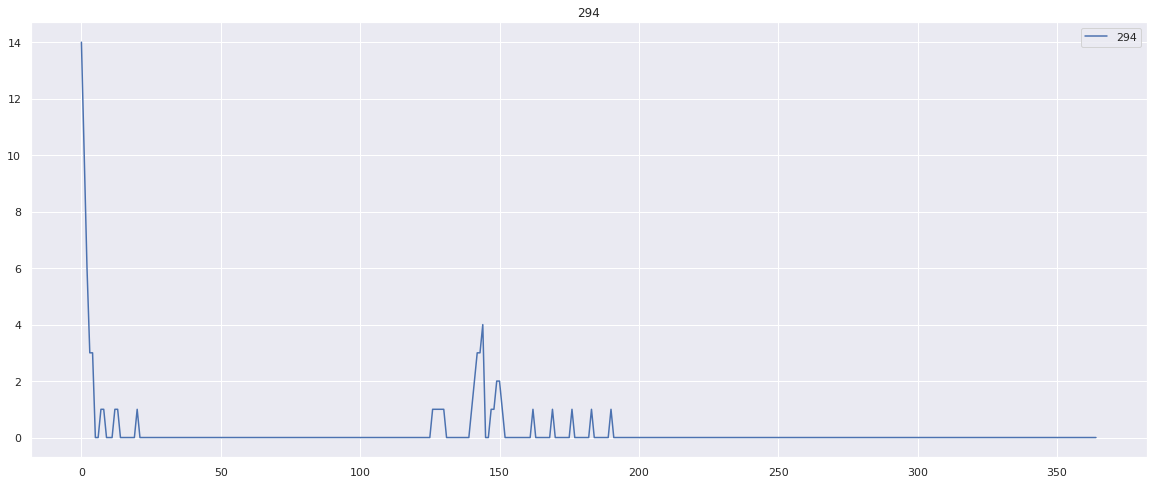

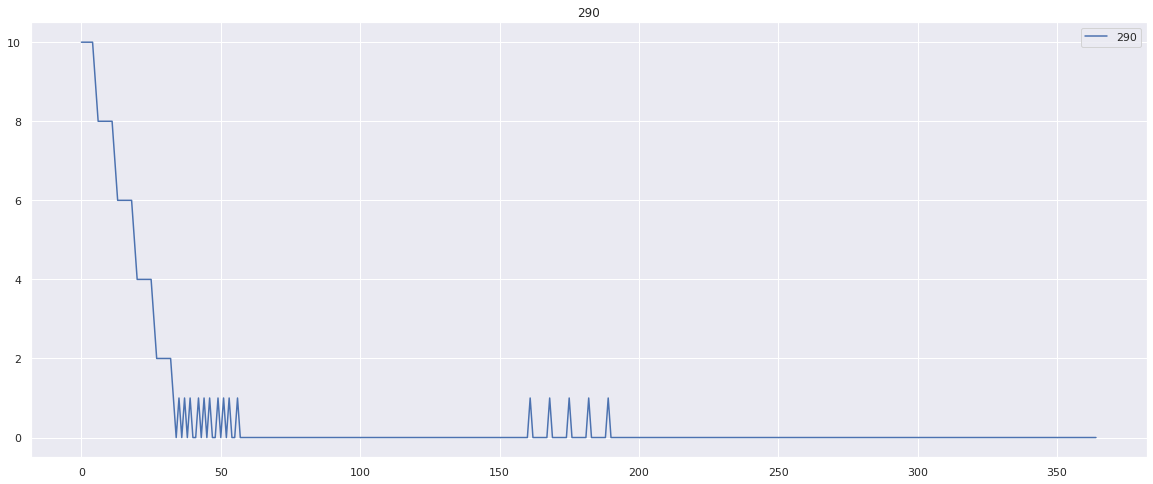

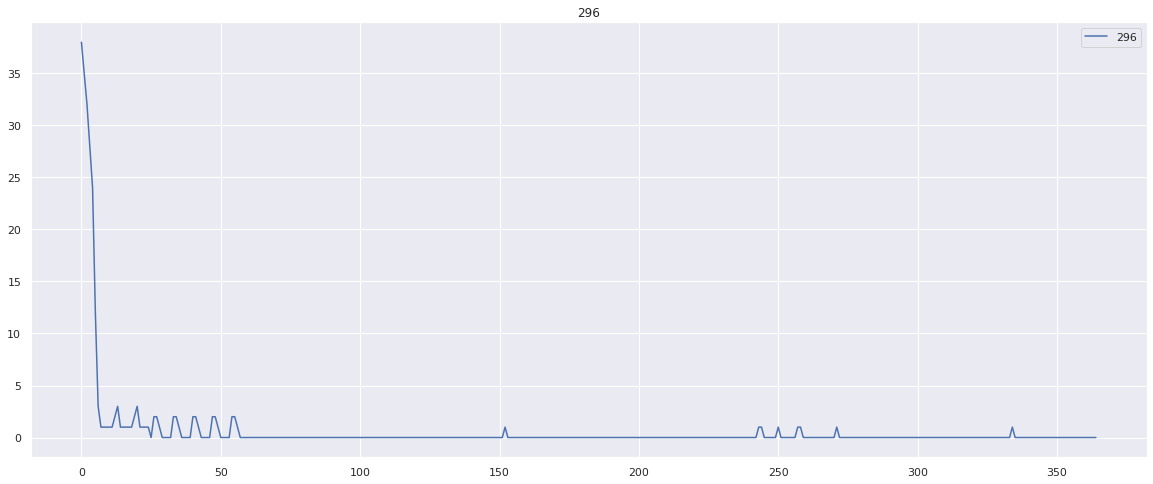

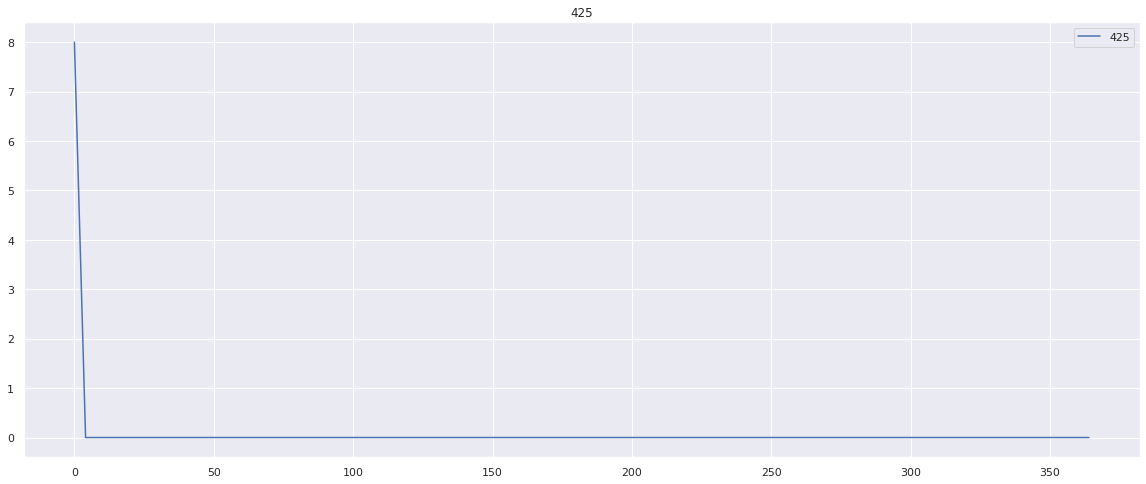

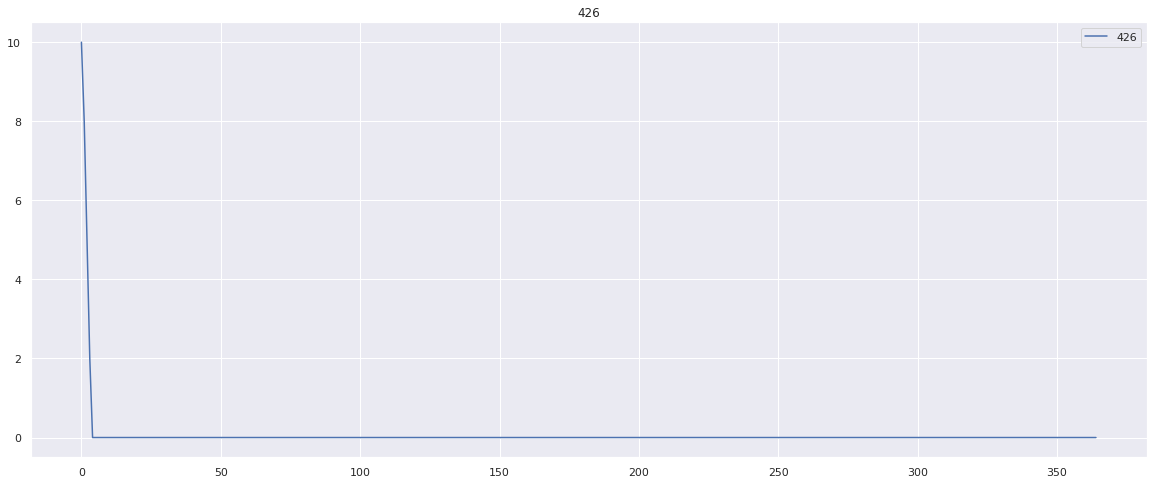

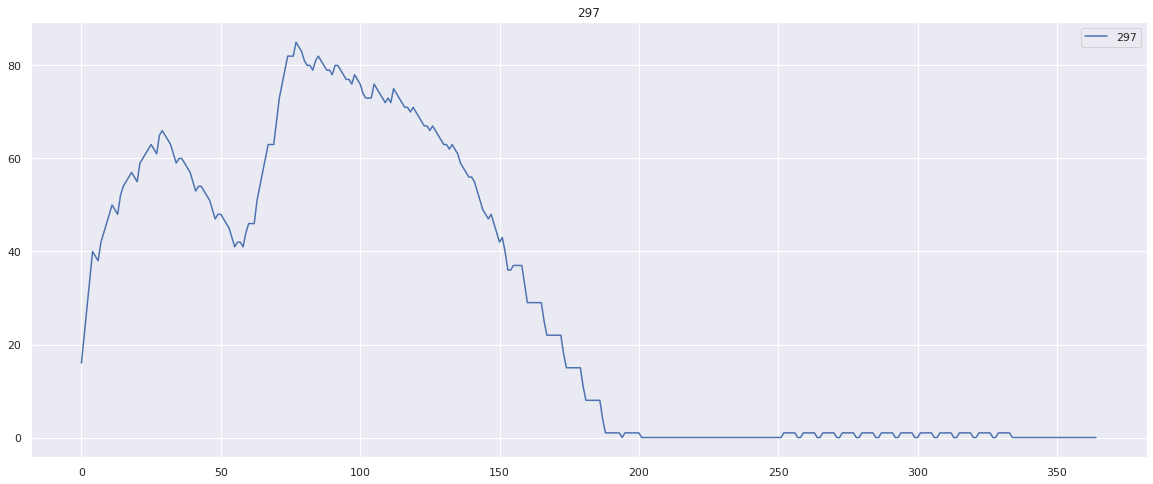

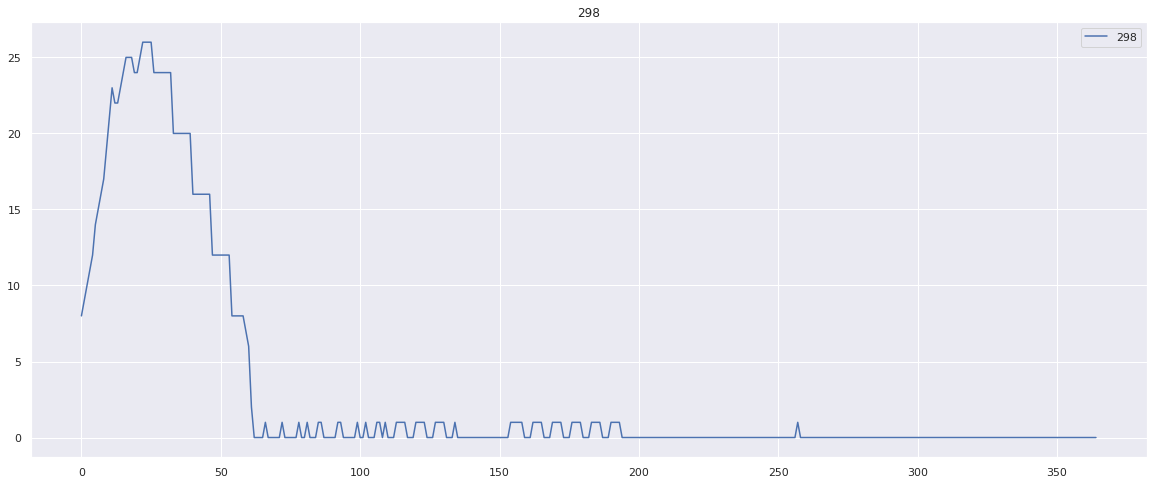

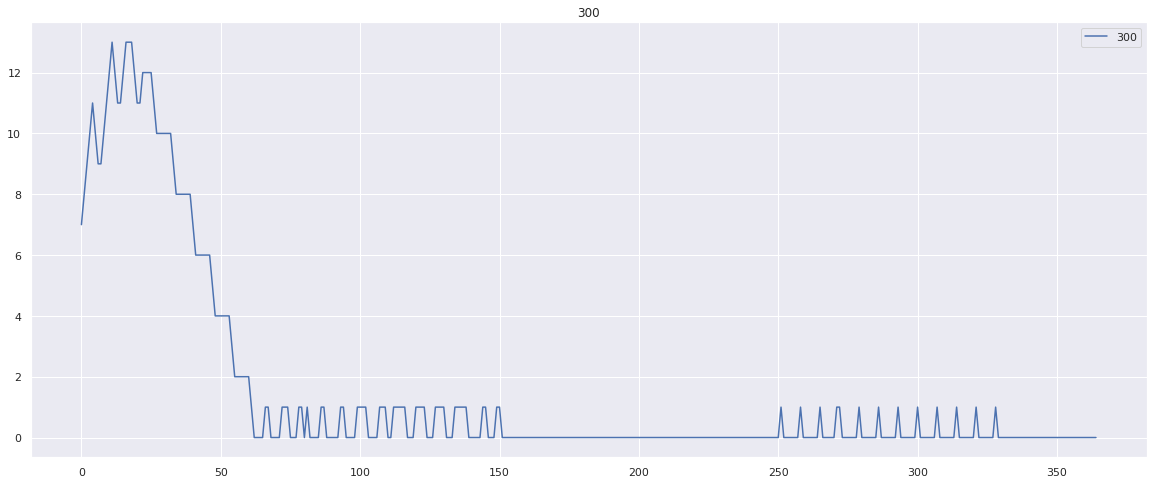

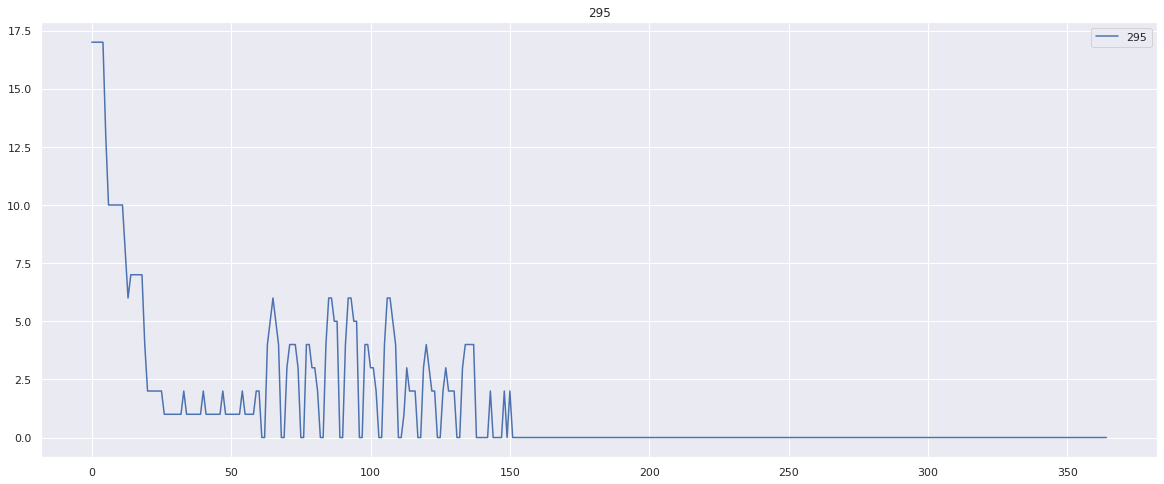

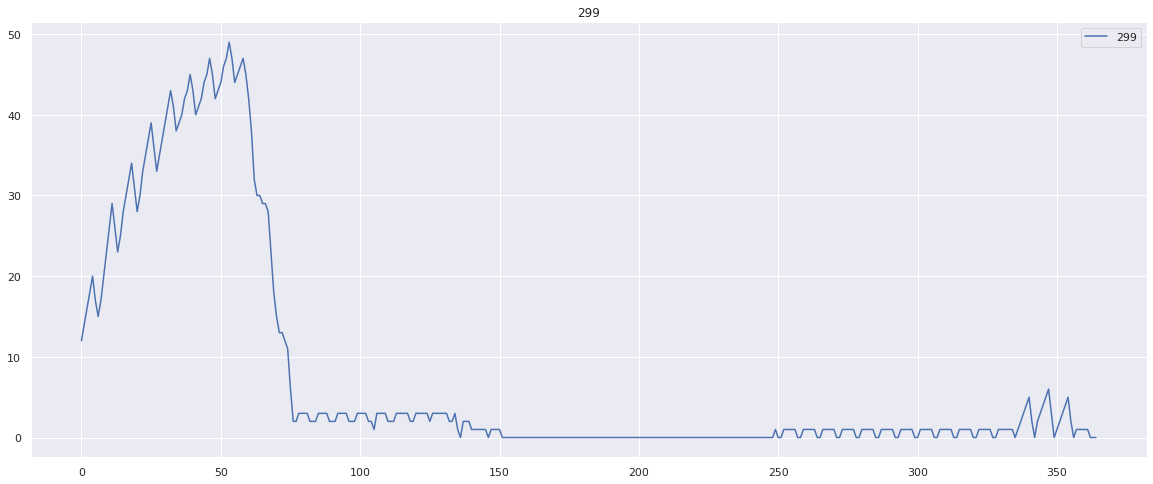

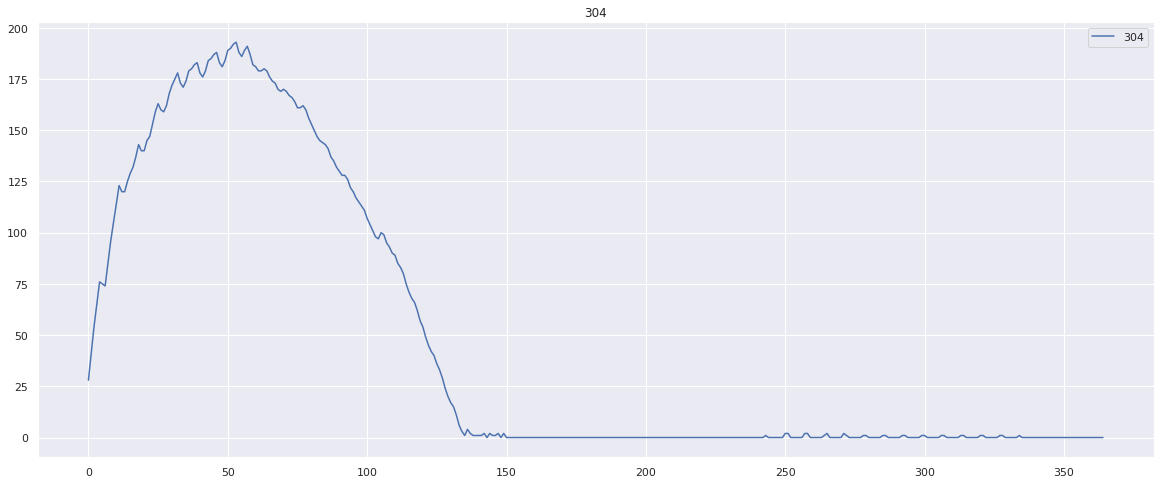

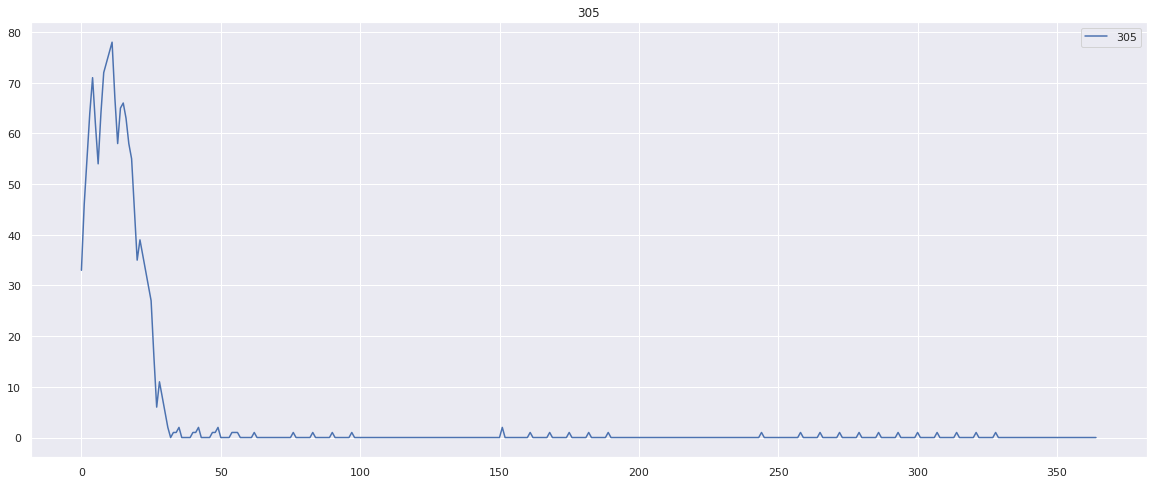

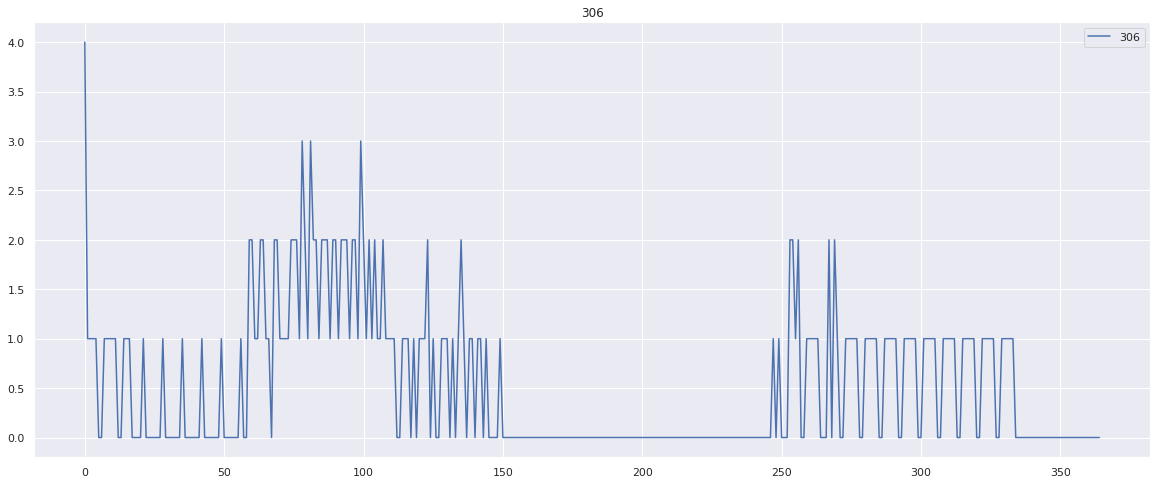

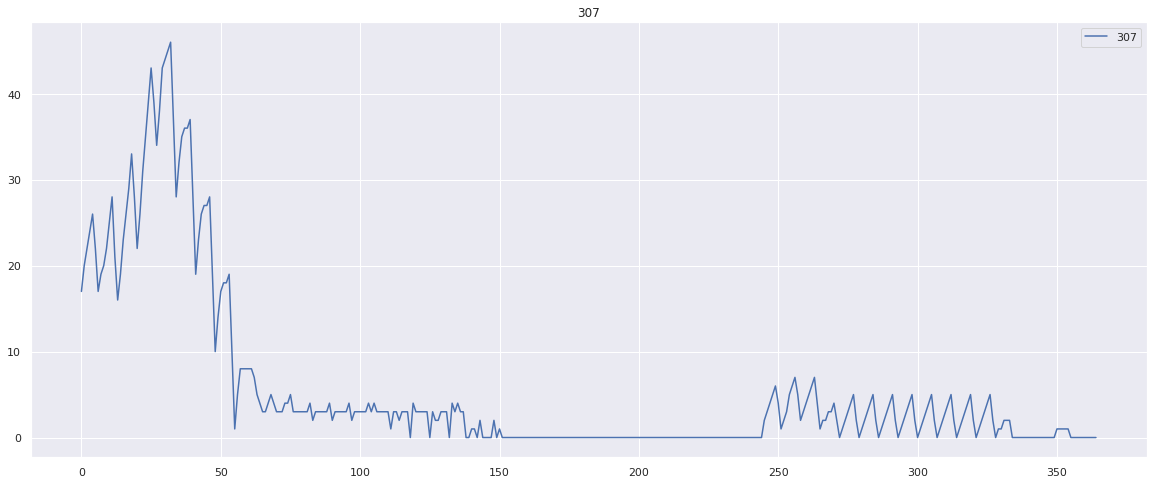

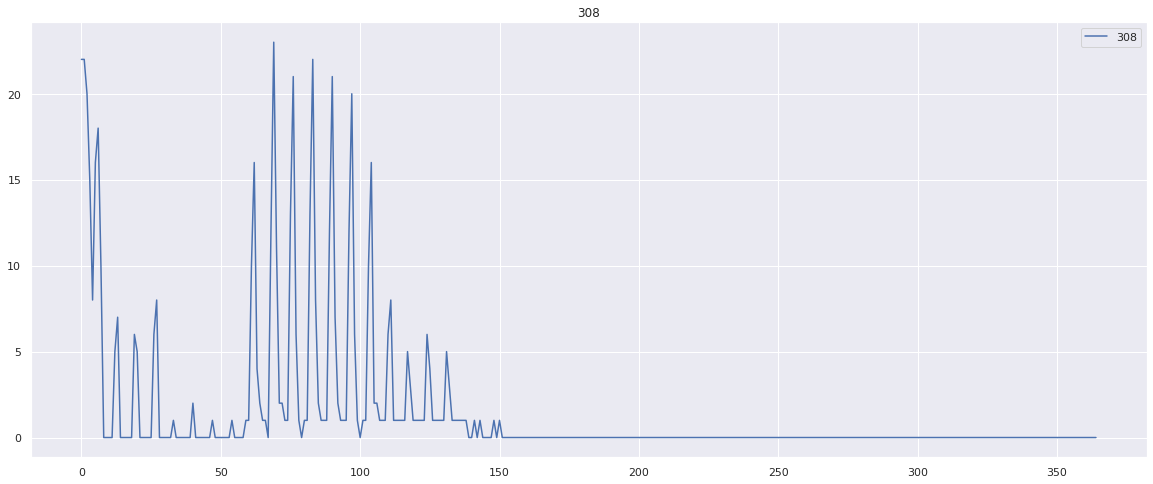

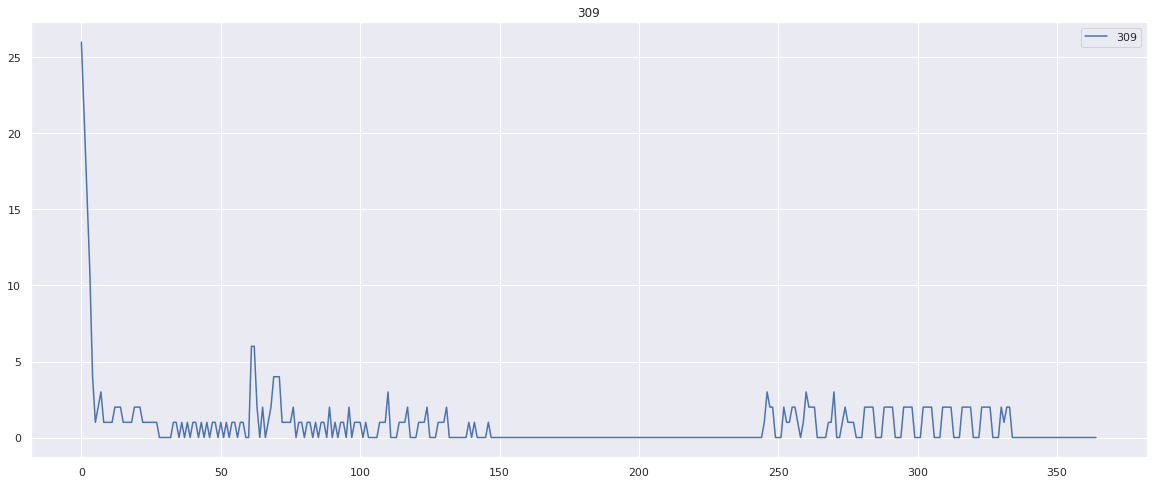

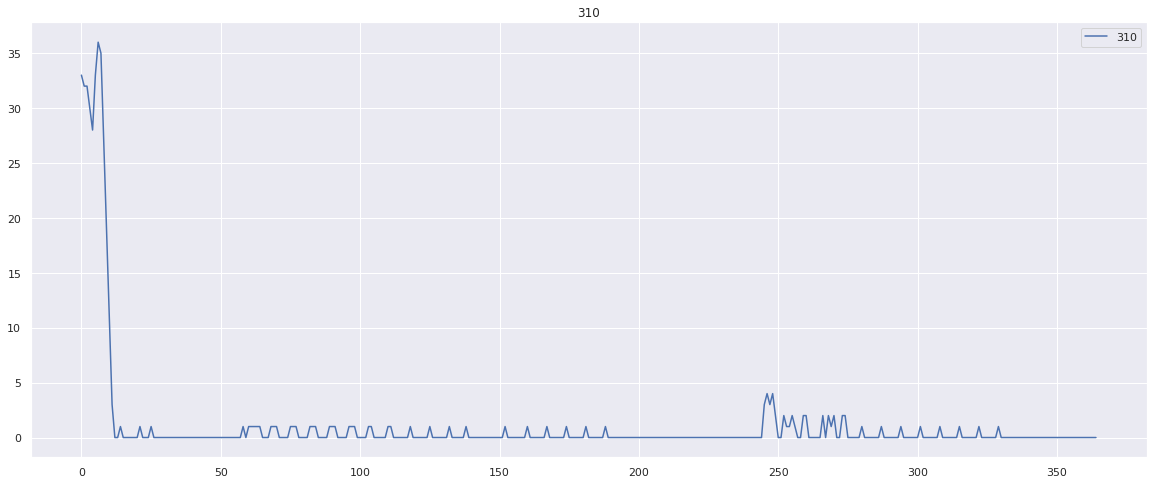

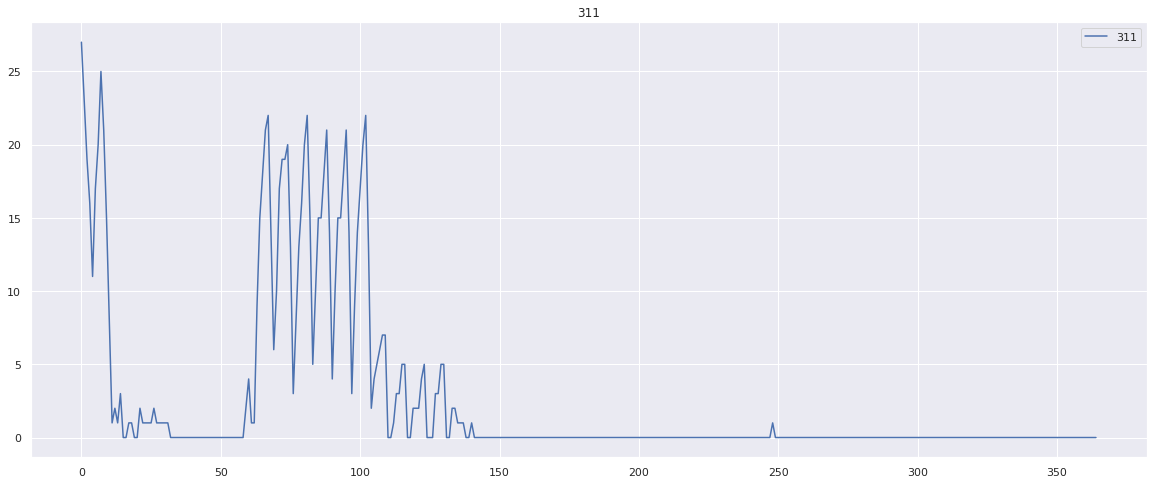

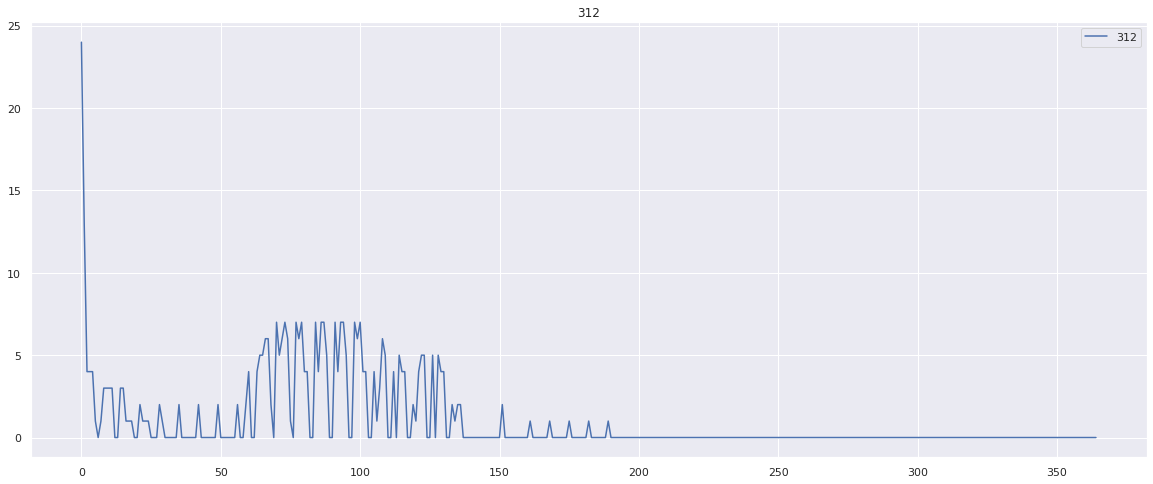

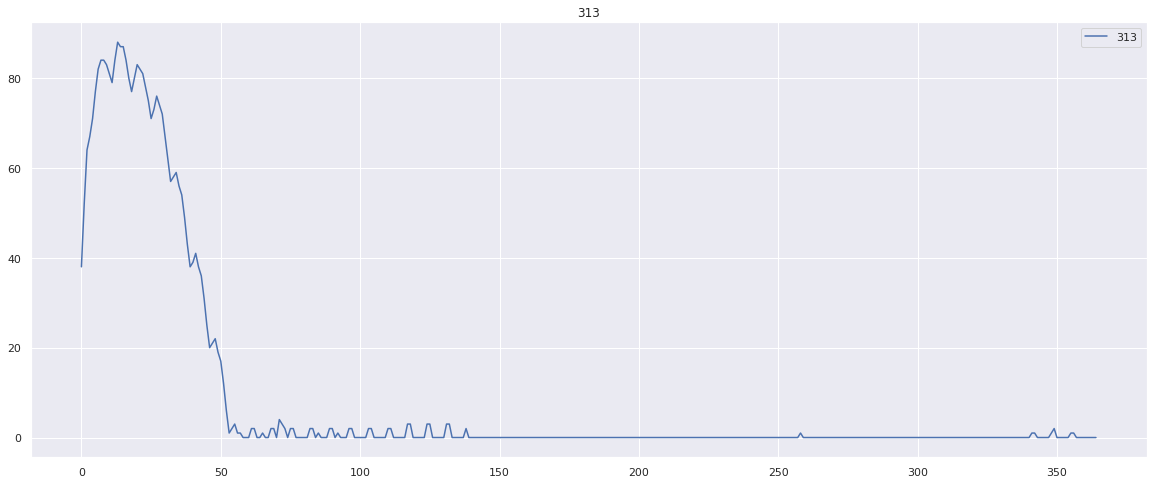

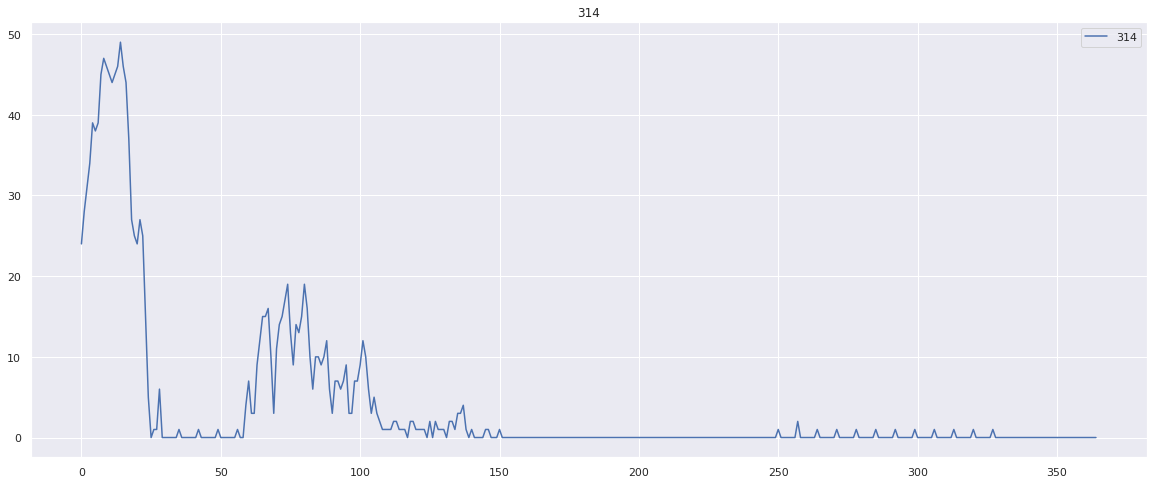

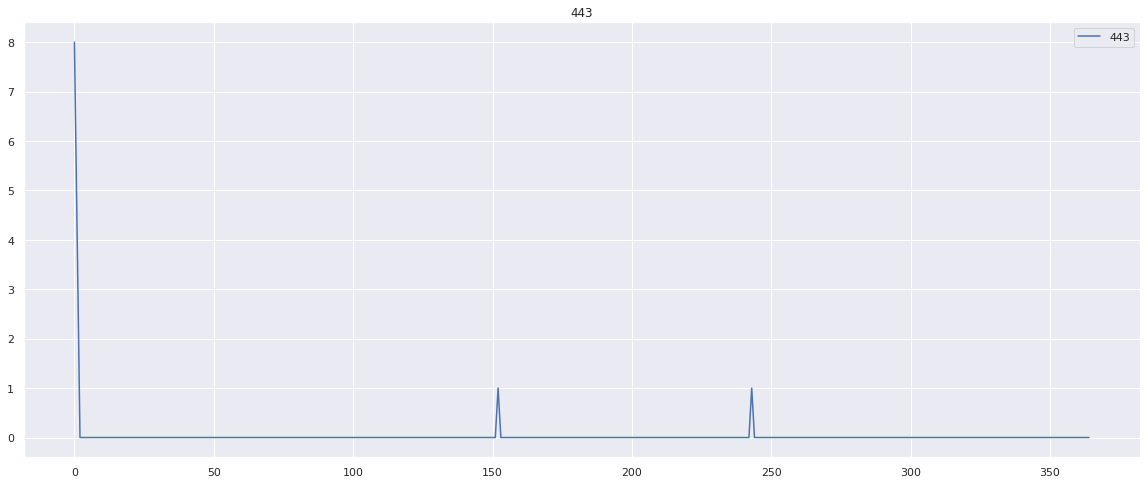

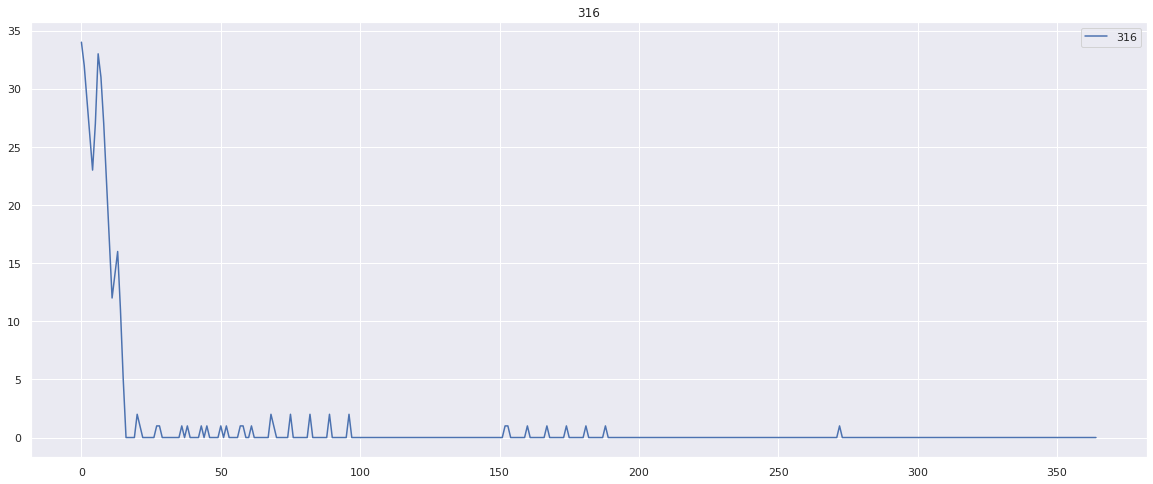

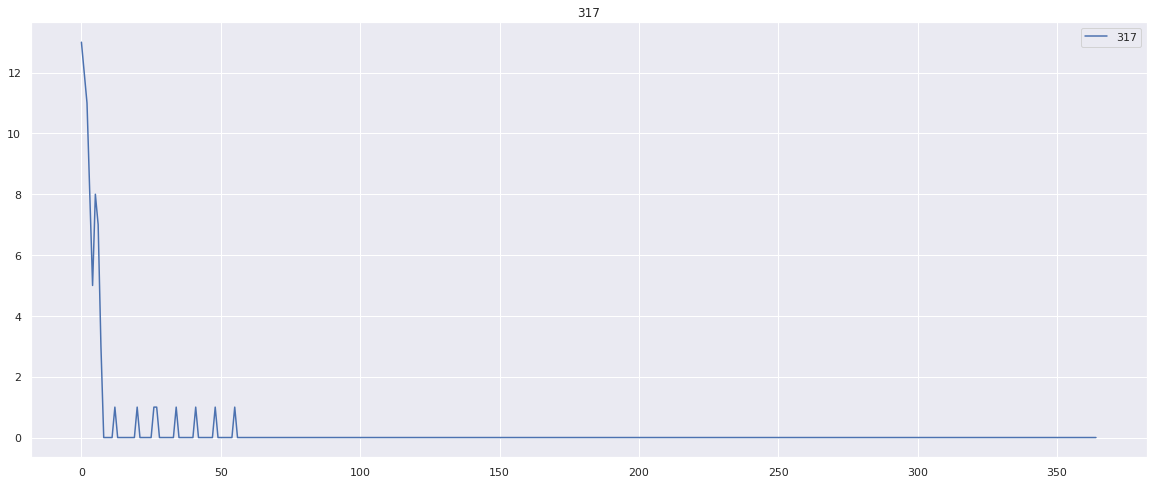

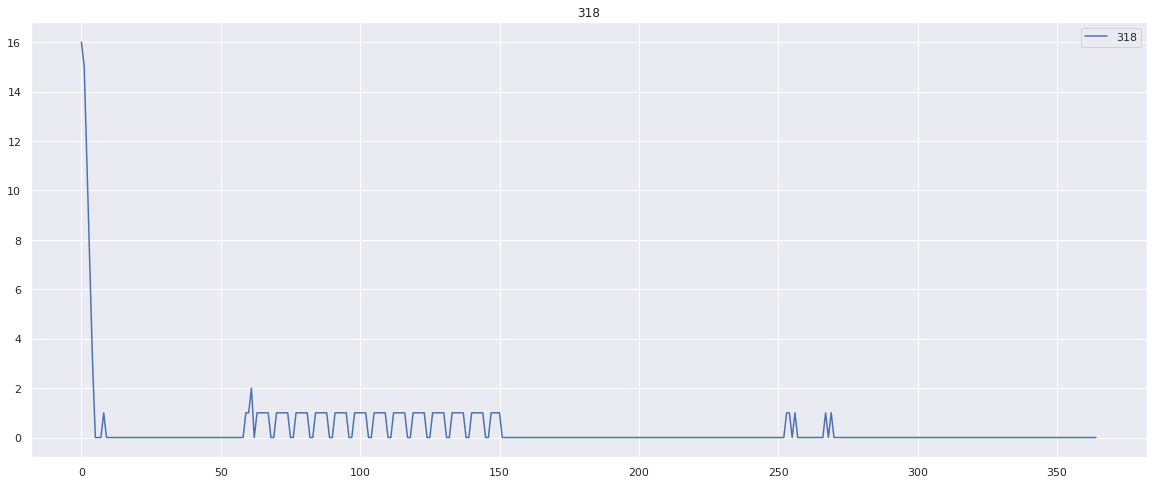

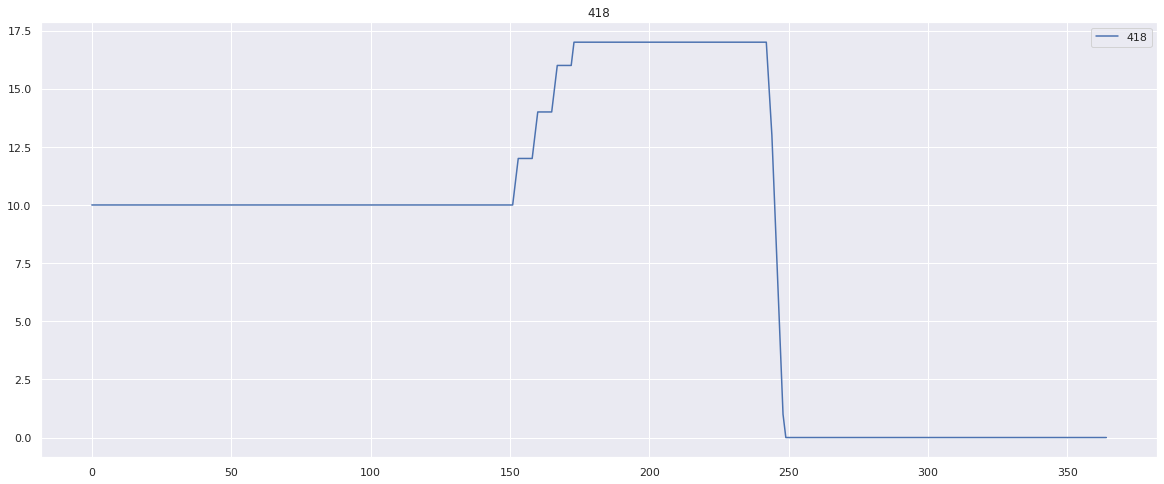

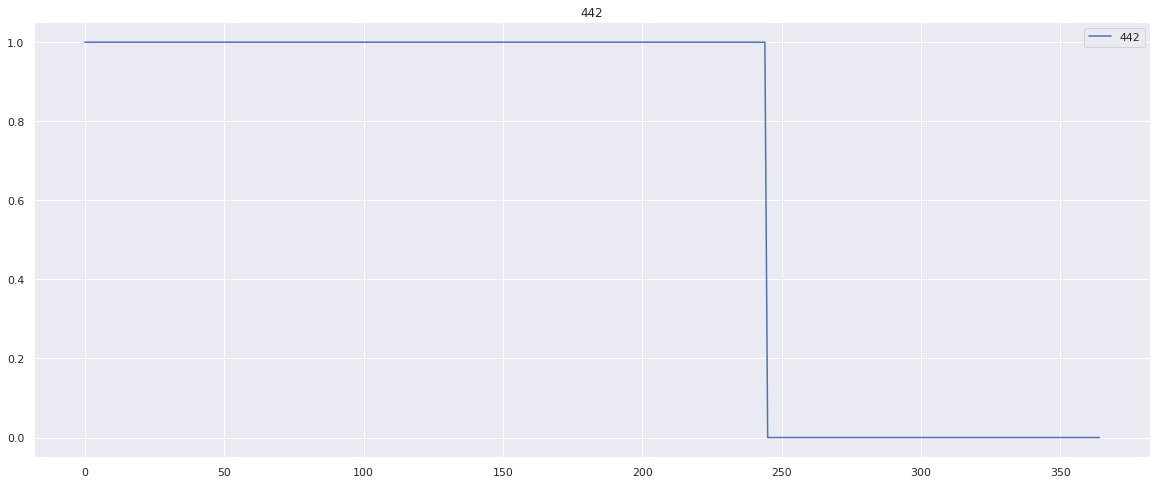

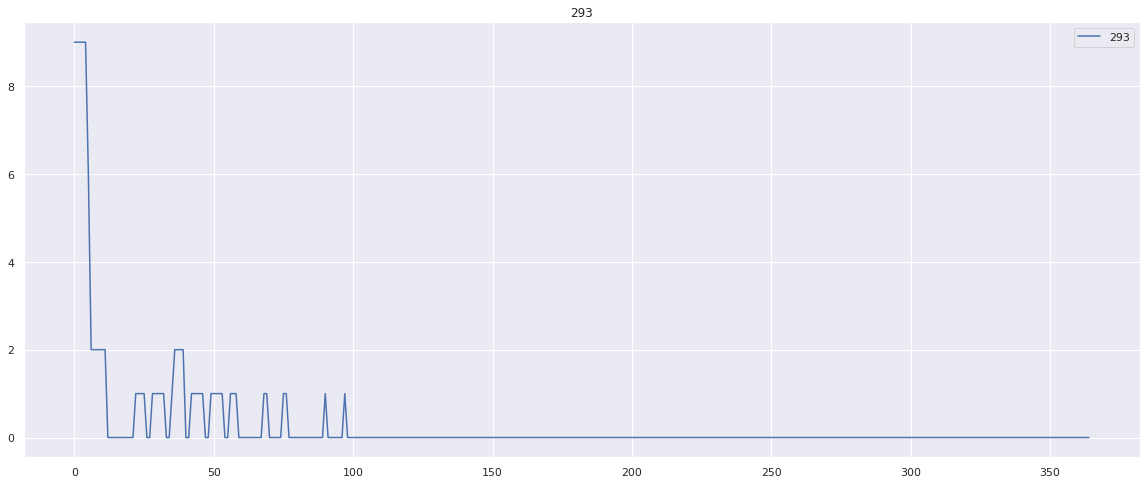

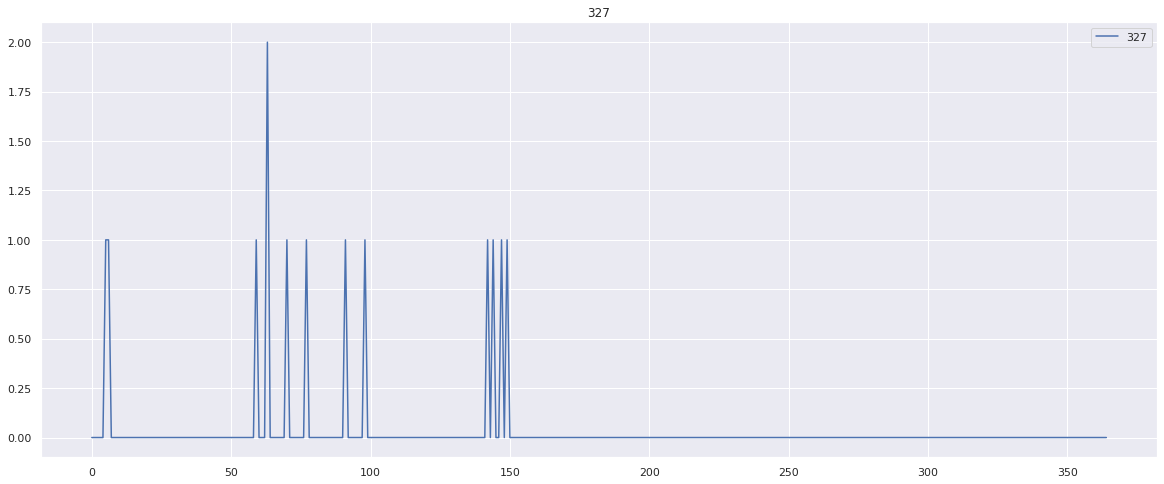

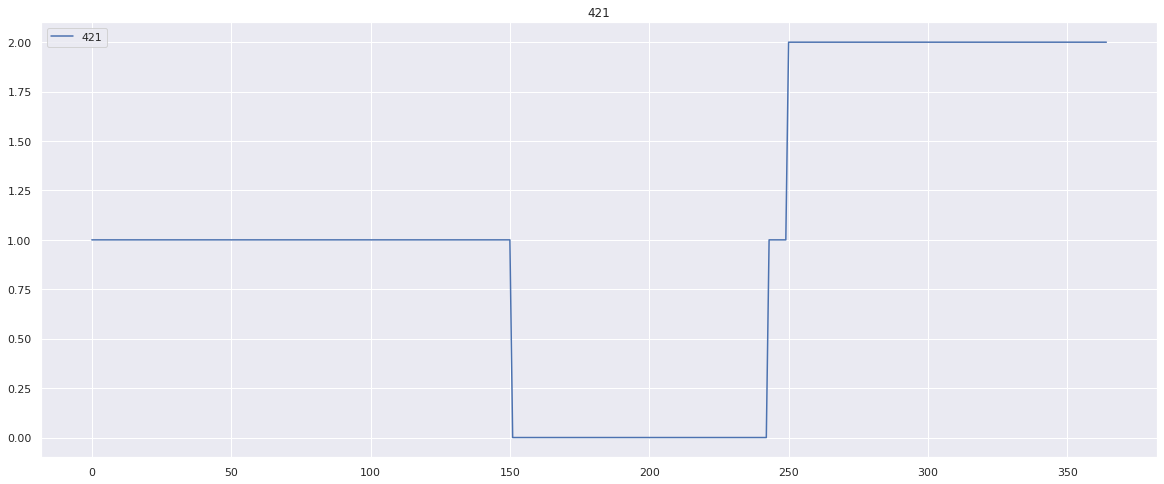

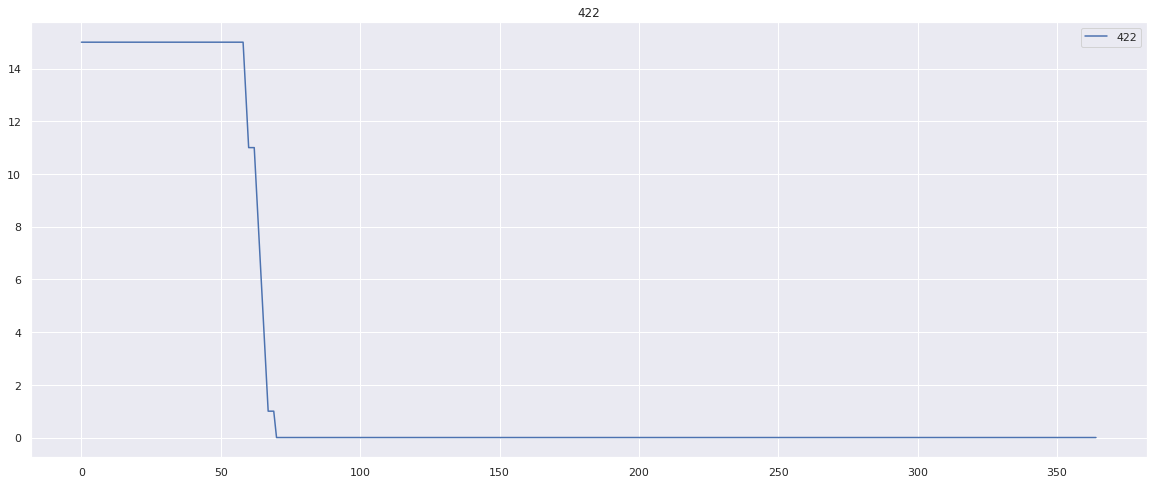

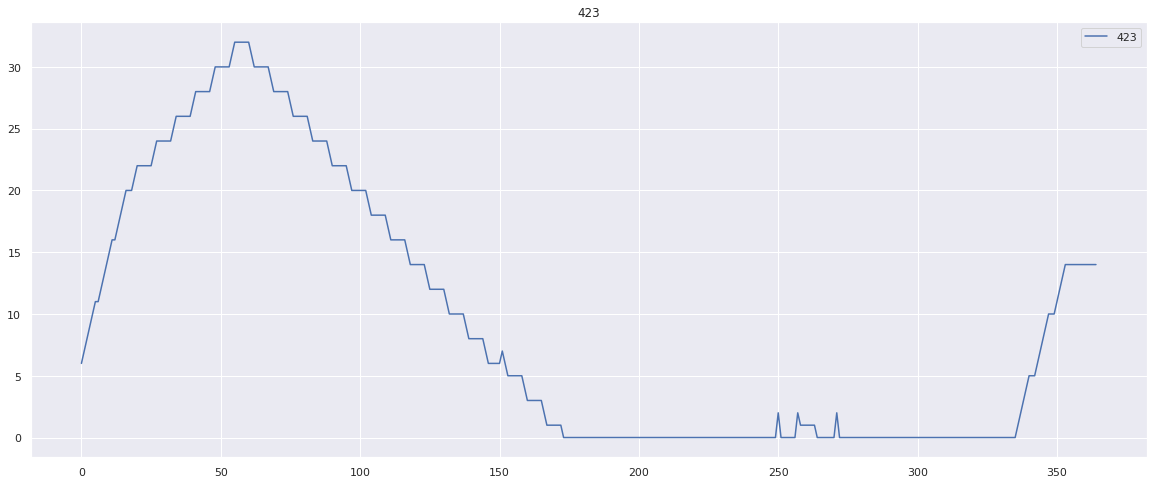

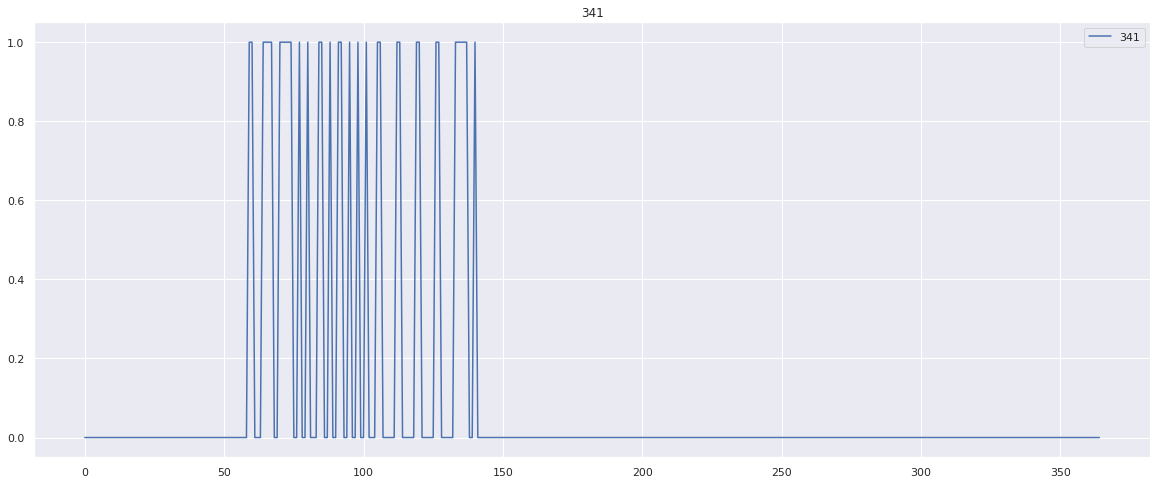

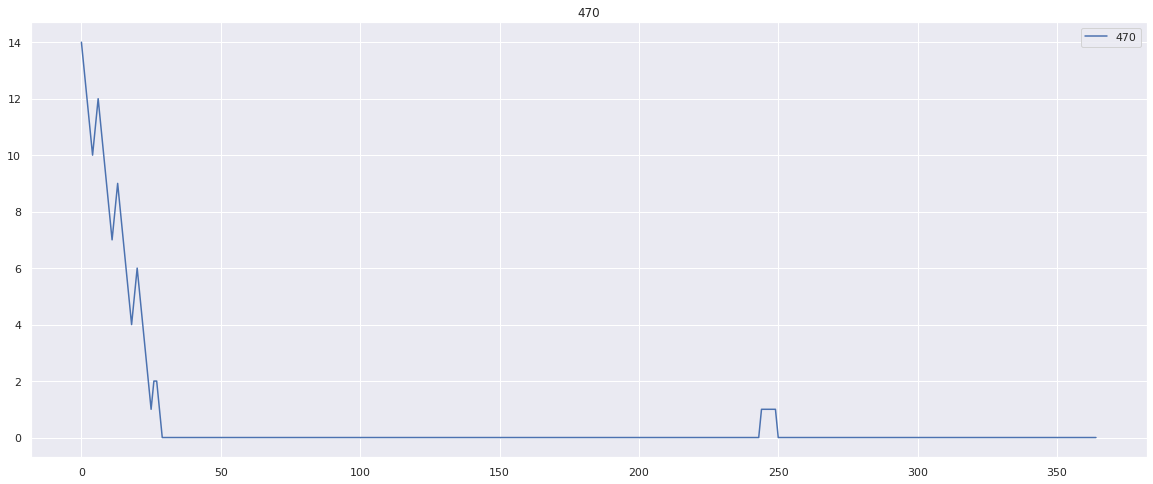

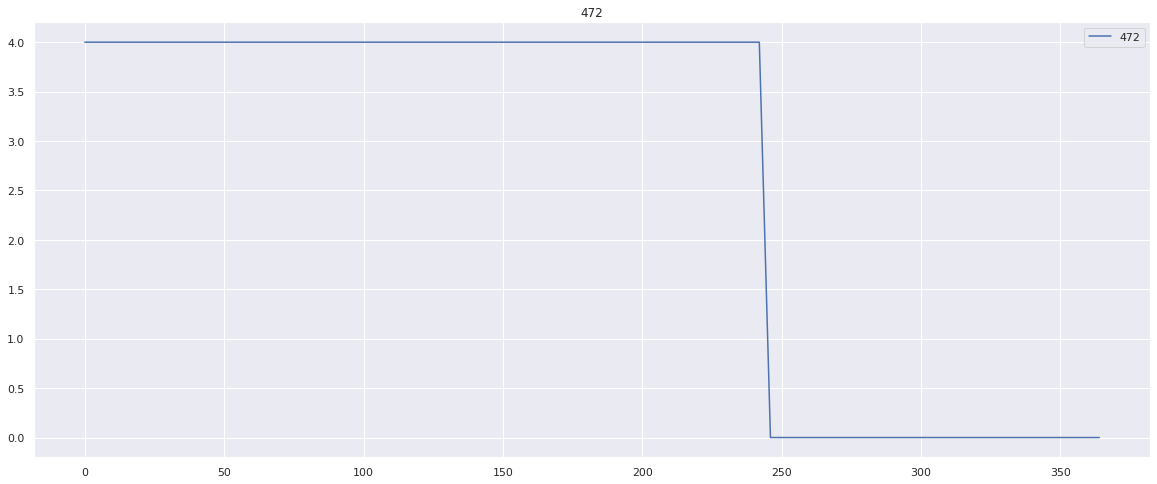

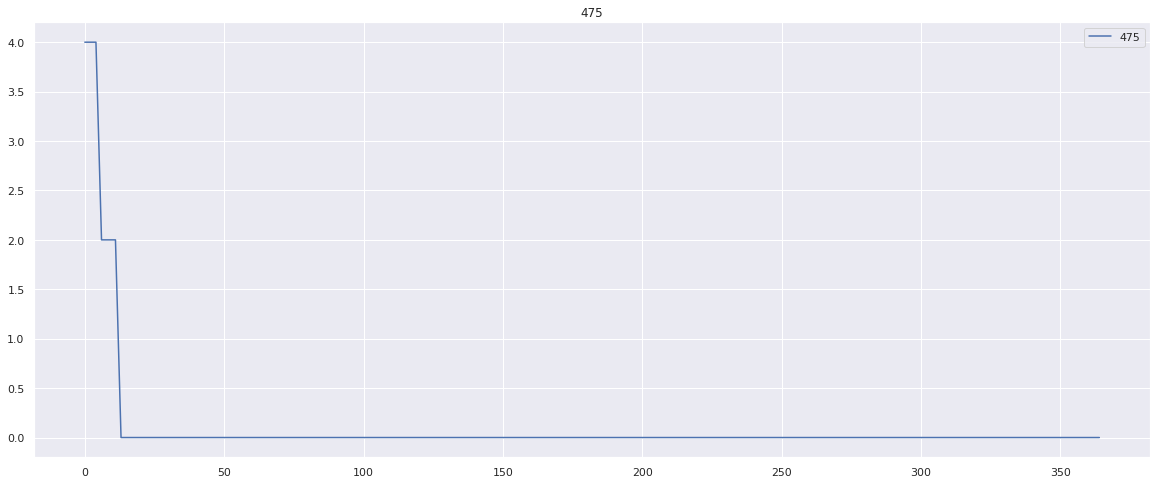

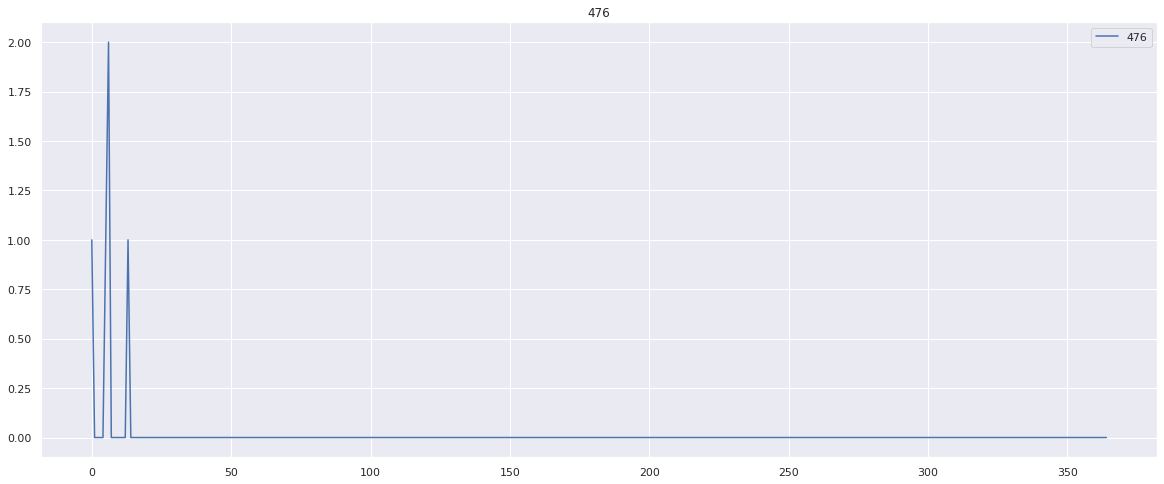

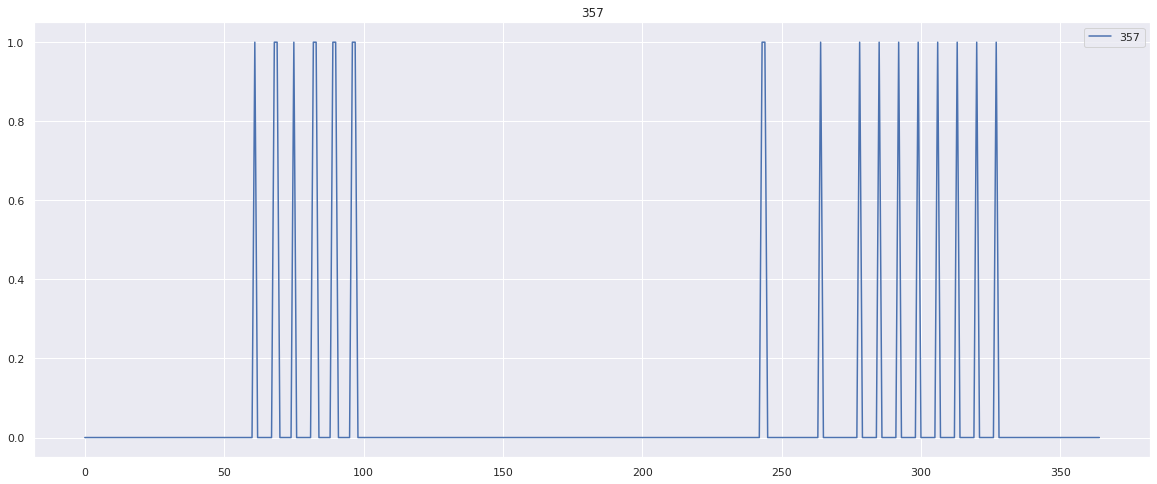

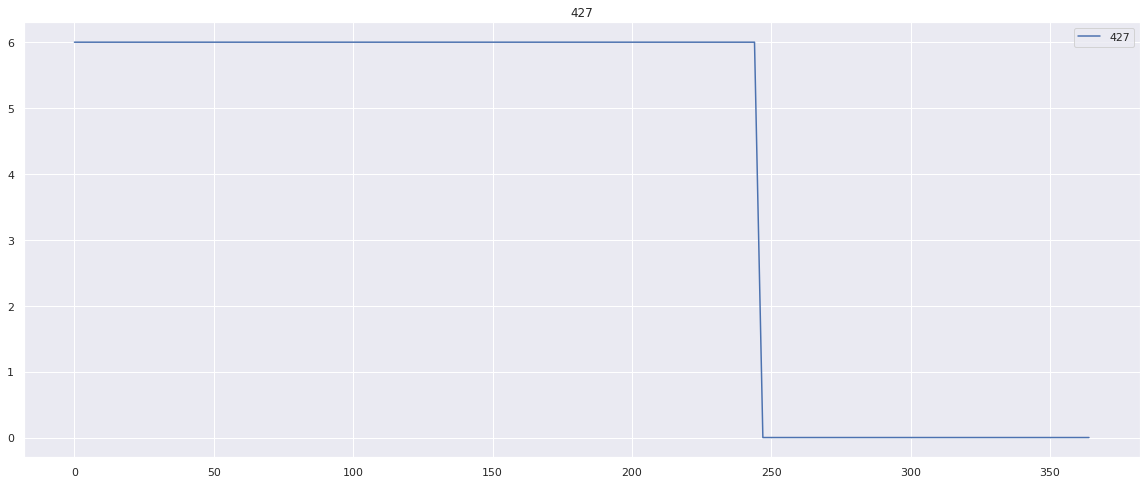

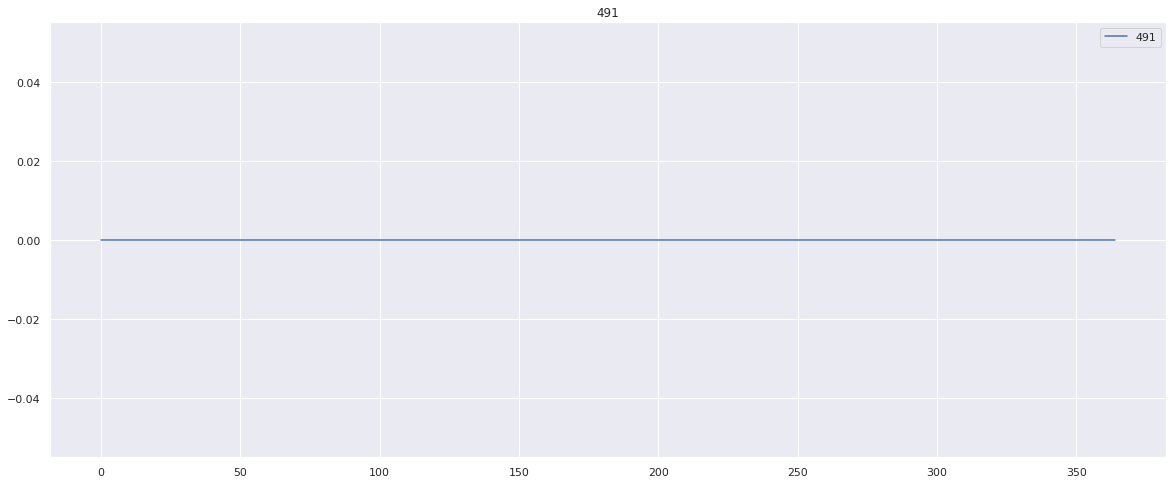

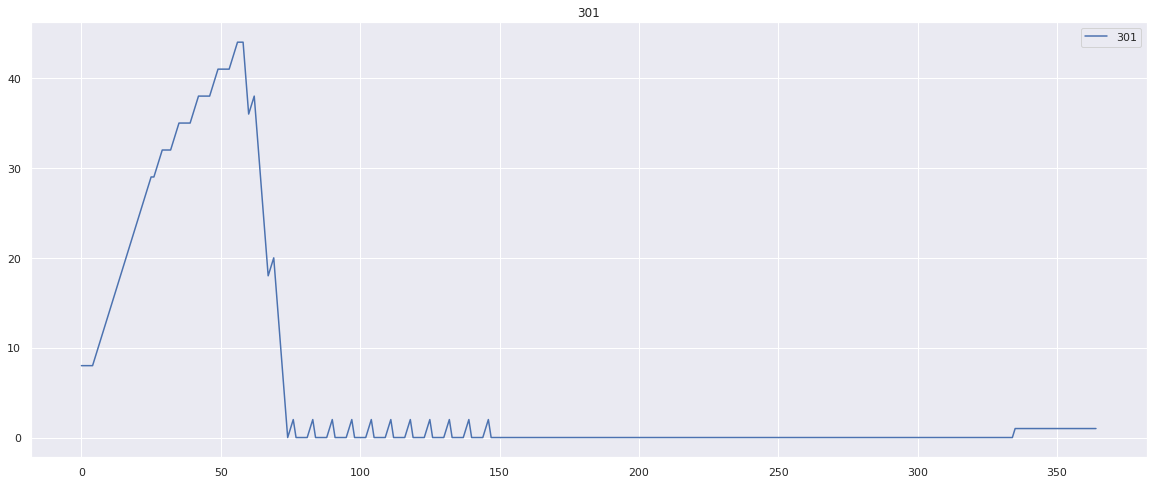

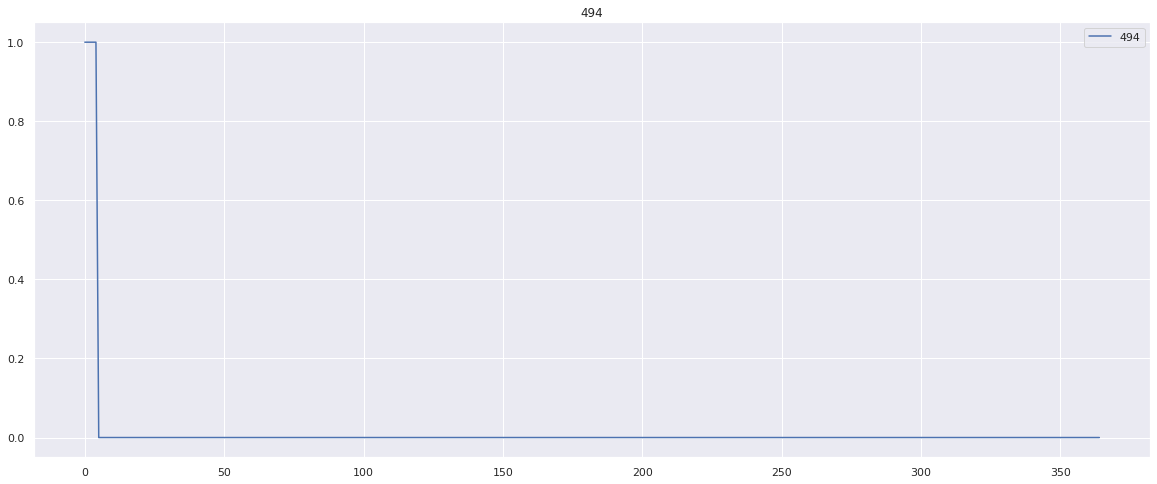

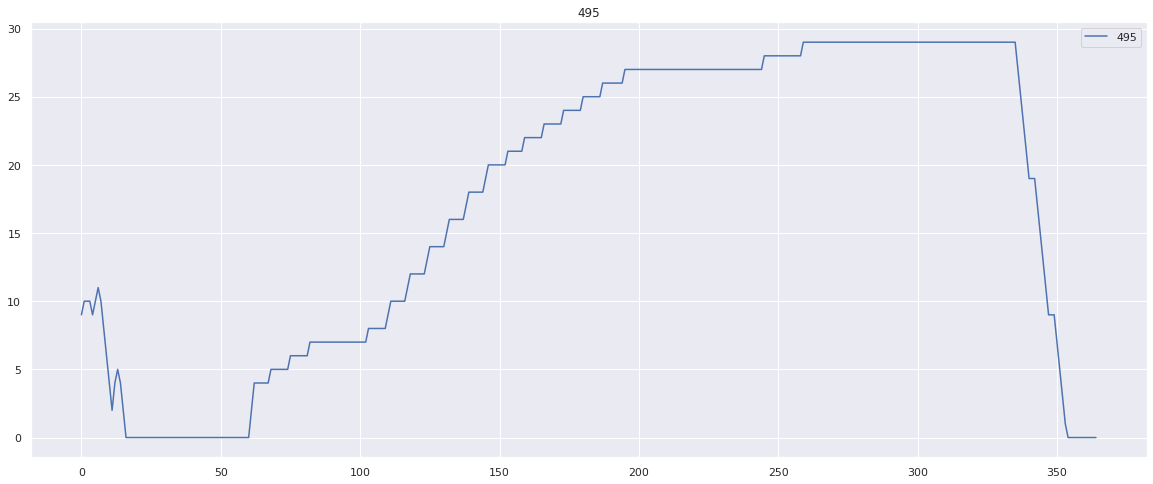

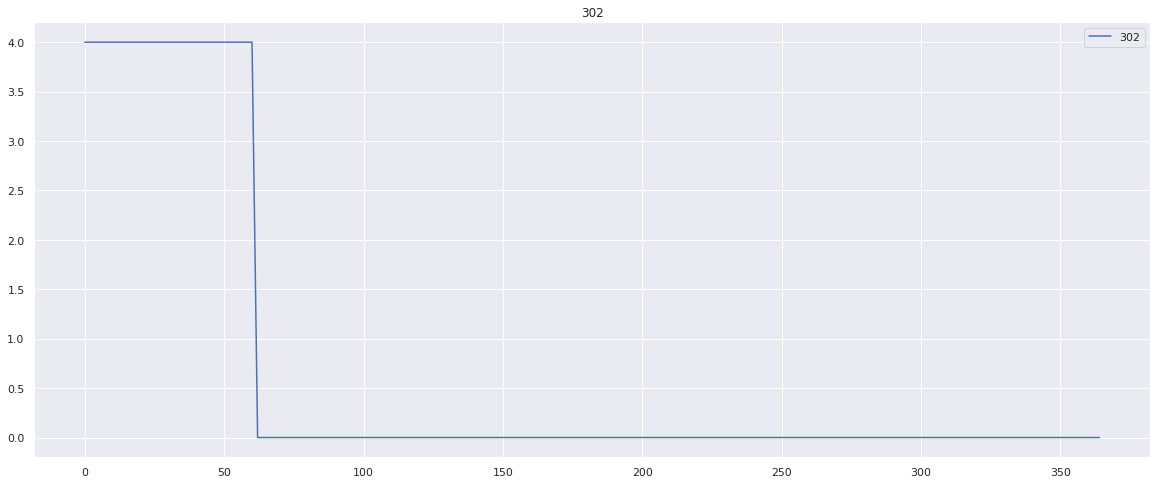

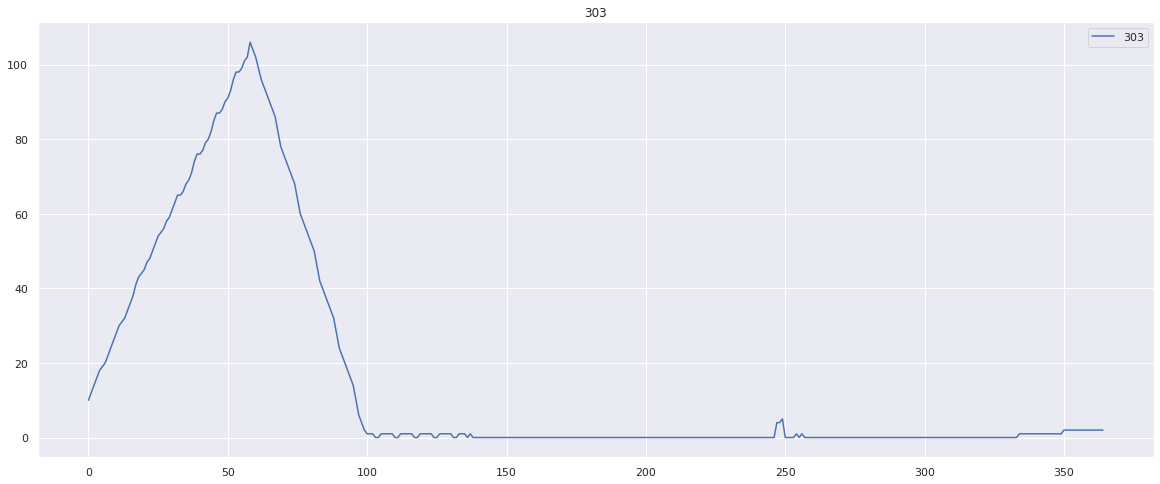

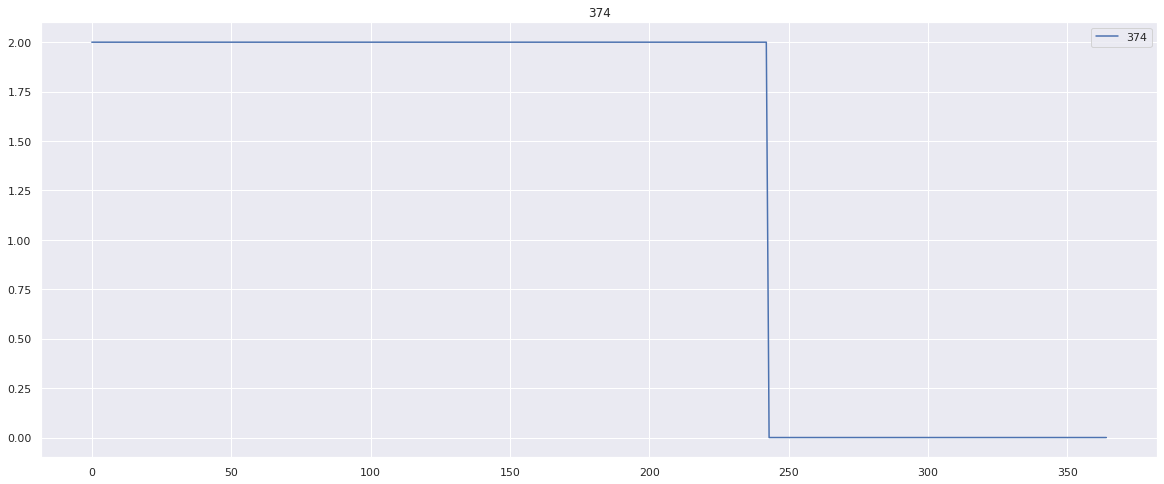

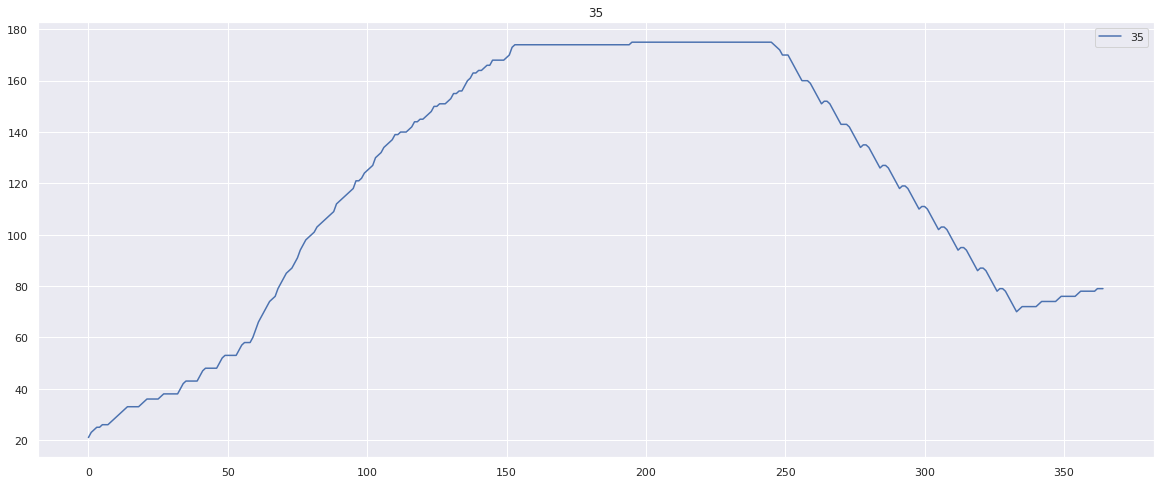

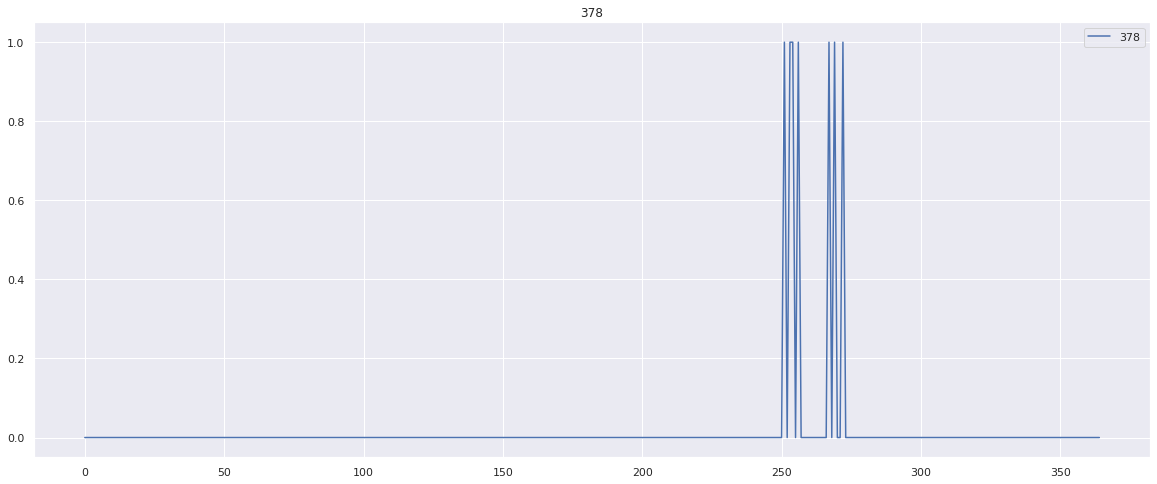

In [ ]:
for x in set(tmp_df['id1']):
  plot_station_bikes_history(tmp_df, x)

2018-2020 2850 bikes FULL

In [13]:
for x in set(tmp_df['id1']):
  plot_station_bikes_history_full(tmp_df, x)

Output hidden; open in https://colab.research.google.com to view.

## OLD 

per vedere se c'e' differenza tra i viaggi della stazione rimossa  e i nuovi viaggi con partenza o destinazione differente causa stazione rimossa

In [ ]:
files = glob.glob(base_path+"data/simulation_history/history_*stationNone_*.csv")

In [ ]:
get_tripsdf(files, changed=False, lost=False)

count       mean       std seed delete_stat
0  6391.0  10.882491  4.309482    0        None
1  6248.0  10.920294  4.307463    1        None
2  6887.0  10.922027  4.287706    2        None
3  6297.0  10.994124  4.326949    3        None
4  6830.0  10.884334  4.287901    4        None
5  6124.0  10.859732  4.234636    5        None
6  6550.0  10.948092  4.275452    6        None
7  6495.0  10.890685  4.262202    7        None
8  6360.0  10.912736  4.297232    8        None
9  6832.0  10.914081  4.268588    9        None

In [ ]:
get_tripsdf(files, changed=False, lost=False, deletedstation=deletedstation)

count       mean       std seed delete_stat
0  306.0  10.294118  4.098592    0        None
1  374.0  10.775401  4.324360    1        None
2  349.0  10.530086  4.178810    2        None
3  379.0  10.936675  4.511150    3        None
4  368.0  10.951087  4.388218    4        None
5  297.0  10.589226  4.240206    5        None
6  388.0  10.360825  4.267988    6        None
7  383.0  10.326371  4.245171    7        None
8  346.0  10.578035  4.626450    8        None
9  395.0  10.556962  4.457204    9        None

In [ ]:
get_tripsdf(files, changed=False, lost=True)

count  mean  std seed delete_stat
0    377   NaN  NaN    0        None
1    376   NaN  NaN    1        None
2    404   NaN  NaN    2        None
3    354   NaN  NaN    3        None
4    358   NaN  NaN    4        None
5    427   NaN  NaN    5        None
6    325   NaN  NaN    6        None
7    355   NaN  NaN    7        None
8    411   NaN  NaN    8        None
9    320   NaN  NaN    9        None

In [ ]:
files = glob.glob(base_path+"data/simulation_*_deletestationNone_*.pkl")

trips = []
for f in files:
  params = f.split('_')
  seed = params[1][4:]
  delete_stat = params[2][13:]
  n_bikes = params[3][5:-4]

  tmphistory = pickle.load(open(f, 'rb'))
  tmphistory = pd.DataFrame(tmphistory).sort_values(by='time1')

  tmphistory = tmphistory[(tmphistory['id1'] == deletedstation) | (tmphistory['id2'] == deletedstation)]
  tmphistory['duration'] = tmphistory['time2'] - tmphistory['time1']
  tmphistory['duration'] = tmphistory['duration'].dt.seconds / 60
  tmphistory = tmphistory['duration'].describe()

  trips.append([tmphistory.loc['count'], tmphistory.loc['mean'], tmphistory.loc['std'], seed])

tripsdf = pd.DataFrame(trips, columns=['count', 'mean', 'std', 'seed'])
tripsdf_none = tripsdf.copy()
print(tripsdf)

   count       mean       std seed
0  406.0  10.665025  4.294827    0
1  345.0  10.985507  4.735727    1
2  382.0  10.549738  4.219861    2
3  332.0  10.346386  4.126096    3
4  362.0  10.538674  4.217087    4
5  317.0  10.599369  4.867263    5
6  378.0  10.621693  4.240421    6
7  383.0  10.483029  4.685289    7
8  448.0  10.491071  4.472627    8
9  367.0  10.667575  4.423436    9


In [ ]:
print(glob.glob(base_path+"data/simulation_*_deletestation[0-9]*.pkl"))
files = glob.glob(base_path+"data/simulation_*_deletestation[0-9]*.pkl")

trips = []
for f in files:
  params = f.split('_')
  seed = params[1][4:]
  delete_stat = params[2][13:]
  n_bikes = params[3][5:-4]

  tmphistory = pickle.load(open(f, 'rb'))
  tmphistory = pd.DataFrame(tmphistory).sort_values(by='time1')

  tmphistory = tmphistory[tmphistory['changed']== True]
  tmphistory['duration'] = tmphistory['time2'] - tmphistory['time1']
  tmphistory['duration'] = tmphistory['duration'].dt.seconds / 60
  tmphistory = tmphistory['duration'].describe()

  trips.append([tmphistory.loc['count'], tmphistory.loc['mean'], tmphistory.loc['std'], seed])

tripsdf = pd.DataFrame(trips, columns=['count', 'mean', 'std', 'seed'])
tripsdf_yes = tripsdf.copy()
print(tripsdf)

['/content/gdrive/MyDrive/complexsystems/data/simulation_seed0_deletestation311_bikes450.pkl', '/content/gdrive/MyDrive/complexsystems/data/simulation_seed1_deletestation311_bikes450.pkl', '/content/gdrive/MyDrive/complexsystems/data/simulation_seed2_deletestation311_bikes450.pkl', '/content/gdrive/MyDrive/complexsystems/data/simulation_seed3_deletestation311_bikes450.pkl', '/content/gdrive/MyDrive/complexsystems/data/simulation_seed4_deletestation311_bikes450.pkl', '/content/gdrive/MyDrive/complexsystems/data/simulation_seed5_deletestation311_bikes450.pkl', '/content/gdrive/MyDrive/complexsystems/data/simulation_seed6_deletestation311_bikes450.pkl', '/content/gdrive/MyDrive/complexsystems/data/simulation_seed7_deletestation311_bikes450.pkl', '/content/gdrive/MyDrive/complexsystems/data/simulation_seed8_deletestation311_bikes450.pkl', '/content/gdrive/MyDrive/complexsystems/data/simulation_seed9_deletestation311_bikes450.pkl']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


   count       mean       std seed
0  190.0  10.105263  4.302020    0
1  200.0  10.300000  4.445086    1
2  194.0  10.231959  4.560794    2
3  183.0  10.000000  4.775165    3
4  200.0   9.825000  4.409261    4
5  169.0  10.384615  4.154745    5
6  192.0  10.442708  4.540320    6
7  151.0   9.900662  4.452348    7
8  192.0  10.468750  4.315934    8
9  176.0  10.710227  4.589567    9


Ttest_indResult(statistic=3.472642415604236, pvalue=0.00271679557847263)
reject null hypotesis that the two independent samples have identical average


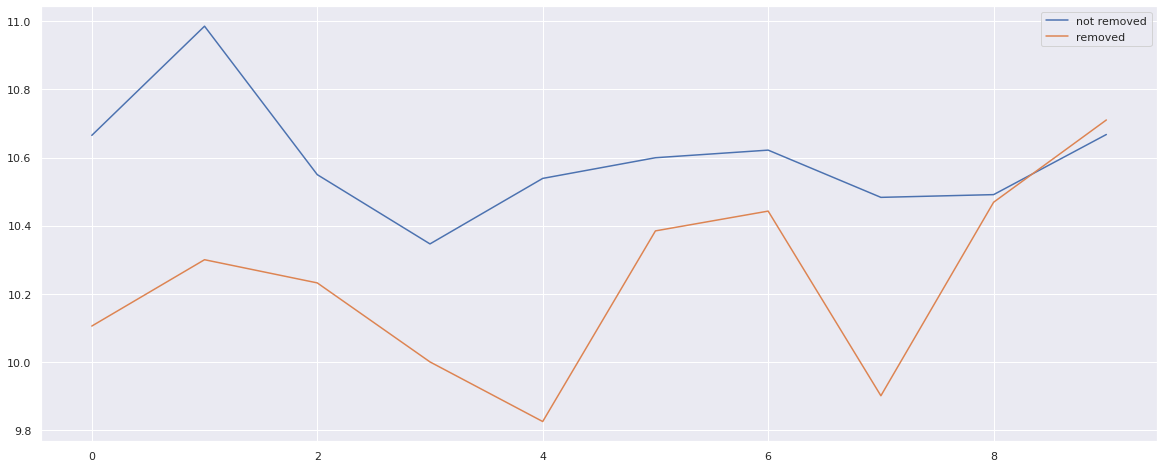

In [ ]:
field = 'mean'

plt.plot(tripsdf_none[field], label='not removed')
plt.plot(tripsdf_yes[field], label='removed')
plt.legend()


from scipy.stats import ttest_ind
stat = ttest_ind(tripsdf_none[field].values, tripsdf_yes[field].values)
print(stat)

if stat.pvalue < 0.05:
  print("reject null hypotesis that the two independent samples have identical average")
else:
  print("DONT reject null hypotesis that the two independent samples have identical average")

Ttest_indResult(statistic=14.596971882049141, pvalue=2.0314291461281228e-11)
reject null hypotesis that the two independent samples have identical average


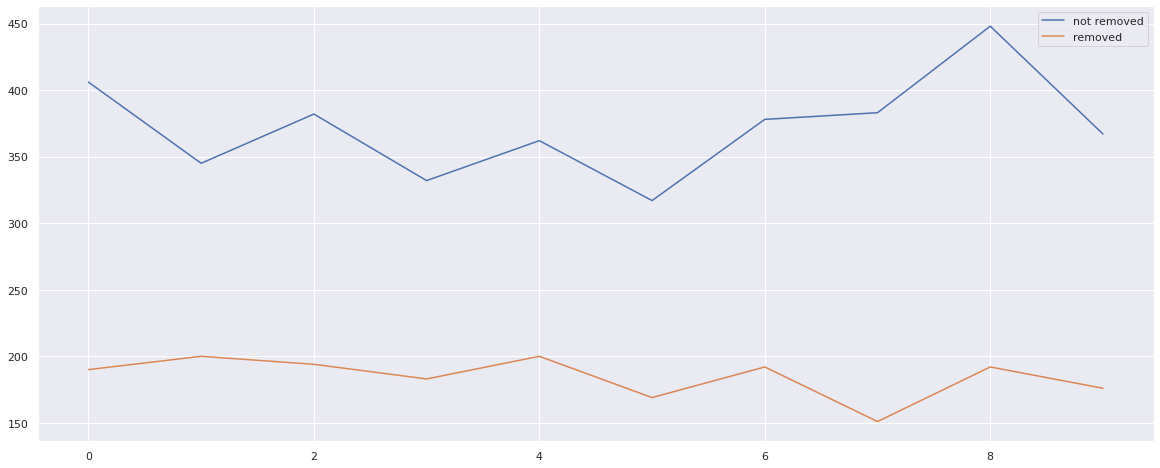

In [ ]:
field = 'count'

plt.plot(tripsdf_none[field], label='not removed')
plt.plot(tripsdf_yes[field], label='removed')
plt.legend()


from scipy.stats import ttest_ind
stat = ttest_ind(tripsdf_none[field].values, tripsdf_yes[field].values)
print(stat)

if stat.pvalue < 0.05:
  print("reject null hypotesis that the two independent samples have identical average")
else:
  print("DONT reject null hypotesis that the two independent samples have identical average")

in conclusione, sono rivelate delle differenze statisticamente valide tra i viaggi che avevano come stazione di partenza o arrivo la stazione in esame nel caso in cui la stazione fosse presente o meno, quindi con il cambio della stazione rimossa con un'altra adiacente